# T81-558: Applications of Deep Neural Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

**Kaggle Assignment: **

**Student Name: Jason Walker**

# Overview

## Description
This is one of the projects from the course T81-855: Applications of Deep Learning at Washington University in St. Louis. All students must create a Kaggle account and submit a solution. Once you have submitted your solution entry log into Blackboard (at WUSTL) and submit a single file telling me your Kaggle name on the leaderboard (you do not need to register to Kaggle with your real name). This competition will be visible to the public, so there may be non-student submissions as well as student.

The data set for this competition consists of a number of input columns that should be used to predict a stores sales. This is a regression problem. The inputs are a mixture of discrete and category values. The data set is from a simulation.

## Evaluation

The evaluation pages describes how submissions will be scored and how students should format their submissions. The scores are in RMSE.
Submission Format

For every store in the dataset, submission files should contain a sales volume.

The file should contain a header and have the following format:

```
100000,1.23
100001,1.123
100002,3.332
100003,1.53
...
```

# Data

## Data Description

The data contains data and costs for various office supplies. The data came from a simulation and do not directly correspond to any real-world items. See how well you can predict the cost of an item using the provided data. Feature engineering will likely help you. The *name* column may seem useless at first glance; however, it contains information that you can parse to help your predictions.
File descriptions
```
    id - The identifier/primary key.
    name - The name of this item.
    manufacturer - The manufacturer.
    pack - The number of items in this pack.
    weight - The weight of a pack of these items.
    height - The height of a pack of these items.
    width - The width of a pack of these items.
    length - The length of a pack of these items.
    cost - The cost for this item pack. This is what you are to predict (the target). 
```

# Helpful Functions

You will see these at the top of every module and assignment.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Kaggle Code



In [99]:
import os
import re
import sklearn

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

path = './data'

filename_test = os.path.join(path,"test.csv")
filename_train = os.path.join(path,"train.csv")
filename_sample = os.path.join(path,"sample.csv")
filename_submit = os.path.join(path,"submit.csv")
filename_checkpoint = os.path.join(path,"checkpoint.hdf5")

df_train = pd.read_csv(filename_train,na_values=['NA','?'])

np.random.seed(42) # Uncomment this line to get the same shuffle each time
df_train = df_train.reindex(np.random.permutation(df_train.index))
df_train.reset_index(inplace=True, drop=True)

# Encode Features

# Remove all rows where the specified column is +/- sd standard deviations
def extract_and_encode_features(df):
    color_regex='(?P<color>red|blue|green|yellow|orange|pink|black|brown|white)'
    df['color'] = df.name.str.extract(color_regex, flags=re.IGNORECASE, expand=False)

    quality_regex='(?P<quality>generic|high\squality)'
    df['quality'] = df.name.str.extract(quality_regex, flags=re.IGNORECASE, expand=False)

    size_regex='(?P<size>tiny|small|medium|large)'
    df['size'] = df.name.str.extract(size_regex, flags=re.IGNORECASE, expand=False)

    item_regex='(?P<item>paperclips|paperweights|ink\spens|pencils|stapler|tablets|thumbtacks|post\sit\snotes)'
    df['item'] = df.name.str.extract(item_regex, flags=re.IGNORECASE, expand=False)
    
    for column in ['pack','weight','height','width','length']:
        missing_median(df,column)
    
    #df.insert(1,'surface_area',(df['height']*df['width']*df['length']).astype(int))
    
    ## encode numeric features
    #for column in ['pack','weight','height','width','length','surface_area']:
    #    encode_numeric_zscore(df,column)

    # encode text/categorical features
    for column in ['manufacturer','color','quality','size','item']:
        encode_text_dummy(df,column)
  
extract_and_encode_features(df_train)

ids_train = df_train['id']
df_train.drop('id',1,inplace=True)

names_train = df_train['name']
df_train.drop('name',1,inplace=True)

x,y = to_xy(df_train,'cost')

# Cross-Validate
kf = KFold(5)

# Used before KFold
#x_train, x_test, y_train, y_test = train_test_split(    
#    x, y, test_size=0.25, random_state=45)


Final score (RMSE): 32.5279541015625
['pack', 'weight', 'height', 'width', 'length', 'manufacturer-6% Solution', 'manufacturer-Deep Office Supplies', 'manufacturer-Duck Lake', 'manufacturer-Offices-R-Us', 'manufacturer-WizBang', 'color-Black', 'color-Blue', 'color-Brown', 'color-Green', 'color-Pink', 'color-Red', 'color-White', 'quality-Generic', 'quality-High Quality', 'size-Large', 'size-Medium', 'size-Small', 'size-Tiny', 'item-Ink Pens', 'item-Paperclips', 'item-Paperweights', 'item-Pencils', 'item-Post It Notes', 'item-Stapler', 'item-Tablets', 'item-Thumbtacks']


,coef,positive
item-Post It Notes,-60.369431,False
item-Thumbtacks,-57.847595,False
item-Pencils,-50.215904,False
item-Paperclips,-43.970024,False
color-Red,-39.540787,False
color-Green,-27.516720,False
color-Blue,-13.250540,False
height,-10.317136,False
length,-8.247688,False
width,-6.184750,False


Intercept: [ 84.28936005]


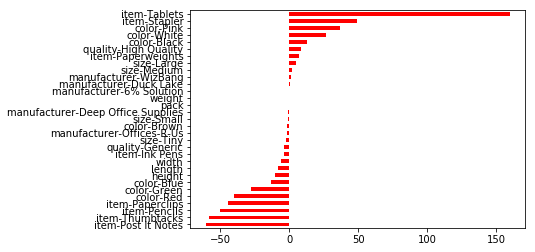

In [96]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    
# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
print(names)
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

In [100]:
checkpoint = ModelCheckpoint(filepath=filename_checkpoint, verbose=0, save_best_only=True)

# Turn off KFold
#if (0):
oos_y = []
oos_pred = []
fold = 0
    
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dropout(0.01)) # Dropout Layer
    model.add(Dense(50, activation='relu')) # Hidden 2
    model.add(Dense(25, 
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01),activation='relu')) # Hidden 3 w/regularization
    model.add(Dense(10, activation='relu')) # Hidden 4
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=1000, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=1,epochs=10000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


Fold #1
Train on 8000 samples, validate on 2000 samples
Epoch 1/10000
8000/8000 [==============================] - 3s 317us/step - loss: 5624.3019 - val_loss: 4982.2033
Epoch 2/10000
8000/8000 [==============================] - 1s 77us/step - loss: 5068.3938 - val_loss: 3891.3121
Epoch 3/10000
8000/8000 [==============================] - 1s 76us/step - loss: 4688.6452 - val_loss: 3762.7149
Epoch 4/10000
8000/8000 [==============================] - 1s 76us/step - loss: 4459.6021 - val_loss: 3707.6230
Epoch 5/10000
8000/8000 [==============================] - 1s 79us/step - loss: 4422.3044 - val_loss: 3635.7628
Epoch 6/10000
8000/8000 [==============================] - 1s 83us/step - loss: 4254.1534 - val_loss: 3585.1237
Epoch 7/10000
8000/8000 [==============================] - 1s 77us/step - loss: 4248.8254 - val_loss: 3482.9459
Epoch 8/10000
8000/8000 [==============================] - 1s 83us/step - loss: 4125.7861 - val_loss: 3490.6342
Epoch 9/10000
8000/8000 [======================

Epoch 74/10000
8000/8000 [==============================] - 0s 61us/step - loss: 371.0766 - val_loss: 953.3586
Epoch 75/10000
8000/8000 [==============================] - 0s 61us/step - loss: 485.6512 - val_loss: 287.1195
Epoch 76/10000
8000/8000 [==============================] - 1s 63us/step - loss: 323.0671 - val_loss: 301.3118
Epoch 77/10000
8000/8000 [==============================] - 1s 65us/step - loss: 328.6502 - val_loss: 244.8098
Epoch 78/10000
8000/8000 [==============================] - 0s 62us/step - loss: 294.5819 - val_loss: 358.8018
Epoch 79/10000
8000/8000 [==============================] - 0s 60us/step - loss: 283.8425 - val_loss: 249.2717
Epoch 80/10000
8000/8000 [==============================] - 0s 61us/step - loss: 310.9377 - val_loss: 244.4925
Epoch 81/10000
8000/8000 [==============================] - 1s 64us/step - loss: 359.8256 - val_loss: 231.2172
Epoch 82/10000
8000/8000 [==============================] - 1s 68us/step - loss: 395.9669 - val_loss: 477.0307
E

8000/8000 [==============================] - 1s 66us/step - loss: 287.7566 - val_loss: 209.1656
Epoch 148/10000
8000/8000 [==============================] - 1s 63us/step - loss: 270.7238 - val_loss: 361.9252
Epoch 149/10000
8000/8000 [==============================] - 0s 59us/step - loss: 232.3643 - val_loss: 341.4110
Epoch 150/10000
8000/8000 [==============================] - 0s 61us/step - loss: 336.3872 - val_loss: 238.8333
Epoch 151/10000
8000/8000 [==============================] - 0s 61us/step - loss: 228.6927 - val_loss: 191.2031
Epoch 152/10000
8000/8000 [==============================] - 1s 65us/step - loss: 238.5040 - val_loss: 182.8452
Epoch 153/10000
8000/8000 [==============================] - 1s 63us/step - loss: 228.1476 - val_loss: 175.0697
Epoch 154/10000
8000/8000 [==============================] - 1s 63us/step - loss: 242.3212 - val_loss: 1199.6603
Epoch 155/10000
8000/8000 [==============================] - 0s 62us/step - loss: 413.0803 - val_loss: 199.8866
Epoch 1

8000/8000 [==============================] - 1s 63us/step - loss: 215.7802 - val_loss: 485.3178
Epoch 221/10000
8000/8000 [==============================] - 0s 60us/step - loss: 221.0094 - val_loss: 371.7806
Epoch 222/10000
8000/8000 [==============================] - 0s 60us/step - loss: 263.7156 - val_loss: 169.7739
Epoch 223/10000
8000/8000 [==============================] - 0s 61us/step - loss: 248.1027 - val_loss: 208.7873
Epoch 224/10000
8000/8000 [==============================] - 1s 65us/step - loss: 247.3086 - val_loss: 165.4756
Epoch 225/10000
8000/8000 [==============================] - 0s 61us/step - loss: 263.0621 - val_loss: 192.6232
Epoch 226/10000
8000/8000 [==============================] - 0s 59us/step - loss: 210.6889 - val_loss: 172.2014
Epoch 227/10000
8000/8000 [==============================] - 0s 62us/step - loss: 330.2348 - val_loss: 192.2240
Epoch 228/10000
8000/8000 [==============================] - 0s 61us/step - loss: 223.8258 - val_loss: 188.0233
Epoch 22

8000/8000 [==============================] - 0s 60us/step - loss: 232.6794 - val_loss: 283.2064
Epoch 294/10000
8000/8000 [==============================] - 0s 60us/step - loss: 223.3971 - val_loss: 202.2654
Epoch 295/10000
8000/8000 [==============================] - 0s 60us/step - loss: 360.7760 - val_loss: 380.2499
Epoch 296/10000
8000/8000 [==============================] - 0s 59us/step - loss: 237.7064 - val_loss: 198.5851
Epoch 297/10000
8000/8000 [==============================] - 0s 60us/step - loss: 199.0697 - val_loss: 232.3643
Epoch 298/10000
8000/8000 [==============================] - 0s 60us/step - loss: 307.6969 - val_loss: 305.4369
Epoch 299/10000
8000/8000 [==============================] - 0s 59us/step - loss: 205.1341 - val_loss: 188.3225
Epoch 300/10000
8000/8000 [==============================] - 0s 62us/step - loss: 229.4939 - val_loss: 176.6202
Epoch 301/10000
8000/8000 [==============================] - 0s 61us/step - loss: 221.2225 - val_loss: 182.5453
Epoch 30

8000/8000 [==============================] - 0s 61us/step - loss: 243.5909 - val_loss: 165.3372
Epoch 367/10000
8000/8000 [==============================] - 1s 63us/step - loss: 293.3701 - val_loss: 324.5879
Epoch 368/10000
8000/8000 [==============================] - 0s 61us/step - loss: 224.1930 - val_loss: 224.2980
Epoch 369/10000
8000/8000 [==============================] - 0s 60us/step - loss: 214.4459 - val_loss: 199.0175
Epoch 370/10000
8000/8000 [==============================] - 0s 60us/step - loss: 228.2316 - val_loss: 178.0408
Epoch 371/10000
8000/8000 [==============================] - 0s 59us/step - loss: 200.5987 - val_loss: 275.4594
Epoch 372/10000
8000/8000 [==============================] - 0s 59us/step - loss: 219.1679 - val_loss: 220.3596
Epoch 373/10000
8000/8000 [==============================] - 0s 60us/step - loss: 211.8766 - val_loss: 164.7564
Epoch 374/10000
8000/8000 [==============================] - 0s 61us/step - loss: 253.1624 - val_loss: 385.1811
Epoch 37

8000/8000 [==============================] - 0s 59us/step - loss: 187.7005 - val_loss: 163.7499
Epoch 440/10000
8000/8000 [==============================] - 0s 62us/step - loss: 171.6217 - val_loss: 155.5521
Epoch 441/10000
8000/8000 [==============================] - 0s 60us/step - loss: 269.8212 - val_loss: 696.3603
Epoch 442/10000
8000/8000 [==============================] - 0s 62us/step - loss: 231.1107 - val_loss: 232.4163
Epoch 443/10000
8000/8000 [==============================] - 0s 59us/step - loss: 201.9253 - val_loss: 363.4618
Epoch 444/10000
8000/8000 [==============================] - 0s 61us/step - loss: 278.2773 - val_loss: 195.0331
Epoch 445/10000
8000/8000 [==============================] - 0s 59us/step - loss: 185.5816 - val_loss: 167.3198
Epoch 446/10000
8000/8000 [==============================] - 0s 60us/step - loss: 184.5327 - val_loss: 170.9548
Epoch 447/10000
8000/8000 [==============================] - 0s 61us/step - loss: 181.6772 - val_loss: 195.3663
Epoch 44

8000/8000 [==============================] - 0s 60us/step - loss: 201.0607 - val_loss: 152.3924
Epoch 513/10000
8000/8000 [==============================] - 0s 60us/step - loss: 196.2989 - val_loss: 162.8822
Epoch 514/10000
8000/8000 [==============================] - 0s 60us/step - loss: 189.2500 - val_loss: 148.4142
Epoch 515/10000
8000/8000 [==============================] - 0s 60us/step - loss: 211.1780 - val_loss: 357.8523
Epoch 516/10000
8000/8000 [==============================] - 0s 60us/step - loss: 243.7025 - val_loss: 147.9555
Epoch 517/10000
8000/8000 [==============================] - 1s 63us/step - loss: 180.5890 - val_loss: 151.2866
Epoch 518/10000
8000/8000 [==============================] - 0s 59us/step - loss: 165.5671 - val_loss: 145.5552
Epoch 519/10000
8000/8000 [==============================] - 0s 60us/step - loss: 171.1836 - val_loss: 169.1728
Epoch 520/10000
8000/8000 [==============================] - 0s 60us/step - loss: 168.4264 - val_loss: 149.1209
Epoch 52

8000/8000 [==============================] - 0s 62us/step - loss: 227.1508 - val_loss: 247.0917
Epoch 586/10000
8000/8000 [==============================] - 0s 60us/step - loss: 174.0170 - val_loss: 147.2380
Epoch 587/10000
8000/8000 [==============================] - 0s 59us/step - loss: 205.9321 - val_loss: 160.3853
Epoch 588/10000
8000/8000 [==============================] - 0s 59us/step - loss: 219.2597 - val_loss: 157.1139
Epoch 589/10000
8000/8000 [==============================] - 0s 60us/step - loss: 190.8135 - val_loss: 178.7156
Epoch 590/10000
8000/8000 [==============================] - 0s 62us/step - loss: 177.3799 - val_loss: 176.4029
Epoch 591/10000
8000/8000 [==============================] - 0s 60us/step - loss: 189.0750 - val_loss: 150.5969
Epoch 592/10000
8000/8000 [==============================] - 0s 59us/step - loss: 178.9128 - val_loss: 188.9616
Epoch 593/10000
8000/8000 [==============================] - 0s 61us/step - loss: 218.7443 - val_loss: 169.4307
Epoch 59

8000/8000 [==============================] - 1s 72us/step - loss: 161.3746 - val_loss: 174.6527
Epoch 659/10000
8000/8000 [==============================] - 1s 67us/step - loss: 545.9673 - val_loss: 221.2997
Epoch 660/10000
8000/8000 [==============================] - 0s 59us/step - loss: 199.4549 - val_loss: 166.4489
Epoch 661/10000
8000/8000 [==============================] - 1s 63us/step - loss: 158.2227 - val_loss: 142.2650
Epoch 662/10000
8000/8000 [==============================] - 0s 59us/step - loss: 177.7230 - val_loss: 150.1362
Epoch 663/10000
8000/8000 [==============================] - 0s 60us/step - loss: 280.6576 - val_loss: 234.2186
Epoch 664/10000
8000/8000 [==============================] - 0s 60us/step - loss: 166.2062 - val_loss: 183.9594
Epoch 665/10000
8000/8000 [==============================] - 0s 62us/step - loss: 166.2015 - val_loss: 215.2163
Epoch 666/10000
8000/8000 [==============================] - 0s 62us/step - loss: 173.1798 - val_loss: 170.9650
Epoch 66

8000/8000 [==============================] - 1s 66us/step - loss: 271.1828 - val_loss: 242.7306
Epoch 732/10000
8000/8000 [==============================] - 1s 67us/step - loss: 177.2478 - val_loss: 181.9000
Epoch 733/10000
8000/8000 [==============================] - 1s 66us/step - loss: 160.1946 - val_loss: 201.8385
Epoch 734/10000
8000/8000 [==============================] - 0s 60us/step - loss: 151.4494 - val_loss: 151.3395
Epoch 735/10000
8000/8000 [==============================] - 0s 61us/step - loss: 156.6140 - val_loss: 162.1801
Epoch 736/10000
8000/8000 [==============================] - 0s 60us/step - loss: 168.7678 - val_loss: 175.4274
Epoch 737/10000
8000/8000 [==============================] - 0s 61us/step - loss: 247.6237 - val_loss: 295.3348
Epoch 738/10000
8000/8000 [==============================] - 0s 60us/step - loss: 181.2419 - val_loss: 168.9422
Epoch 739/10000
8000/8000 [==============================] - 0s 59us/step - loss: 178.0106 - val_loss: 210.0810
Epoch 74

8000/8000 [==============================] - 0s 60us/step - loss: 208.4023 - val_loss: 158.6036
Epoch 805/10000
8000/8000 [==============================] - 0s 61us/step - loss: 207.0609 - val_loss: 246.2863
Epoch 806/10000
8000/8000 [==============================] - 0s 59us/step - loss: 180.0662 - val_loss: 158.0904
Epoch 807/10000
8000/8000 [==============================] - 0s 59us/step - loss: 188.4233 - val_loss: 179.1957
Epoch 808/10000
8000/8000 [==============================] - 0s 60us/step - loss: 201.0714 - val_loss: 168.6310
Epoch 809/10000
8000/8000 [==============================] - 0s 59us/step - loss: 210.9704 - val_loss: 172.6833
Epoch 810/10000
8000/8000 [==============================] - 0s 61us/step - loss: 206.9296 - val_loss: 405.8064
Epoch 811/10000
8000/8000 [==============================] - 0s 61us/step - loss: 199.1632 - val_loss: 189.9887
Epoch 812/10000
8000/8000 [==============================] - 0s 60us/step - loss: 194.2682 - val_loss: 146.8185
Epoch 81

8000/8000 [==============================] - 1s 67us/step - loss: 205.6283 - val_loss: 159.2562
Epoch 878/10000
8000/8000 [==============================] - 0s 59us/step - loss: 172.8233 - val_loss: 174.0923
Epoch 879/10000
8000/8000 [==============================] - 0s 60us/step - loss: 199.7009 - val_loss: 151.9098
Epoch 880/10000
8000/8000 [==============================] - 0s 60us/step - loss: 253.7354 - val_loss: 190.3630
Epoch 881/10000
8000/8000 [==============================] - 0s 59us/step - loss: 180.0039 - val_loss: 147.6964
Epoch 882/10000
8000/8000 [==============================] - 0s 60us/step - loss: 224.6456 - val_loss: 171.2053
Epoch 883/10000
8000/8000 [==============================] - 0s 61us/step - loss: 161.9610 - val_loss: 196.9269
Epoch 884/10000
8000/8000 [==============================] - 0s 58us/step - loss: 159.9629 - val_loss: 167.7736
Epoch 885/10000
8000/8000 [==============================] - 0s 60us/step - loss: 176.4507 - val_loss: 155.9926
Epoch 88

8000/8000 [==============================] - 0s 59us/step - loss: 171.4779 - val_loss: 237.0188
Epoch 951/10000
8000/8000 [==============================] - 0s 60us/step - loss: 156.5646 - val_loss: 155.1285
Epoch 952/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.2310 - val_loss: 160.4563
Epoch 953/10000
8000/8000 [==============================] - 0s 62us/step - loss: 169.2782 - val_loss: 153.2310
Epoch 954/10000
8000/8000 [==============================] - 0s 58us/step - loss: 147.1963 - val_loss: 140.1901
Epoch 955/10000
8000/8000 [==============================] - 0s 60us/step - loss: 162.4265 - val_loss: 190.1810
Epoch 956/10000
8000/8000 [==============================] - 0s 62us/step - loss: 157.0929 - val_loss: 158.6265
Epoch 957/10000
8000/8000 [==============================] - 0s 59us/step - loss: 181.3245 - val_loss: 172.4371
Epoch 958/10000
8000/8000 [==============================] - 0s 60us/step - loss: 178.6523 - val_loss: 208.9709
Epoch 95

8000/8000 [==============================] - 1s 74us/step - loss: 192.3422 - val_loss: 142.3976
Epoch 1024/10000
8000/8000 [==============================] - 1s 77us/step - loss: 158.3634 - val_loss: 141.9293
Epoch 1025/10000
8000/8000 [==============================] - 1s 68us/step - loss: 151.9735 - val_loss: 140.2522
Epoch 1026/10000
8000/8000 [==============================] - 0s 59us/step - loss: 173.2566 - val_loss: 163.8193
Epoch 1027/10000
8000/8000 [==============================] - 0s 59us/step - loss: 149.2444 - val_loss: 151.7893
Epoch 1028/10000
8000/8000 [==============================] - 0s 60us/step - loss: 171.4490 - val_loss: 158.8351
Epoch 1029/10000
8000/8000 [==============================] - 0s 62us/step - loss: 174.3796 - val_loss: 219.7320
Epoch 1030/10000
8000/8000 [==============================] - 0s 59us/step - loss: 170.3561 - val_loss: 183.9259
Epoch 1031/10000
8000/8000 [==============================] - 0s 60us/step - loss: 167.3247 - val_loss: 148.5114


8000/8000 [==============================] - 0s 61us/step - loss: 139.1572 - val_loss: 158.9781
Epoch 1096/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.9496 - val_loss: 155.4967
Epoch 1097/10000
8000/8000 [==============================] - 0s 60us/step - loss: 150.1255 - val_loss: 282.6894
Epoch 1098/10000
8000/8000 [==============================] - 1s 66us/step - loss: 169.2981 - val_loss: 144.9399
Epoch 1099/10000
8000/8000 [==============================] - 1s 81us/step - loss: 164.1344 - val_loss: 240.2325
Epoch 1100/10000
8000/8000 [==============================] - 1s 89us/step - loss: 178.7128 - val_loss: 186.7308
Epoch 1101/10000
8000/8000 [==============================] - 1s 73us/step - loss: 183.0336 - val_loss: 227.2011
Epoch 1102/10000
8000/8000 [==============================] - 1s 83us/step - loss: 184.8263 - val_loss: 181.6613
Epoch 1103/10000
8000/8000 [==============================] - 1s 79us/step - loss: 158.0542 - val_loss: 174.0749


8000/8000 [==============================] - 1s 64us/step - loss: 166.4574 - val_loss: 153.7531
Epoch 1168/10000
8000/8000 [==============================] - 0s 60us/step - loss: 150.7425 - val_loss: 147.7794
Epoch 1169/10000
8000/8000 [==============================] - 0s 60us/step - loss: 152.9076 - val_loss: 146.8309
Epoch 1170/10000
8000/8000 [==============================] - 0s 61us/step - loss: 165.8352 - val_loss: 218.1869
Epoch 1171/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.4197 - val_loss: 156.5442
Epoch 1172/10000
8000/8000 [==============================] - 1s 69us/step - loss: 174.5061 - val_loss: 142.7630
Epoch 1173/10000
8000/8000 [==============================] - 1s 75us/step - loss: 186.5857 - val_loss: 161.3810
Epoch 1174/10000
8000/8000 [==============================] - 1s 76us/step - loss: 158.6539 - val_loss: 150.8102
Epoch 1175/10000
8000/8000 [==============================] - 1s 63us/step - loss: 147.6007 - val_loss: 303.6585


8000/8000 [==============================] - 0s 60us/step - loss: 163.7035 - val_loss: 143.2790
Epoch 1240/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.9184 - val_loss: 165.8089
Epoch 1241/10000
8000/8000 [==============================] - 0s 59us/step - loss: 149.5526 - val_loss: 137.7563
Epoch 1242/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.9666 - val_loss: 143.1695
Epoch 1243/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.1032 - val_loss: 178.4571
Epoch 1244/10000
8000/8000 [==============================] - 0s 61us/step - loss: 169.3366 - val_loss: 160.5072
Epoch 1245/10000
8000/8000 [==============================] - 0s 59us/step - loss: 171.4715 - val_loss: 164.8155
Epoch 1246/10000
8000/8000 [==============================] - 0s 60us/step - loss: 150.8007 - val_loss: 144.2186
Epoch 1247/10000
8000/8000 [==============================] - 0s 59us/step - loss: 161.7499 - val_loss: 161.3091


8000/8000 [==============================] - 0s 62us/step - loss: 134.8672 - val_loss: 150.4224
Epoch 1312/10000
8000/8000 [==============================] - 0s 58us/step - loss: 137.3574 - val_loss: 226.7223
Epoch 1313/10000
8000/8000 [==============================] - 0s 60us/step - loss: 174.4411 - val_loss: 174.5947
Epoch 1314/10000
8000/8000 [==============================] - 0s 59us/step - loss: 142.0770 - val_loss: 140.6805
Epoch 1315/10000
8000/8000 [==============================] - 0s 59us/step - loss: 184.8489 - val_loss: 229.1853
Epoch 1316/10000
8000/8000 [==============================] - 0s 62us/step - loss: 160.5516 - val_loss: 140.4828
Epoch 1317/10000
8000/8000 [==============================] - 0s 61us/step - loss: 132.5181 - val_loss: 165.0748
Epoch 1318/10000
8000/8000 [==============================] - 0s 60us/step - loss: 133.9202 - val_loss: 155.9792
Epoch 1319/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.1729 - val_loss: 145.0121


8000/8000 [==============================] - 1s 64us/step - loss: 135.6061 - val_loss: 348.8819
Epoch 1384/10000
8000/8000 [==============================] - 0s 59us/step - loss: 196.5150 - val_loss: 156.4727
Epoch 1385/10000
8000/8000 [==============================] - 0s 60us/step - loss: 145.1568 - val_loss: 161.4917
Epoch 1386/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.5578 - val_loss: 188.9980
Epoch 1387/10000
8000/8000 [==============================] - 0s 62us/step - loss: 146.9929 - val_loss: 177.4564
Epoch 1388/10000
8000/8000 [==============================] - 0s 58us/step - loss: 221.0907 - val_loss: 153.0806
Epoch 1389/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.1141 - val_loss: 179.9901
Epoch 1390/10000
8000/8000 [==============================] - 0s 60us/step - loss: 135.0946 - val_loss: 141.4955
Epoch 1391/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.3972 - val_loss: 139.2392


8000/8000 [==============================] - 0s 61us/step - loss: 138.3183 - val_loss: 148.9192
Epoch 1456/10000
8000/8000 [==============================] - 0s 59us/step - loss: 143.8769 - val_loss: 149.3657
Epoch 1457/10000
8000/8000 [==============================] - 0s 59us/step - loss: 204.2859 - val_loss: 171.0997
Epoch 1458/10000
8000/8000 [==============================] - 0s 60us/step - loss: 177.0817 - val_loss: 194.4891
Epoch 1459/10000
8000/8000 [==============================] - 0s 60us/step - loss: 149.5751 - val_loss: 141.8338
Epoch 1460/10000
8000/8000 [==============================] - 0s 59us/step - loss: 149.6515 - val_loss: 311.3433
Epoch 1461/10000
8000/8000 [==============================] - 0s 60us/step - loss: 176.3292 - val_loss: 161.0120
Epoch 1462/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.6679 - val_loss: 327.3109
Epoch 1463/10000
8000/8000 [==============================] - 0s 61us/step - loss: 208.5582 - val_loss: 169.5239


8000/8000 [==============================] - 0s 60us/step - loss: 205.2110 - val_loss: 154.4004
Epoch 1528/10000
8000/8000 [==============================] - 0s 59us/step - loss: 139.4351 - val_loss: 140.6825
Epoch 1529/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.2078 - val_loss: 158.4286
Epoch 1530/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.0877 - val_loss: 153.0097
Epoch 1531/10000
8000/8000 [==============================] - 0s 61us/step - loss: 137.6134 - val_loss: 146.1399
Epoch 1532/10000
8000/8000 [==============================] - 0s 58us/step - loss: 141.4223 - val_loss: 161.4653
Epoch 1533/10000
8000/8000 [==============================] - 1s 64us/step - loss: 164.0228 - val_loss: 254.7262
Epoch 1534/10000
8000/8000 [==============================] - 0s 59us/step - loss: 182.0968 - val_loss: 148.5324
Epoch 1535/10000
8000/8000 [==============================] - 0s 59us/step - loss: 135.2055 - val_loss: 144.8971


8000/8000 [==============================] - 0s 60us/step - loss: 134.1413 - val_loss: 141.0655
Epoch 1600/10000
8000/8000 [==============================] - 1s 73us/step - loss: 179.5975 - val_loss: 180.0751
Epoch 1601/10000
8000/8000 [==============================] - 1s 78us/step - loss: 153.9581 - val_loss: 157.3045
Epoch 1602/10000
8000/8000 [==============================] - 1s 75us/step - loss: 136.0564 - val_loss: 173.6756
Epoch 1603/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.1376 - val_loss: 141.4393
Epoch 1604/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.7979 - val_loss: 155.5298
Epoch 1605/10000
8000/8000 [==============================] - 0s 59us/step - loss: 141.4359 - val_loss: 136.1860
Epoch 1606/10000
8000/8000 [==============================] - 0s 60us/step - loss: 131.6003 - val_loss: 154.9332
Epoch 1607/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.9086 - val_loss: 138.2351


8000/8000 [==============================] - 0s 60us/step - loss: 140.7419 - val_loss: 264.4798
Epoch 1672/10000
8000/8000 [==============================] - 0s 62us/step - loss: 144.6854 - val_loss: 159.7925
Epoch 1673/10000
8000/8000 [==============================] - 1s 64us/step - loss: 135.5571 - val_loss: 163.0126
Epoch 1674/10000
8000/8000 [==============================] - 0s 59us/step - loss: 140.4022 - val_loss: 163.0647
Epoch 1675/10000
8000/8000 [==============================] - 0s 60us/step - loss: 134.3286 - val_loss: 180.4256
Epoch 1676/10000
8000/8000 [==============================] - 0s 61us/step - loss: 145.5667 - val_loss: 197.5948
Epoch 1677/10000
8000/8000 [==============================] - 0s 59us/step - loss: 143.2618 - val_loss: 187.3803
Epoch 1678/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.1144 - val_loss: 168.5725
Epoch 1679/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.6695 - val_loss: 146.7737


8000/8000 [==============================] - 0s 59us/step - loss: 145.8744 - val_loss: 357.5225
Epoch 1744/10000
8000/8000 [==============================] - 0s 60us/step - loss: 139.4873 - val_loss: 138.9512
Epoch 1745/10000
8000/8000 [==============================] - 0s 60us/step - loss: 142.3787 - val_loss: 147.7488
Epoch 1746/10000
8000/8000 [==============================] - 0s 62us/step - loss: 141.4266 - val_loss: 169.2451
Epoch 1747/10000
8000/8000 [==============================] - 0s 61us/step - loss: 146.1333 - val_loss: 325.1717
Epoch 1748/10000
8000/8000 [==============================] - 0s 62us/step - loss: 139.0720 - val_loss: 219.1198
Epoch 1749/10000
8000/8000 [==============================] - 0s 60us/step - loss: 142.2739 - val_loss: 162.9460
Epoch 1750/10000
8000/8000 [==============================] - 0s 60us/step - loss: 162.7115 - val_loss: 149.2000
Epoch 1751/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.5858 - val_loss: 145.2079


8000/8000 [==============================] - 0s 59us/step - loss: 150.5124 - val_loss: 178.9016
Epoch 1816/10000
8000/8000 [==============================] - 0s 60us/step - loss: 142.4856 - val_loss: 157.5683
Epoch 1817/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.2121 - val_loss: 146.0123
Epoch 1818/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.1593 - val_loss: 143.2394
Epoch 1819/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.9619 - val_loss: 184.2472
Epoch 1820/10000
8000/8000 [==============================] - 0s 60us/step - loss: 152.1875 - val_loss: 177.2857
Epoch 1821/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.3837 - val_loss: 205.5654
Epoch 1822/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.1168 - val_loss: 225.6775
Epoch 1823/10000
8000/8000 [==============================] - 0s 59us/step - loss: 164.7905 - val_loss: 173.9291


8000/8000 [==============================] - 0s 61us/step - loss: 139.4080 - val_loss: 140.3984
Epoch 1888/10000
8000/8000 [==============================] - 0s 59us/step - loss: 145.6399 - val_loss: 146.6204
Epoch 1889/10000
8000/8000 [==============================] - 0s 60us/step - loss: 134.1550 - val_loss: 142.9866
Epoch 1890/10000
8000/8000 [==============================] - 0s 61us/step - loss: 132.5760 - val_loss: 169.5398
Epoch 1891/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.1900 - val_loss: 140.7125
Epoch 1892/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.9925 - val_loss: 162.3987
Epoch 1893/10000
8000/8000 [==============================] - 0s 60us/step - loss: 196.5888 - val_loss: 145.8224
Epoch 1894/10000
8000/8000 [==============================] - 0s 59us/step - loss: 146.0613 - val_loss: 159.8240
Epoch 1895/10000
8000/8000 [==============================] - 0s 60us/step - loss: 241.0466 - val_loss: 139.4746


8000/8000 [==============================] - 1s 85us/step - loss: 154.4046 - val_loss: 153.3812
Epoch 1960/10000
8000/8000 [==============================] - 1s 77us/step - loss: 140.1499 - val_loss: 138.9849
Epoch 1961/10000
8000/8000 [==============================] - 1s 80us/step - loss: 168.9474 - val_loss: 150.7682
Epoch 1962/10000
8000/8000 [==============================] - 1s 81us/step - loss: 141.8299 - val_loss: 140.1804
Epoch 1963/10000
8000/8000 [==============================] - 1s 80us/step - loss: 142.0583 - val_loss: 151.9377
Epoch 1964/10000
8000/8000 [==============================] - 1s 86us/step - loss: 162.2048 - val_loss: 159.9645
Epoch 1965/10000
8000/8000 [==============================] - 1s 93us/step - loss: 158.3871 - val_loss: 144.1274
Epoch 1966/10000
8000/8000 [==============================] - 1s 83us/step - loss: 133.5131 - val_loss: 164.1083
Epoch 1967/10000
8000/8000 [==============================] - 1s 104us/step - loss: 132.6635 - val_loss: 142.4172

8000/8000 [==============================] - 0s 61us/step - loss: 132.6634 - val_loss: 147.9910
Epoch 2032/10000
8000/8000 [==============================] - 0s 61us/step - loss: 138.1742 - val_loss: 158.5973
Epoch 2033/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.5504 - val_loss: 301.1750
Epoch 2034/10000
8000/8000 [==============================] - 0s 60us/step - loss: 131.2221 - val_loss: 157.7699
Epoch 2035/10000
8000/8000 [==============================] - ETA: 0s - loss: 134.137 - 1s 64us/step - loss: 131.9746 - val_loss: 145.1196
Epoch 2036/10000
8000/8000 [==============================] - 0s 61us/step - loss: 160.7610 - val_loss: 142.3126
Epoch 2037/10000
8000/8000 [==============================] - 0s 60us/step - loss: 130.1060 - val_loss: 173.0970
Epoch 2038/10000
8000/8000 [==============================] - 0s 61us/step - loss: 144.1165 - val_loss: 141.9521
Epoch 2039/10000
8000/8000 [==============================] - 1s 66us/step - loss: 162.

8000/8000 [==============================] - 0s 60us/step - loss: 134.3097 - val_loss: 146.7192
Epoch 2104/10000
8000/8000 [==============================] - 0s 60us/step - loss: 127.8852 - val_loss: 138.9091
Epoch 2105/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.6577 - val_loss: 147.8148
Epoch 2106/10000
8000/8000 [==============================] - 0s 61us/step - loss: 186.2183 - val_loss: 159.0029
Epoch 2107/10000
8000/8000 [==============================] - 0s 59us/step - loss: 167.5101 - val_loss: 165.6715
Epoch 2108/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.0168 - val_loss: 139.4671
Epoch 2109/10000
8000/8000 [==============================] - 0s 62us/step - loss: 200.8199 - val_loss: 142.7050
Epoch 2110/10000
8000/8000 [==============================] - 0s 60us/step - loss: 139.5016 - val_loss: 160.9378
Epoch 2111/10000
8000/8000 [==============================] - 0s 58us/step - loss: 186.2274 - val_loss: 198.1833


8000/8000 [==============================] - 0s 60us/step - loss: 142.5841 - val_loss: 150.5981
Epoch 2176/10000
8000/8000 [==============================] - 0s 58us/step - loss: 144.9525 - val_loss: 241.7329
Epoch 2177/10000
8000/8000 [==============================] - 1s 66us/step - loss: 140.5367 - val_loss: 150.9331
Epoch 2178/10000
8000/8000 [==============================] - 1s 74us/step - loss: 154.5571 - val_loss: 149.6088
Epoch 2179/10000
8000/8000 [==============================] - 1s 92us/step - loss: 149.9053 - val_loss: 155.4254
Epoch 2180/10000
8000/8000 [==============================] - 0s 61us/step - loss: 163.2306 - val_loss: 143.7600
Epoch 2181/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.9511 - val_loss: 157.1258
Epoch 2182/10000
8000/8000 [==============================] - 0s 60us/step - loss: 134.7682 - val_loss: 167.7956
Epoch 2183/10000
8000/8000 [==============================] - 1s 63us/step - loss: 135.1330 - val_loss: 203.6430


Epoch 43/10000
8000/8000 [==============================] - 0s 59us/step - loss: 431.8905 - val_loss: 332.5125
Epoch 44/10000
8000/8000 [==============================] - 0s 61us/step - loss: 411.1207 - val_loss: 354.3033
Epoch 45/10000
8000/8000 [==============================] - 0s 60us/step - loss: 510.0522 - val_loss: 333.7220
Epoch 46/10000
8000/8000 [==============================] - 0s 62us/step - loss: 541.6038 - val_loss: 318.7486
Epoch 47/10000
8000/8000 [==============================] - 0s 59us/step - loss: 376.1393 - val_loss: 330.4816
Epoch 48/10000
8000/8000 [==============================] - 0s 61us/step - loss: 542.4082 - val_loss: 480.7974
Epoch 49/10000
8000/8000 [==============================] - 0s 62us/step - loss: 522.5445 - val_loss: 620.4436
Epoch 50/10000
8000/8000 [==============================] - 0s 61us/step - loss: 448.2815 - val_loss: 437.0618
Epoch 51/10000
8000/8000 [==============================] - 0s 59us/step - loss: 353.6873 - val_loss: 365.9012
E

8000/8000 [==============================] - 1s 66us/step - loss: 306.8919 - val_loss: 265.5790
Epoch 117/10000
8000/8000 [==============================] - 1s 63us/step - loss: 232.1479 - val_loss: 225.5472
Epoch 118/10000
8000/8000 [==============================] - 0s 61us/step - loss: 229.5031 - val_loss: 271.1985
Epoch 119/10000
8000/8000 [==============================] - 1s 66us/step - loss: 433.1919 - val_loss: 713.2037
Epoch 120/10000
8000/8000 [==============================] - 0s 62us/step - loss: 327.7784 - val_loss: 223.3533
Epoch 121/10000
8000/8000 [==============================] - 1s 65us/step - loss: 261.1842 - val_loss: 530.7807
Epoch 122/10000
8000/8000 [==============================] - 1s 68us/step - loss: 309.4428 - val_loss: 400.4542
Epoch 123/10000
8000/8000 [==============================] - 1s 64us/step - loss: 298.4071 - val_loss: 285.6188
Epoch 124/10000
8000/8000 [==============================] - 0s 62us/step - loss: 270.2992 - val_loss: 210.3999
Epoch 12

8000/8000 [==============================] - 1s 65us/step - loss: 253.1827 - val_loss: 211.0480
Epoch 190/10000
8000/8000 [==============================] - 0s 61us/step - loss: 236.9135 - val_loss: 190.2235
Epoch 191/10000
8000/8000 [==============================] - 0s 62us/step - loss: 238.9546 - val_loss: 191.1422
Epoch 192/10000
8000/8000 [==============================] - 0s 60us/step - loss: 193.2932 - val_loss: 286.0960
Epoch 193/10000
8000/8000 [==============================] - 0s 60us/step - loss: 275.9816 - val_loss: 174.9612
Epoch 194/10000
8000/8000 [==============================] - 0s 60us/step - loss: 220.7813 - val_loss: 228.1754
Epoch 195/10000
8000/8000 [==============================] - 0s 60us/step - loss: 224.9754 - val_loss: 174.3351
Epoch 196/10000
8000/8000 [==============================] - 0s 59us/step - loss: 275.3518 - val_loss: 224.6040
Epoch 197/10000
8000/8000 [==============================] - 0s 61us/step - loss: 261.3161 - val_loss: 291.2067
Epoch 19

8000/8000 [==============================] - 0s 58us/step - loss: 179.8989 - val_loss: 207.0261
Epoch 263/10000
8000/8000 [==============================] - 0s 60us/step - loss: 174.3551 - val_loss: 174.0523
Epoch 264/10000
8000/8000 [==============================] - 0s 60us/step - loss: 185.9360 - val_loss: 167.3944
Epoch 265/10000
8000/8000 [==============================] - 0s 61us/step - loss: 197.3212 - val_loss: 199.9549
Epoch 266/10000
8000/8000 [==============================] - 0s 60us/step - loss: 241.6483 - val_loss: 199.6023
Epoch 267/10000
8000/8000 [==============================] - 0s 60us/step - loss: 197.1470 - val_loss: 182.1787
Epoch 268/10000
8000/8000 [==============================] - 0s 60us/step - loss: 190.2301 - val_loss: 225.6863
Epoch 269/10000
8000/8000 [==============================] - 1s 63us/step - loss: 219.2633 - val_loss: 192.5486
Epoch 270/10000
8000/8000 [==============================] - 1s 64us/step - loss: 207.2739 - val_loss: 204.9616
Epoch 27

8000/8000 [==============================] - 0s 60us/step - loss: 180.1408 - val_loss: 560.0340
Epoch 336/10000
8000/8000 [==============================] - 0s 62us/step - loss: 220.4551 - val_loss: 167.5697
Epoch 337/10000
8000/8000 [==============================] - 0s 61us/step - loss: 172.7581 - val_loss: 198.5262
Epoch 338/10000
8000/8000 [==============================] - 0s 60us/step - loss: 212.9901 - val_loss: 342.4395
Epoch 339/10000
8000/8000 [==============================] - 0s 60us/step - loss: 216.0012 - val_loss: 172.1989
Epoch 340/10000
8000/8000 [==============================] - 0s 61us/step - loss: 181.1124 - val_loss: 178.7735
Epoch 341/10000
8000/8000 [==============================] - 0s 59us/step - loss: 218.2282 - val_loss: 205.3250
Epoch 342/10000
8000/8000 [==============================] - 0s 61us/step - loss: 220.4225 - val_loss: 154.4115
Epoch 343/10000
8000/8000 [==============================] - 0s 60us/step - loss: 190.9052 - val_loss: 161.8643
Epoch 34

8000/8000 [==============================] - 0s 61us/step - loss: 195.6907 - val_loss: 182.0221
Epoch 409/10000
8000/8000 [==============================] - 0s 60us/step - loss: 187.3004 - val_loss: 462.0090
Epoch 410/10000
8000/8000 [==============================] - 0s 61us/step - loss: 196.8857 - val_loss: 267.1675
Epoch 411/10000
8000/8000 [==============================] - 0s 59us/step - loss: 326.4774 - val_loss: 169.0738
Epoch 412/10000
8000/8000 [==============================] - 0s 60us/step - loss: 199.2101 - val_loss: 178.8564
Epoch 413/10000
8000/8000 [==============================] - 0s 59us/step - loss: 205.5991 - val_loss: 152.2163
Epoch 414/10000
8000/8000 [==============================] - 1s 65us/step - loss: 163.6423 - val_loss: 150.4156
Epoch 415/10000
8000/8000 [==============================] - 0s 59us/step - loss: 161.8251 - val_loss: 225.7258
Epoch 416/10000
8000/8000 [==============================] - 0s 61us/step - loss: 204.6465 - val_loss: 215.6003
Epoch 41

8000/8000 [==============================] - 0s 59us/step - loss: 180.0218 - val_loss: 167.6059
Epoch 482/10000
8000/8000 [==============================] - 0s 61us/step - loss: 199.1268 - val_loss: 232.3850
Epoch 483/10000
8000/8000 [==============================] - 0s 61us/step - loss: 198.5146 - val_loss: 181.8669
Epoch 484/10000
8000/8000 [==============================] - 0s 59us/step - loss: 195.0622 - val_loss: 153.4417
Epoch 485/10000
8000/8000 [==============================] - 0s 61us/step - loss: 161.3794 - val_loss: 197.4005
Epoch 486/10000
8000/8000 [==============================] - 0s 61us/step - loss: 198.4535 - val_loss: 159.5812
Epoch 487/10000
8000/8000 [==============================] - 0s 58us/step - loss: 177.0727 - val_loss: 215.0823
Epoch 488/10000
8000/8000 [==============================] - 0s 60us/step - loss: 308.2326 - val_loss: 276.9301
Epoch 489/10000
8000/8000 [==============================] - 0s 60us/step - loss: 216.7269 - val_loss: 315.8116
Epoch 49

8000/8000 [==============================] - 0s 60us/step - loss: 152.8359 - val_loss: 185.9888
Epoch 555/10000
8000/8000 [==============================] - 0s 58us/step - loss: 199.0633 - val_loss: 282.3595
Epoch 556/10000
8000/8000 [==============================] - 0s 60us/step - loss: 173.7445 - val_loss: 338.4947
Epoch 557/10000
8000/8000 [==============================] - 0s 60us/step - loss: 291.8019 - val_loss: 154.8408
Epoch 558/10000
8000/8000 [==============================] - 0s 59us/step - loss: 167.2969 - val_loss: 179.7669
Epoch 559/10000
8000/8000 [==============================] - 0s 60us/step - loss: 157.7681 - val_loss: 165.9766
Epoch 560/10000
8000/8000 [==============================] - 0s 60us/step - loss: 163.4227 - val_loss: 151.0892
Epoch 561/10000
8000/8000 [==============================] - 0s 61us/step - loss: 168.0331 - val_loss: 234.3984
Epoch 562/10000
8000/8000 [==============================] - 0s 59us/step - loss: 167.8880 - val_loss: 195.0742
Epoch 56

8000/8000 [==============================] - 1s 63us/step - loss: 203.0686 - val_loss: 493.4188
Epoch 628/10000
8000/8000 [==============================] - 1s 72us/step - loss: 178.0027 - val_loss: 156.8592
Epoch 629/10000
8000/8000 [==============================] - 0s 62us/step - loss: 224.8502 - val_loss: 185.6029
Epoch 630/10000
8000/8000 [==============================] - 0s 61us/step - loss: 183.5084 - val_loss: 167.8140
Epoch 631/10000
8000/8000 [==============================] - 0s 61us/step - loss: 229.0761 - val_loss: 161.5162
Epoch 632/10000
8000/8000 [==============================] - 0s 60us/step - loss: 183.0972 - val_loss: 237.7291
Epoch 633/10000
8000/8000 [==============================] - 0s 60us/step - loss: 221.1200 - val_loss: 231.9673
Epoch 634/10000
8000/8000 [==============================] - 1s 64us/step - loss: 266.3541 - val_loss: 208.3552
Epoch 635/10000
8000/8000 [==============================] - 1s 74us/step - loss: 215.5043 - val_loss: 183.0349
Epoch 63

8000/8000 [==============================] - 0s 60us/step - loss: 187.3893 - val_loss: 169.4701
Epoch 701/10000
8000/8000 [==============================] - 0s 59us/step - loss: 164.6057 - val_loss: 251.3241
Epoch 702/10000
8000/8000 [==============================] - 0s 61us/step - loss: 172.1806 - val_loss: 193.1933
Epoch 703/10000
8000/8000 [==============================] - 0s 60us/step - loss: 161.7909 - val_loss: 203.8228
Epoch 704/10000
8000/8000 [==============================] - 0s 62us/step - loss: 170.3634 - val_loss: 153.9786
Epoch 705/10000
8000/8000 [==============================] - 0s 62us/step - loss: 163.8859 - val_loss: 152.7636
Epoch 706/10000
8000/8000 [==============================] - 0s 59us/step - loss: 166.0817 - val_loss: 157.2199
Epoch 707/10000
8000/8000 [==============================] - 0s 62us/step - loss: 199.6224 - val_loss: 187.7809
Epoch 708/10000
8000/8000 [==============================] - 1s 77us/step - loss: 189.7993 - val_loss: 166.1481
Epoch 70

8000/8000 [==============================] - 0s 61us/step - loss: 168.2731 - val_loss: 176.0720
Epoch 774/10000
8000/8000 [==============================] - 0s 59us/step - loss: 180.6190 - val_loss: 196.4708
Epoch 775/10000
8000/8000 [==============================] - 0s 59us/step - loss: 188.5698 - val_loss: 202.5644
Epoch 776/10000
8000/8000 [==============================] - 0s 60us/step - loss: 184.2456 - val_loss: 221.3415
Epoch 777/10000
8000/8000 [==============================] - 0s 59us/step - loss: 212.0455 - val_loss: 210.4720
Epoch 778/10000
8000/8000 [==============================] - 0s 60us/step - loss: 229.8720 - val_loss: 181.3834
Epoch 779/10000
8000/8000 [==============================] - 0s 61us/step - loss: 185.1197 - val_loss: 177.7332
Epoch 780/10000
8000/8000 [==============================] - 0s 61us/step - loss: 199.5406 - val_loss: 155.2646
Epoch 781/10000
8000/8000 [==============================] - 1s 63us/step - loss: 164.8368 - val_loss: 178.0884
Epoch 78

8000/8000 [==============================] - 0s 60us/step - loss: 176.9649 - val_loss: 183.5860
Epoch 847/10000
8000/8000 [==============================] - 0s 62us/step - loss: 202.2410 - val_loss: 162.1982
Epoch 848/10000
8000/8000 [==============================] - 0s 59us/step - loss: 198.8601 - val_loss: 261.0711
Epoch 849/10000
8000/8000 [==============================] - 0s 61us/step - loss: 254.1940 - val_loss: 191.2191
Epoch 850/10000
8000/8000 [==============================] - 0s 61us/step - loss: 165.6236 - val_loss: 195.7468
Epoch 851/10000
8000/8000 [==============================] - 0s 60us/step - loss: 168.9919 - val_loss: 193.0203
Epoch 852/10000
8000/8000 [==============================] - 1s 63us/step - loss: 172.7002 - val_loss: 195.6297
Epoch 853/10000
8000/8000 [==============================] - 1s 64us/step - loss: 155.3229 - val_loss: 158.9797
Epoch 854/10000
8000/8000 [==============================] - 0s 61us/step - loss: 153.9685 - val_loss: 169.7929
Epoch 85

8000/8000 [==============================] - 0s 61us/step - loss: 159.4139 - val_loss: 166.9283
Epoch 920/10000
8000/8000 [==============================] - 0s 60us/step - loss: 206.0005 - val_loss: 674.2162
Epoch 921/10000
8000/8000 [==============================] - 0s 60us/step - loss: 180.8122 - val_loss: 166.2609
Epoch 922/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.7706 - val_loss: 144.0807
Epoch 923/10000
8000/8000 [==============================] - 0s 61us/step - loss: 169.8158 - val_loss: 176.5052
Epoch 924/10000
8000/8000 [==============================] - 0s 58us/step - loss: 152.2106 - val_loss: 146.1818
Epoch 925/10000
8000/8000 [==============================] - 0s 60us/step - loss: 161.6208 - val_loss: 194.5699
Epoch 926/10000
8000/8000 [==============================] - 0s 61us/step - loss: 205.7424 - val_loss: 179.4662
Epoch 927/10000
8000/8000 [==============================] - 0s 61us/step - loss: 259.9156 - val_loss: 153.6405
Epoch 92

8000/8000 [==============================] - 0s 61us/step - loss: 161.9624 - val_loss: 171.4446
Epoch 993/10000
8000/8000 [==============================] - 0s 61us/step - loss: 157.4855 - val_loss: 171.2894
Epoch 994/10000
8000/8000 [==============================] - 0s 60us/step - loss: 167.1780 - val_loss: 177.5196
Epoch 995/10000
8000/8000 [==============================] - 0s 60us/step - loss: 157.4852 - val_loss: 160.8030
Epoch 996/10000
8000/8000 [==============================] - 0s 60us/step - loss: 173.8675 - val_loss: 175.5087
Epoch 997/10000
8000/8000 [==============================] - 0s 61us/step - loss: 162.8848 - val_loss: 283.2175
Epoch 998/10000
8000/8000 [==============================] - 0s 60us/step - loss: 171.2947 - val_loss: 228.6793
Epoch 999/10000
8000/8000 [==============================] - 0s 59us/step - loss: 171.1371 - val_loss: 199.8584
Epoch 1000/10000
8000/8000 [==============================] - 1s 72us/step - loss: 179.1059 - val_loss: 174.2003
Epoch 1

8000/8000 [==============================] - 0s 58us/step - loss: 142.5752 - val_loss: 213.5616
Epoch 1065/10000
8000/8000 [==============================] - 0s 61us/step - loss: 161.3878 - val_loss: 261.3740
Epoch 1066/10000
8000/8000 [==============================] - 0s 58us/step - loss: 160.9109 - val_loss: 162.2755
Epoch 1067/10000
8000/8000 [==============================] - 1s 64us/step - loss: 170.4129 - val_loss: 151.7288
Epoch 1068/10000
8000/8000 [==============================] - 0s 59us/step - loss: 198.7809 - val_loss: 196.3778
Epoch 1069/10000
8000/8000 [==============================] - 0s 62us/step - loss: 149.1196 - val_loss: 210.9434
Epoch 1070/10000
8000/8000 [==============================] - 0s 62us/step - loss: 153.9855 - val_loss: 163.9397
Epoch 1071/10000
8000/8000 [==============================] - 0s 59us/step - loss: 160.4842 - val_loss: 157.4132
Epoch 1072/10000
8000/8000 [==============================] - 0s 59us/step - loss: 149.6500 - val_loss: 150.1927


8000/8000 [==============================] - 0s 61us/step - loss: 169.2961 - val_loss: 202.7957
Epoch 1137/10000
8000/8000 [==============================] - 0s 58us/step - loss: 153.8900 - val_loss: 223.9493
Epoch 1138/10000
8000/8000 [==============================] - 0s 60us/step - loss: 183.1467 - val_loss: 229.3356
Epoch 1139/10000
8000/8000 [==============================] - 0s 61us/step - loss: 157.3209 - val_loss: 146.0219
Epoch 1140/10000
8000/8000 [==============================] - 0s 58us/step - loss: 160.0067 - val_loss: 216.8908
Epoch 1141/10000
8000/8000 [==============================] - 0s 59us/step - loss: 146.3650 - val_loss: 194.7252
Epoch 1142/10000
8000/8000 [==============================] - 0s 60us/step - loss: 170.6369 - val_loss: 144.4705
Epoch 1143/10000
8000/8000 [==============================] - 0s 62us/step - loss: 151.4105 - val_loss: 166.2625
Epoch 1144/10000
8000/8000 [==============================] - 0s 60us/step - loss: 189.9400 - val_loss: 461.2005


8000/8000 [==============================] - 0s 62us/step - loss: 217.7394 - val_loss: 148.3264
Epoch 1209/10000
8000/8000 [==============================] - 0s 60us/step - loss: 154.3641 - val_loss: 148.6999
Epoch 1210/10000
8000/8000 [==============================] - 0s 59us/step - loss: 160.0042 - val_loss: 145.0826
Epoch 1211/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.2682 - val_loss: 158.5351
Epoch 1212/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.7376 - val_loss: 166.5405
Epoch 1213/10000
8000/8000 [==============================] - 0s 60us/step - loss: 155.3123 - val_loss: 142.3613
Epoch 1214/10000
8000/8000 [==============================] - 0s 60us/step - loss: 176.4425 - val_loss: 162.0168
Epoch 1215/10000
8000/8000 [==============================] - 0s 61us/step - loss: 148.3451 - val_loss: 205.4289
Epoch 1216/10000
8000/8000 [==============================] - 0s 60us/step - loss: 153.5193 - val_loss: 164.2311


8000/8000 [==============================] - 1s 87us/step - loss: 145.4706 - val_loss: 185.6851
Epoch 1281/10000
8000/8000 [==============================] - 1s 80us/step - loss: 143.3082 - val_loss: 145.6681
Epoch 1282/10000
8000/8000 [==============================] - 1s 82us/step - loss: 147.1664 - val_loss: 146.7562
Epoch 1283/10000
8000/8000 [==============================] - 1s 79us/step - loss: 146.1012 - val_loss: 192.3199
Epoch 1284/10000
8000/8000 [==============================] - 1s 97us/step - loss: 159.9368 - val_loss: 150.6758
Epoch 1285/10000
8000/8000 [==============================] - 1s 117us/step - loss: 159.5720 - val_loss: 293.6810
Epoch 1286/10000
8000/8000 [==============================] - 1s 113us/step - loss: 174.8005 - val_loss: 157.8834
Epoch 1287/10000
8000/8000 [==============================] - 1s 83us/step - loss: 167.2257 - val_loss: 165.7349
Epoch 1288/10000
8000/8000 [==============================] - 1s 93us/step - loss: 158.2955 - val_loss: 152.096

8000/8000 [==============================] - 0s 61us/step - loss: 137.1713 - val_loss: 145.7188
Epoch 1353/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.4310 - val_loss: 183.1925
Epoch 1354/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.6547 - val_loss: 155.6730
Epoch 1355/10000
8000/8000 [==============================] - 0s 60us/step - loss: 149.2112 - val_loss: 149.9183
Epoch 1356/10000
8000/8000 [==============================] - 0s 62us/step - loss: 152.7314 - val_loss: 161.9180
Epoch 1357/10000
8000/8000 [==============================] - 1s 71us/step - loss: 155.9865 - val_loss: 145.0709
Epoch 1358/10000
8000/8000 [==============================] - 1s 73us/step - loss: 159.8499 - val_loss: 524.0402
Epoch 1359/10000
8000/8000 [==============================] - 1s 67us/step - loss: 181.1976 - val_loss: 154.7209
Epoch 1360/10000
8000/8000 [==============================] - 1s 64us/step - loss: 142.5235 - val_loss: 183.4393


8000/8000 [==============================] - 0s 62us/step - loss: 181.6991 - val_loss: 142.8399
Epoch 1425/10000
8000/8000 [==============================] - 0s 57us/step - loss: 173.3040 - val_loss: 144.7737
Epoch 1426/10000
8000/8000 [==============================] - 0s 60us/step - loss: 159.9764 - val_loss: 161.2512
Epoch 1427/10000
8000/8000 [==============================] - 0s 59us/step - loss: 141.4218 - val_loss: 144.5785
Epoch 1428/10000
8000/8000 [==============================] - 0s 62us/step - loss: 147.6497 - val_loss: 184.9979
Epoch 1429/10000
8000/8000 [==============================] - 0s 58us/step - loss: 138.2180 - val_loss: 148.7137
Epoch 1430/10000
8000/8000 [==============================] - 0s 60us/step - loss: 132.3466 - val_loss: 140.1153
Epoch 1431/10000
8000/8000 [==============================] - 0s 59us/step - loss: 153.3899 - val_loss: 170.3306
Epoch 1432/10000
8000/8000 [==============================] - 0s 59us/step - loss: 144.7332 - val_loss: 155.3772


8000/8000 [==============================] - 0s 58us/step - loss: 167.9276 - val_loss: 148.9621
Epoch 1497/10000
8000/8000 [==============================] - 0s 60us/step - loss: 154.0804 - val_loss: 184.3372
Epoch 1498/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.3752 - val_loss: 149.1342
Epoch 1499/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.9193 - val_loss: 217.1779
Epoch 1500/10000
8000/8000 [==============================] - 0s 58us/step - loss: 142.8961 - val_loss: 141.3970
Epoch 1501/10000
8000/8000 [==============================] - 0s 59us/step - loss: 144.1758 - val_loss: 145.6065
Epoch 1502/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.8052 - val_loss: 184.1899
Epoch 1503/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.9045 - val_loss: 161.1349
Epoch 1504/10000
8000/8000 [==============================] - 0s 59us/step - loss: 147.9505 - val_loss: 145.5286


8000/8000 [==============================] - 0s 60us/step - loss: 263.1817 - val_loss: 190.7162
Epoch 1569/10000
8000/8000 [==============================] - 0s 60us/step - loss: 207.4507 - val_loss: 148.8529
Epoch 1570/10000
8000/8000 [==============================] - 0s 59us/step - loss: 143.1485 - val_loss: 154.4288
Epoch 1571/10000
8000/8000 [==============================] - 0s 60us/step - loss: 160.0476 - val_loss: 171.9490
Epoch 1572/10000
8000/8000 [==============================] - 0s 59us/step - loss: 131.7598 - val_loss: 193.8489
Epoch 1573/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.1167 - val_loss: 140.8281
Epoch 1574/10000
8000/8000 [==============================] - 0s 58us/step - loss: 155.1382 - val_loss: 150.3508
Epoch 1575/10000
8000/8000 [==============================] - 1s 63us/step - loss: 141.2044 - val_loss: 180.0492
Epoch 1576/10000
8000/8000 [==============================] - 0s 59us/step - loss: 132.1511 - val_loss: 178.0301


8000/8000 [==============================] - 0s 60us/step - loss: 133.7199 - val_loss: 145.4679
Epoch 1641/10000
8000/8000 [==============================] - 0s 62us/step - loss: 173.5378 - val_loss: 151.0182
Epoch 1642/10000
8000/8000 [==============================] - 1s 71us/step - loss: 147.9448 - val_loss: 158.7081
Epoch 1643/10000
8000/8000 [==============================] - 1s 80us/step - loss: 137.6388 - val_loss: 240.5054
Epoch 1644/10000
8000/8000 [==============================] - 1s 70us/step - loss: 131.5439 - val_loss: 146.8259
Epoch 1645/10000
8000/8000 [==============================] - 0s 59us/step - loss: 149.5624 - val_loss: 206.8998
Epoch 1646/10000
8000/8000 [==============================] - 0s 59us/step - loss: 199.3781 - val_loss: 154.7107
Epoch 1647/10000
8000/8000 [==============================] - 0s 60us/step - loss: 185.4653 - val_loss: 183.3711
Epoch 1648/10000
8000/8000 [==============================] - 0s 60us/step - loss: 150.5297 - val_loss: 221.1868


8000/8000 [==============================] - 0s 59us/step - loss: 144.7462 - val_loss: 152.9109
Epoch 1713/10000
8000/8000 [==============================] - 0s 60us/step - loss: 158.9925 - val_loss: 197.5576
Epoch 1714/10000
8000/8000 [==============================] - 0s 59us/step - loss: 154.3051 - val_loss: 168.7777
Epoch 1715/10000
8000/8000 [==============================] - 0s 60us/step - loss: 146.1101 - val_loss: 152.7750
Epoch 1716/10000
8000/8000 [==============================] - 0s 58us/step - loss: 133.1237 - val_loss: 156.9008
Epoch 1717/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.5104 - val_loss: 148.8238
Epoch 1718/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.9091 - val_loss: 198.4075
Epoch 1719/10000
8000/8000 [==============================] - 0s 59us/step - loss: 145.8271 - val_loss: 142.3273
Epoch 1720/10000
8000/8000 [==============================] - 0s 58us/step - loss: 148.5441 - val_loss: 145.4507


8000/8000 [==============================] - 0s 60us/step - loss: 132.1666 - val_loss: 143.9699
Epoch 1785/10000
8000/8000 [==============================] - 0s 61us/step - loss: 133.9478 - val_loss: 146.3516
Epoch 1786/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.8734 - val_loss: 142.6327
Epoch 1787/10000
8000/8000 [==============================] - 0s 59us/step - loss: 155.3834 - val_loss: 262.1298
Epoch 1788/10000
8000/8000 [==============================] - 0s 60us/step - loss: 139.3693 - val_loss: 194.5636
Epoch 1789/10000
8000/8000 [==============================] - 0s 60us/step - loss: 134.3395 - val_loss: 195.0065
Epoch 1790/10000
8000/8000 [==============================] - 0s 61us/step - loss: 150.2818 - val_loss: 148.3717
Epoch 1791/10000
8000/8000 [==============================] - 0s 60us/step - loss: 136.1966 - val_loss: 148.9187
Epoch 1792/10000
8000/8000 [==============================] - 0s 60us/step - loss: 162.2970 - val_loss: 178.1201


8000/8000 [==============================] - 0s 58us/step - loss: 183.0094 - val_loss: 152.0289
Epoch 1857/10000
8000/8000 [==============================] - 0s 57us/step - loss: 128.9643 - val_loss: 162.2352
Epoch 1858/10000
8000/8000 [==============================] - 0s 59us/step - loss: 134.7419 - val_loss: 143.5879
Epoch 1859/10000
8000/8000 [==============================] - 0s 59us/step - loss: 142.2470 - val_loss: 169.8696
Epoch 1860/10000
8000/8000 [==============================] - 0s 60us/step - loss: 137.2563 - val_loss: 156.6829
Epoch 1861/10000
8000/8000 [==============================] - 1s 69us/step - loss: 135.0281 - val_loss: 157.1065
Epoch 1862/10000
8000/8000 [==============================] - 0s 62us/step - loss: 156.3573 - val_loss: 212.9667
Epoch 1863/10000
8000/8000 [==============================] - 0s 58us/step - loss: 178.4362 - val_loss: 171.8433
Epoch 1864/10000
8000/8000 [==============================] - 0s 59us/step - loss: 131.3653 - val_loss: 141.2969


8000/8000 [==============================] - 0s 60us/step - loss: 146.4327 - val_loss: 153.9483
Epoch 1929/10000
8000/8000 [==============================] - 0s 61us/step - loss: 136.1063 - val_loss: 158.2285
Epoch 1930/10000
8000/8000 [==============================] - 0s 59us/step - loss: 154.5528 - val_loss: 164.8670
Epoch 1931/10000
8000/8000 [==============================] - 1s 63us/step - loss: 153.6434 - val_loss: 154.3208
Epoch 1932/10000
8000/8000 [==============================] - 0s 61us/step - loss: 128.7927 - val_loss: 145.6621
Epoch 1933/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.6391 - val_loss: 159.4930
Epoch 1934/10000
8000/8000 [==============================] - 0s 58us/step - loss: 159.3877 - val_loss: 146.8933
Epoch 1935/10000
8000/8000 [==============================] - 0s 59us/step - loss: 141.6862 - val_loss: 158.6337
Epoch 1936/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.0174 - val_loss: 190.1850


8000/8000 [==============================] - 0s 59us/step - loss: 133.7187 - val_loss: 144.3353
Epoch 2001/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.9980 - val_loss: 153.7356
Epoch 2002/10000
8000/8000 [==============================] - 0s 62us/step - loss: 140.5350 - val_loss: 207.0510
Epoch 2003/10000
8000/8000 [==============================] - 0s 58us/step - loss: 140.1543 - val_loss: 172.5123
Epoch 2004/10000
8000/8000 [==============================] - 0s 60us/step - loss: 158.5626 - val_loss: 184.2414
Epoch 2005/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.5124 - val_loss: 144.7786
Epoch 2006/10000
8000/8000 [==============================] - 0s 61us/step - loss: 149.6810 - val_loss: 201.6726
Epoch 2007/10000
8000/8000 [==============================] - 0s 59us/step - loss: 131.7410 - val_loss: 159.7296
Epoch 2008/10000
8000/8000 [==============================] - 1s 63us/step - loss: 136.5944 - val_loss: 303.3723


8000/8000 [==============================] - 0s 61us/step - loss: 142.3210 - val_loss: 228.7306
Epoch 2073/10000
8000/8000 [==============================] - 1s 65us/step - loss: 137.9285 - val_loss: 150.1070
Epoch 2074/10000
8000/8000 [==============================] - 1s 63us/step - loss: 131.3622 - val_loss: 149.1160
Epoch 2075/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.6483 - val_loss: 155.4041
Epoch 2076/10000
8000/8000 [==============================] - 0s 59us/step - loss: 132.8313 - val_loss: 246.9469
Epoch 2077/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.4065 - val_loss: 293.0370
Epoch 2078/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.0792 - val_loss: 163.3820
Epoch 2079/10000
8000/8000 [==============================] - 0s 59us/step - loss: 140.9000 - val_loss: 286.4545
Epoch 2080/10000
8000/8000 [==============================] - 0s 60us/step - loss: 137.3199 - val_loss: 168.8054


8000/8000 [==============================] - 1s 63us/step - loss: 130.5785 - val_loss: 148.6226
Epoch 2145/10000
8000/8000 [==============================] - 0s 60us/step - loss: 153.1623 - val_loss: 146.2623
Epoch 2146/10000
8000/8000 [==============================] - 0s 61us/step - loss: 142.6193 - val_loss: 148.7091
Epoch 2147/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.9687 - val_loss: 159.0040
Epoch 2148/10000
8000/8000 [==============================] - 0s 60us/step - loss: 134.7768 - val_loss: 176.5267
Epoch 2149/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.9554 - val_loss: 165.4965
Epoch 2150/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.0247 - val_loss: 182.5933
Epoch 2151/10000
8000/8000 [==============================] - 0s 57us/step - loss: 170.4923 - val_loss: 153.9401
Epoch 2152/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.5821 - val_loss: 163.1142


8000/8000 [==============================] - 0s 60us/step - loss: 186.9659 - val_loss: 184.3074
Epoch 2217/10000
8000/8000 [==============================] - 0s 61us/step - loss: 139.4173 - val_loss: 146.0549
Epoch 2218/10000
8000/8000 [==============================] - 0s 59us/step - loss: 135.3673 - val_loss: 182.2712
Epoch 2219/10000
8000/8000 [==============================] - 0s 60us/step - loss: 134.4915 - val_loss: 147.9940
Epoch 2220/10000
8000/8000 [==============================] - 0s 59us/step - loss: 134.8438 - val_loss: 149.1363
Epoch 2221/10000
8000/8000 [==============================] - 0s 59us/step - loss: 135.5606 - val_loss: 147.4569
Epoch 2222/10000
8000/8000 [==============================] - 0s 60us/step - loss: 150.4650 - val_loss: 150.1128
Epoch 2223/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.9531 - val_loss: 143.1641
Epoch 2224/10000
8000/8000 [==============================] - 1s 63us/step - loss: 139.1703 - val_loss: 177.5160


8000/8000 [==============================] - 0s 60us/step - loss: 175.9820 - val_loss: 184.3443
Epoch 2289/10000
8000/8000 [==============================] - 1s 67us/step - loss: 159.0199 - val_loss: 146.5347
Epoch 2290/10000
8000/8000 [==============================] - 0s 59us/step - loss: 129.2721 - val_loss: 146.5959
Epoch 2291/10000
8000/8000 [==============================] - 1s 64us/step - loss: 131.1471 - val_loss: 146.5759
Epoch 2292/10000
8000/8000 [==============================] - 0s 60us/step - loss: 131.7753 - val_loss: 187.6566
Epoch 2293/10000
8000/8000 [==============================] - 0s 58us/step - loss: 205.0428 - val_loss: 148.3997
Epoch 2294/10000
8000/8000 [==============================] - 0s 61us/step - loss: 133.3555 - val_loss: 162.4109
Epoch 2295/10000
8000/8000 [==============================] - 0s 61us/step - loss: 134.0923 - val_loss: 152.1760
Epoch 2296/10000
8000/8000 [==============================] - 0s 59us/step - loss: 127.8967 - val_loss: 153.8727


8000/8000 [==============================] - 1s 63us/step - loss: 136.6684 - val_loss: 194.1042
Epoch 2361/10000
8000/8000 [==============================] - 1s 64us/step - loss: 135.8478 - val_loss: 229.0546
Epoch 2362/10000
8000/8000 [==============================] - 0s 59us/step - loss: 131.7514 - val_loss: 141.0208
Epoch 2363/10000
8000/8000 [==============================] - 0s 60us/step - loss: 133.7698 - val_loss: 146.6990
Epoch 2364/10000
8000/8000 [==============================] - 0s 58us/step - loss: 176.3309 - val_loss: 174.9557
Epoch 2365/10000
8000/8000 [==============================] - 0s 59us/step - loss: 134.1658 - val_loss: 170.1729
Epoch 2366/10000
8000/8000 [==============================] - 0s 60us/step - loss: 132.4366 - val_loss: 142.7958
Epoch 2367/10000
8000/8000 [==============================] - 0s 59us/step - loss: 172.3298 - val_loss: 161.7087
Epoch 2368/10000
8000/8000 [==============================] - 0s 60us/step - loss: 132.6529 - val_loss: 183.1098


8000/8000 [==============================] - 1s 69us/step - loss: 138.9491 - val_loss: 182.2138
Epoch 2433/10000
8000/8000 [==============================] - 1s 70us/step - loss: 131.0208 - val_loss: 148.1705
Epoch 2434/10000
8000/8000 [==============================] - 0s 60us/step - loss: 151.4876 - val_loss: 205.8446
Epoch 2435/10000
8000/8000 [==============================] - 0s 59us/step - loss: 133.8390 - val_loss: 145.2665
Epoch 2436/10000
8000/8000 [==============================] - 0s 61us/step - loss: 148.9388 - val_loss: 143.0169
Epoch 2437/10000
8000/8000 [==============================] - 0s 59us/step - loss: 139.6593 - val_loss: 153.1913
Epoch 2438/10000
8000/8000 [==============================] - 0s 60us/step - loss: 124.5013 - val_loss: 147.1884
Epoch 2439/10000
8000/8000 [==============================] - 0s 60us/step - loss: 135.0952 - val_loss: 174.0629
Epoch 2440/10000
8000/8000 [==============================] - 0s 58us/step - loss: 134.5220 - val_loss: 166.1635


8000/8000 [==============================] - 0s 62us/step - loss: 136.3150 - val_loss: 169.6771
Epoch 2505/10000
8000/8000 [==============================] - 1s 63us/step - loss: 136.5338 - val_loss: 166.8184
Epoch 2506/10000
8000/8000 [==============================] - 0s 62us/step - loss: 141.5596 - val_loss: 183.6710
Epoch 2507/10000
8000/8000 [==============================] - 1s 63us/step - loss: 128.5949 - val_loss: 166.7905
Epoch 2508/10000
8000/8000 [==============================] - 0s 61us/step - loss: 139.1044 - val_loss: 181.1114
Epoch 2509/10000
8000/8000 [==============================] - 1s 64us/step - loss: 143.9695 - val_loss: 141.5464
Epoch 2510/10000
8000/8000 [==============================] - 1s 64us/step - loss: 138.7790 - val_loss: 153.9986
Epoch 2511/10000
8000/8000 [==============================] - 0s 62us/step - loss: 134.7903 - val_loss: 147.3667
Epoch 2512/10000
8000/8000 [==============================] - 1s 70us/step - loss: 133.5550 - val_loss: 145.0797


8000/8000 [==============================] - 0s 61us/step - loss: 141.9558 - val_loss: 166.1340
Epoch 2577/10000
8000/8000 [==============================] - 0s 61us/step - loss: 125.0349 - val_loss: 147.4103
Epoch 2578/10000
8000/8000 [==============================] - 0s 60us/step - loss: 139.6170 - val_loss: 178.1771
Epoch 2579/10000
8000/8000 [==============================] - 0s 58us/step - loss: 129.0601 - val_loss: 161.6253
Epoch 2580/10000
8000/8000 [==============================] - 0s 61us/step - loss: 136.6859 - val_loss: 167.7100
Epoch 2581/10000
8000/8000 [==============================] - 0s 60us/step - loss: 132.8602 - val_loss: 145.0719
Epoch 2582/10000
8000/8000 [==============================] - 0s 58us/step - loss: 138.9834 - val_loss: 141.2583
Epoch 2583/10000
8000/8000 [==============================] - 0s 60us/step - loss: 133.8373 - val_loss: 160.3326
Epoch 2584/10000
8000/8000 [==============================] - 0s 59us/step - loss: 137.8027 - val_loss: 152.8873


8000/8000 [==============================] - 0s 59us/step - loss: 474.1525 - val_loss: 348.4880
Epoch 59/10000
8000/8000 [==============================] - 0s 58us/step - loss: 384.2898 - val_loss: 833.2575
Epoch 60/10000
8000/8000 [==============================] - 0s 59us/step - loss: 480.9897 - val_loss: 281.6467
Epoch 61/10000
8000/8000 [==============================] - 0s 59us/step - loss: 366.4499 - val_loss: 274.9465
Epoch 62/10000
8000/8000 [==============================] - 0s 57us/step - loss: 453.6100 - val_loss: 282.0985
Epoch 63/10000
8000/8000 [==============================] - 1s 69us/step - loss: 341.9849 - val_loss: 253.2902
Epoch 64/10000
8000/8000 [==============================] - 0s 59us/step - loss: 367.9065 - val_loss: 555.7923
Epoch 65/10000
8000/8000 [==============================] - 0s 58us/step - loss: 439.5417 - val_loss: 502.3123
Epoch 66/10000
8000/8000 [==============================] - 0s 58us/step - loss: 351.1591 - val_loss: 248.1895
Epoch 67/10000
8

8000/8000 [==============================] - 0s 60us/step - loss: 266.5832 - val_loss: 210.0536
Epoch 132/10000
8000/8000 [==============================] - 0s 58us/step - loss: 245.7335 - val_loss: 238.9417
Epoch 133/10000
8000/8000 [==============================] - 0s 61us/step - loss: 438.4870 - val_loss: 206.0833
Epoch 134/10000
8000/8000 [==============================] - 1s 75us/step - loss: 343.1179 - val_loss: 552.9444
Epoch 135/10000
8000/8000 [==============================] - 1s 74us/step - loss: 308.0435 - val_loss: 372.0301
Epoch 136/10000
8000/8000 [==============================] - 1s 69us/step - loss: 236.0596 - val_loss: 273.4965
Epoch 137/10000
8000/8000 [==============================] - 0s 62us/step - loss: 230.5193 - val_loss: 188.1085
Epoch 138/10000
8000/8000 [==============================] - 0s 61us/step - loss: 322.7920 - val_loss: 320.5082
Epoch 139/10000
8000/8000 [==============================] - 0s 57us/step - loss: 240.8212 - val_loss: 201.7690
Epoch 14

8000/8000 [==============================] - 0s 58us/step - loss: 280.3636 - val_loss: 265.6095
Epoch 205/10000
8000/8000 [==============================] - 0s 59us/step - loss: 241.2728 - val_loss: 184.4633
Epoch 206/10000
8000/8000 [==============================] - 0s 58us/step - loss: 243.1583 - val_loss: 333.3515
Epoch 207/10000
8000/8000 [==============================] - 0s 57us/step - loss: 274.6391 - val_loss: 241.4266
Epoch 208/10000
8000/8000 [==============================] - 0s 59us/step - loss: 202.9573 - val_loss: 165.1123
Epoch 209/10000
8000/8000 [==============================] - 0s 59us/step - loss: 215.5776 - val_loss: 290.0719
Epoch 210/10000
8000/8000 [==============================] - 0s 58us/step - loss: 243.9133 - val_loss: 303.4769
Epoch 211/10000
8000/8000 [==============================] - 0s 59us/step - loss: 208.6294 - val_loss: 157.1694
Epoch 212/10000
8000/8000 [==============================] - 0s 59us/step - loss: 217.5106 - val_loss: 296.5422
Epoch 21

8000/8000 [==============================] - 0s 59us/step - loss: 210.8281 - val_loss: 193.8343
Epoch 278/10000
8000/8000 [==============================] - 0s 59us/step - loss: 182.7966 - val_loss: 203.0894
Epoch 279/10000
8000/8000 [==============================] - 0s 58us/step - loss: 243.1843 - val_loss: 161.6225
Epoch 280/10000
8000/8000 [==============================] - 0s 59us/step - loss: 186.3447 - val_loss: 216.8823
Epoch 281/10000
8000/8000 [==============================] - 0s 57us/step - loss: 234.5748 - val_loss: 220.4924
Epoch 282/10000
8000/8000 [==============================] - 0s 57us/step - loss: 339.1386 - val_loss: 159.8983
Epoch 283/10000
8000/8000 [==============================] - 0s 59us/step - loss: 177.2031 - val_loss: 170.3325
Epoch 284/10000
8000/8000 [==============================] - 1s 66us/step - loss: 205.8568 - val_loss: 227.4013
Epoch 285/10000
8000/8000 [==============================] - 0s 57us/step - loss: 205.3025 - val_loss: 173.0299
Epoch 28

8000/8000 [==============================] - 0s 59us/step - loss: 274.0795 - val_loss: 191.3902
Epoch 351/10000
8000/8000 [==============================] - 0s 61us/step - loss: 231.2245 - val_loss: 308.1494
Epoch 352/10000
8000/8000 [==============================] - 0s 58us/step - loss: 237.9330 - val_loss: 277.6244
Epoch 353/10000
8000/8000 [==============================] - 0s 62us/step - loss: 214.0302 - val_loss: 174.2731
Epoch 354/10000
8000/8000 [==============================] - ETA: 0s - loss: 201.384 - 0s 57us/step - loss: 206.3362 - val_loss: 180.2639
Epoch 355/10000
8000/8000 [==============================] - 0s 59us/step - loss: 286.9954 - val_loss: 180.9602
Epoch 356/10000
8000/8000 [==============================] - 0s 59us/step - loss: 198.8205 - val_loss: 388.7158
Epoch 357/10000
8000/8000 [==============================] - ETA: 0s - loss: 208.222 - 0s 57us/step - loss: 200.7621 - val_loss: 149.5101
Epoch 358/10000
8000/8000 [==============================] - 0s 58us

Epoch 423/10000
8000/8000 [==============================] - 0s 59us/step - loss: 218.9601 - val_loss: 166.6516
Epoch 424/10000
8000/8000 [==============================] - 0s 58us/step - loss: 228.6787 - val_loss: 315.6310
Epoch 425/10000
8000/8000 [==============================] - 0s 59us/step - loss: 306.4277 - val_loss: 578.3997
Epoch 426/10000
8000/8000 [==============================] - 0s 59us/step - loss: 232.0024 - val_loss: 144.0034
Epoch 427/10000
8000/8000 [==============================] - 0s 58us/step - loss: 201.7450 - val_loss: 248.2119
Epoch 428/10000
8000/8000 [==============================] - 0s 59us/step - loss: 209.7977 - val_loss: 150.8648
Epoch 429/10000
8000/8000 [==============================] - 0s 59us/step - loss: 217.7188 - val_loss: 162.6312
Epoch 430/10000
8000/8000 [==============================] - 0s 57us/step - loss: 252.5578 - val_loss: 424.5613
Epoch 431/10000
8000/8000 [==============================] - 0s 60us/step - loss: 192.6709 - val_loss: 3

8000/8000 [==============================] - 0s 60us/step - loss: 212.1557 - val_loss: 157.2649
Epoch 497/10000
8000/8000 [==============================] - 0s 59us/step - loss: 207.2839 - val_loss: 180.7393
Epoch 498/10000
8000/8000 [==============================] - 0s 59us/step - loss: 210.0484 - val_loss: 150.2322
Epoch 499/10000
8000/8000 [==============================] - 0s 61us/step - loss: 261.4460 - val_loss: 254.8221
Epoch 500/10000
8000/8000 [==============================] - 0s 61us/step - loss: 351.3520 - val_loss: 183.9913
Epoch 501/10000
8000/8000 [==============================] - 0s 59us/step - loss: 191.6920 - val_loss: 269.0504
Epoch 502/10000
8000/8000 [==============================] - 0s 59us/step - loss: 200.0119 - val_loss: 153.3098
Epoch 503/10000
8000/8000 [==============================] - 0s 58us/step - loss: 209.8312 - val_loss: 163.5913
Epoch 504/10000
8000/8000 [==============================] - 0s 59us/step - loss: 216.5349 - val_loss: 353.8598
Epoch 50

8000/8000 [==============================] - 0s 58us/step - loss: 173.9657 - val_loss: 160.1754
Epoch 570/10000
8000/8000 [==============================] - 1s 65us/step - loss: 191.0564 - val_loss: 162.3213
Epoch 571/10000
8000/8000 [==============================] - 1s 77us/step - loss: 240.6015 - val_loss: 233.0586
Epoch 572/10000
8000/8000 [==============================] - 1s 72us/step - loss: 227.5026 - val_loss: 271.2310
Epoch 573/10000
8000/8000 [==============================] - 1s 63us/step - loss: 313.2380 - val_loss: 159.1044
Epoch 574/10000
8000/8000 [==============================] - 0s 59us/step - loss: 173.4953 - val_loss: 183.3954
Epoch 575/10000
8000/8000 [==============================] - 0s 57us/step - loss: 213.6194 - val_loss: 180.0374
Epoch 576/10000
8000/8000 [==============================] - 0s 60us/step - loss: 180.0053 - val_loss: 149.3179
Epoch 577/10000
8000/8000 [==============================] - 0s 59us/step - loss: 189.1655 - val_loss: 306.7230
Epoch 57

8000/8000 [==============================] - 0s 59us/step - loss: 186.2570 - val_loss: 150.8025
Epoch 643/10000
8000/8000 [==============================] - 0s 59us/step - loss: 177.7398 - val_loss: 153.7123
Epoch 644/10000
8000/8000 [==============================] - 0s 57us/step - loss: 177.6799 - val_loss: 135.4235
Epoch 645/10000
8000/8000 [==============================] - 0s 61us/step - loss: 228.5174 - val_loss: 716.4292
Epoch 646/10000
8000/8000 [==============================] - 0s 57us/step - loss: 218.9600 - val_loss: 136.8324
Epoch 647/10000
8000/8000 [==============================] - 0s 58us/step - loss: 168.4561 - val_loss: 160.7840
Epoch 648/10000
8000/8000 [==============================] - 0s 58us/step - loss: 167.9701 - val_loss: 151.9374
Epoch 649/10000
8000/8000 [==============================] - 0s 59us/step - loss: 189.3690 - val_loss: 138.9488
Epoch 650/10000
8000/8000 [==============================] - 0s 60us/step - loss: 156.5453 - val_loss: 136.0917
Epoch 65

8000/8000 [==============================] - 0s 58us/step - loss: 181.2066 - val_loss: 187.5392
Epoch 716/10000
8000/8000 [==============================] - 0s 58us/step - loss: 191.7640 - val_loss: 139.0419
Epoch 717/10000
8000/8000 [==============================] - 1s 63us/step - loss: 233.7145 - val_loss: 201.1807
Epoch 718/10000
8000/8000 [==============================] - 0s 59us/step - loss: 183.3355 - val_loss: 177.5927
Epoch 719/10000
8000/8000 [==============================] - 0s 60us/step - loss: 182.3576 - val_loss: 143.1876
Epoch 720/10000
8000/8000 [==============================] - 0s 58us/step - loss: 185.2387 - val_loss: 152.8880
Epoch 721/10000
8000/8000 [==============================] - 0s 59us/step - loss: 183.4301 - val_loss: 260.0343
Epoch 722/10000
8000/8000 [==============================] - 0s 58us/step - loss: 218.3484 - val_loss: 162.5237
Epoch 723/10000
8000/8000 [==============================] - 1s 63us/step - loss: 193.3986 - val_loss: 160.2926
Epoch 72

8000/8000 [==============================] - 0s 59us/step - loss: 175.7320 - val_loss: 155.0709
Epoch 789/10000
8000/8000 [==============================] - 0s 61us/step - loss: 204.0411 - val_loss: 173.9018
Epoch 790/10000
8000/8000 [==============================] - 0s 57us/step - loss: 149.0743 - val_loss: 170.4463
Epoch 791/10000
8000/8000 [==============================] - 0s 59us/step - loss: 187.3618 - val_loss: 168.8905
Epoch 792/10000
8000/8000 [==============================] - 0s 58us/step - loss: 206.5059 - val_loss: 357.6529
Epoch 793/10000
8000/8000 [==============================] - 0s 58us/step - loss: 194.1542 - val_loss: 147.3623
Epoch 794/10000
8000/8000 [==============================] - 0s 59us/step - loss: 174.8365 - val_loss: 158.2908
Epoch 795/10000
8000/8000 [==============================] - 0s 59us/step - loss: 178.8851 - val_loss: 159.1326
Epoch 796/10000
8000/8000 [==============================] - 0s 58us/step - loss: 161.1738 - val_loss: 153.9631
Epoch 79

8000/8000 [==============================] - 0s 59us/step - loss: 177.8247 - val_loss: 163.2693
Epoch 862/10000
8000/8000 [==============================] - 0s 61us/step - loss: 190.8893 - val_loss: 144.3722
Epoch 863/10000
8000/8000 [==============================] - 0s 58us/step - loss: 171.6577 - val_loss: 186.4835
Epoch 864/10000
8000/8000 [==============================] - 0s 59us/step - loss: 154.8899 - val_loss: 150.4302
Epoch 865/10000
8000/8000 [==============================] - 0s 59us/step - loss: 193.2860 - val_loss: 191.9910
Epoch 866/10000
8000/8000 [==============================] - 0s 57us/step - loss: 171.5178 - val_loss: 147.0758
Epoch 867/10000
8000/8000 [==============================] - 0s 60us/step - loss: 155.6888 - val_loss: 258.0844
Epoch 868/10000
8000/8000 [==============================] - 0s 59us/step - loss: 187.5122 - val_loss: 139.7448
Epoch 869/10000
8000/8000 [==============================] - 0s 59us/step - loss: 202.0988 - val_loss: 138.7995
Epoch 87

8000/8000 [==============================] - 0s 57us/step - loss: 168.7481 - val_loss: 150.8051
Epoch 935/10000
8000/8000 [==============================] - 1s 64us/step - loss: 161.8212 - val_loss: 137.5903
Epoch 936/10000
8000/8000 [==============================] - 0s 60us/step - loss: 188.2705 - val_loss: 194.5759
Epoch 937/10000
8000/8000 [==============================] - 0s 59us/step - loss: 165.2980 - val_loss: 136.5757
Epoch 938/10000
8000/8000 [==============================] - 0s 58us/step - loss: 164.9896 - val_loss: 167.9728
Epoch 939/10000
8000/8000 [==============================] - 0s 60us/step - loss: 154.3787 - val_loss: 299.2979
Epoch 940/10000
8000/8000 [==============================] - 1s 64us/step - loss: 169.5503 - val_loss: 161.0626
Epoch 941/10000
8000/8000 [==============================] - 0s 60us/step - loss: 203.4743 - val_loss: 222.0339
Epoch 942/10000
8000/8000 [==============================] - 0s 58us/step - loss: 169.5624 - val_loss: 265.7336
Epoch 94

8000/8000 [==============================] - 1s 86us/step - loss: 161.1214 - val_loss: 201.4327
Epoch 1008/10000
8000/8000 [==============================] - 1s 81us/step - loss: 151.7302 - val_loss: 149.2550
Epoch 1009/10000
8000/8000 [==============================] - 1s 78us/step - loss: 153.3074 - val_loss: 268.5751
Epoch 1010/10000
8000/8000 [==============================] - 1s 76us/step - loss: 237.7213 - val_loss: 184.6780
Epoch 1011/10000
8000/8000 [==============================] - 0s 59us/step - loss: 180.0841 - val_loss: 140.3978
Epoch 1012/10000
8000/8000 [==============================] - 0s 59us/step - loss: 170.6175 - val_loss: 152.2526
Epoch 1013/10000
8000/8000 [==============================] - 0s 59us/step - loss: 155.3532 - val_loss: 131.9335
Epoch 1014/10000
8000/8000 [==============================] - 0s 61us/step - loss: 148.8534 - val_loss: 134.0232
Epoch 1015/10000
8000/8000 [==============================] - 0s 59us/step - loss: 159.7528 - val_loss: 223.4899


8000/8000 [==============================] - 0s 59us/step - loss: 161.7337 - val_loss: 148.3548
Epoch 1080/10000
8000/8000 [==============================] - 0s 59us/step - loss: 159.1278 - val_loss: 176.4978
Epoch 1081/10000
8000/8000 [==============================] - 0s 58us/step - loss: 160.2642 - val_loss: 170.9179
Epoch 1082/10000
8000/8000 [==============================] - 0s 60us/step - loss: 171.6226 - val_loss: 139.7857
Epoch 1083/10000
8000/8000 [==============================] - 0s 59us/step - loss: 153.2509 - val_loss: 160.1558
Epoch 1084/10000
8000/8000 [==============================] - 0s 58us/step - loss: 149.6109 - val_loss: 230.1532
Epoch 1085/10000
8000/8000 [==============================] - 0s 60us/step - loss: 165.8517 - val_loss: 235.1196
Epoch 1086/10000
8000/8000 [==============================] - 0s 59us/step - loss: 167.3480 - val_loss: 198.5379
Epoch 1087/10000
8000/8000 [==============================] - 0s 58us/step - loss: 152.7177 - val_loss: 145.6974


8000/8000 [==============================] - 0s 62us/step - loss: 153.9279 - val_loss: 142.1094
Epoch 1152/10000
8000/8000 [==============================] - 0s 62us/step - loss: 161.6473 - val_loss: 185.7466
Epoch 1153/10000
8000/8000 [==============================] - 1s 63us/step - loss: 158.5288 - val_loss: 147.9431
Epoch 1154/10000
8000/8000 [==============================] - 1s 65us/step - loss: 152.0437 - val_loss: 227.2704
Epoch 1155/10000
8000/8000 [==============================] - 0s 61us/step - loss: 182.9195 - val_loss: 140.3120
Epoch 1156/10000
8000/8000 [==============================] - 0s 61us/step - loss: 180.6960 - val_loss: 136.4567
Epoch 1157/10000
8000/8000 [==============================] - 1s 63us/step - loss: 160.1455 - val_loss: 136.0225
Epoch 1158/10000
8000/8000 [==============================] - 1s 63us/step - loss: 156.5569 - val_loss: 159.9998
Epoch 1159/10000
8000/8000 [==============================] - 0s 62us/step - loss: 160.9349 - val_loss: 168.6404


8000/8000 [==============================] - 0s 59us/step - loss: 176.1784 - val_loss: 189.9549
Epoch 1224/10000
8000/8000 [==============================] - 0s 59us/step - loss: 212.7878 - val_loss: 147.1195
Epoch 1225/10000
8000/8000 [==============================] - 0s 59us/step - loss: 179.0008 - val_loss: 164.5898
Epoch 1226/10000
8000/8000 [==============================] - 0s 62us/step - loss: 167.9367 - val_loss: 145.6050
Epoch 1227/10000
8000/8000 [==============================] - 0s 60us/step - loss: 145.8552 - val_loss: 136.8251
Epoch 1228/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.7126 - val_loss: 319.8325
Epoch 1229/10000
8000/8000 [==============================] - 0s 59us/step - loss: 173.0225 - val_loss: 132.7988
Epoch 1230/10000
8000/8000 [==============================] - 0s 61us/step - loss: 157.7284 - val_loss: 179.3028
Epoch 1231/10000
8000/8000 [==============================] - 0s 59us/step - loss: 156.7404 - val_loss: 165.9469


8000/8000 [==============================] - 0s 58us/step - loss: 161.6606 - val_loss: 244.7392
Epoch 1296/10000
8000/8000 [==============================] - 0s 59us/step - loss: 170.4100 - val_loss: 151.5729
Epoch 1297/10000
8000/8000 [==============================] - 0s 59us/step - loss: 148.9649 - val_loss: 163.1457
Epoch 1298/10000
8000/8000 [==============================] - 0s 58us/step - loss: 151.8003 - val_loss: 138.8518
Epoch 1299/10000
8000/8000 [==============================] - 0s 59us/step - loss: 166.1354 - val_loss: 137.0919
Epoch 1300/10000
8000/8000 [==============================] - 0s 59us/step - loss: 152.2442 - val_loss: 228.2200
Epoch 1301/10000
8000/8000 [==============================] - 0s 57us/step - loss: 193.4926 - val_loss: 215.7606
Epoch 1302/10000
8000/8000 [==============================] - 0s 61us/step - loss: 173.2806 - val_loss: 141.9629
Epoch 1303/10000
8000/8000 [==============================] - 1s 63us/step - loss: 158.6888 - val_loss: 150.5651


8000/8000 [==============================] - 0s 61us/step - loss: 174.3586 - val_loss: 207.6624
Epoch 1368/10000
8000/8000 [==============================] - 0s 59us/step - loss: 169.8305 - val_loss: 194.2021
Epoch 1369/10000
8000/8000 [==============================] - 0s 57us/step - loss: 172.0287 - val_loss: 150.8905
Epoch 1370/10000
8000/8000 [==============================] - 0s 59us/step - loss: 160.0406 - val_loss: 176.1346
Epoch 1371/10000
8000/8000 [==============================] - 0s 59us/step - loss: 191.7885 - val_loss: 329.7930
Epoch 1372/10000
8000/8000 [==============================] - 0s 58us/step - loss: 166.6246 - val_loss: 177.4002
Epoch 1373/10000
8000/8000 [==============================] - 0s 59us/step - loss: 160.9877 - val_loss: 160.9544
Epoch 1374/10000
8000/8000 [==============================] - 0s 58us/step - loss: 178.0916 - val_loss: 147.9038
Epoch 1375/10000
8000/8000 [==============================] - 0s 58us/step - loss: 171.6540 - val_loss: 171.2764


8000/8000 [==============================] - 1s 67us/step - loss: 175.8095 - val_loss: 157.8492
Epoch 1440/10000
8000/8000 [==============================] - 1s 75us/step - loss: 158.9636 - val_loss: 227.5979
Epoch 1441/10000
8000/8000 [==============================] - 1s 74us/step - loss: 173.7975 - val_loss: 153.3900
Epoch 1442/10000
8000/8000 [==============================] - 0s 61us/step - loss: 148.1606 - val_loss: 140.5055
Epoch 1443/10000
8000/8000 [==============================] - 0s 62us/step - loss: 161.6472 - val_loss: 140.3224
Epoch 1444/10000
8000/8000 [==============================] - 0s 58us/step - loss: 158.2392 - val_loss: 143.3746
Epoch 1445/10000
8000/8000 [==============================] - 0s 59us/step - loss: 171.9077 - val_loss: 219.4859
Epoch 1446/10000
8000/8000 [==============================] - 0s 60us/step - loss: 163.4261 - val_loss: 142.4242
Epoch 1447/10000
8000/8000 [==============================] - 0s 58us/step - loss: 156.9218 - val_loss: 158.7339


8000/8000 [==============================] - 0s 60us/step - loss: 167.9464 - val_loss: 167.7898
Epoch 1512/10000
8000/8000 [==============================] - 0s 60us/step - loss: 170.8023 - val_loss: 134.9569
Epoch 1513/10000
8000/8000 [==============================] - 0s 57us/step - loss: 141.4915 - val_loss: 204.2326
Epoch 1514/10000
8000/8000 [==============================] - 0s 59us/step - loss: 148.0609 - val_loss: 136.0425
Epoch 1515/10000
8000/8000 [==============================] - 0s 58us/step - loss: 152.8786 - val_loss: 220.9182
Epoch 1516/10000
8000/8000 [==============================] - 0s 59us/step - loss: 158.8142 - val_loss: 207.4869
Epoch 1517/10000
8000/8000 [==============================] - 0s 59us/step - loss: 160.5962 - val_loss: 138.3059
Epoch 1518/10000
8000/8000 [==============================] - 0s 59us/step - loss: 159.0807 - val_loss: 150.4710
Epoch 1519/10000
8000/8000 [==============================] - 0s 58us/step - loss: 157.4978 - val_loss: 153.9700


8000/8000 [==============================] - 0s 59us/step - loss: 160.0367 - val_loss: 131.4447
Epoch 1584/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.5326 - val_loss: 135.2843
Epoch 1585/10000
8000/8000 [==============================] - 0s 59us/step - loss: 159.6936 - val_loss: 309.6983
Epoch 1586/10000
8000/8000 [==============================] - 0s 58us/step - loss: 167.7957 - val_loss: 151.4621
Epoch 1587/10000
8000/8000 [==============================] - 0s 59us/step - loss: 149.2602 - val_loss: 150.2220
Epoch 1588/10000
8000/8000 [==============================] - 0s 59us/step - loss: 175.3510 - val_loss: 162.0380
Epoch 1589/10000
8000/8000 [==============================] - 0s 59us/step - loss: 149.4007 - val_loss: 146.5775
Epoch 1590/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.2109 - val_loss: 133.5698
Epoch 1591/10000
8000/8000 [==============================] - 0s 59us/step - loss: 152.6935 - val_loss: 147.1039


8000/8000 [==============================] - 0s 58us/step - loss: 149.0224 - val_loss: 142.9574
Epoch 1656/10000
8000/8000 [==============================] - 0s 59us/step - loss: 152.5713 - val_loss: 214.5204
Epoch 1657/10000
8000/8000 [==============================] - 0s 59us/step - loss: 166.6905 - val_loss: 137.0203
Epoch 1658/10000
8000/8000 [==============================] - 0s 58us/step - loss: 150.1193 - val_loss: 161.9371
Epoch 1659/10000
8000/8000 [==============================] - 0s 60us/step - loss: 146.5822 - val_loss: 136.0250
Epoch 1660/10000
8000/8000 [==============================] - 0s 60us/step - loss: 136.9646 - val_loss: 134.5665
Epoch 1661/10000
8000/8000 [==============================] - 0s 59us/step - loss: 157.9107 - val_loss: 132.9769
Epoch 1662/10000
8000/8000 [==============================] - 0s 57us/step - loss: 141.6769 - val_loss: 152.2477
Epoch 1663/10000
8000/8000 [==============================] - 0s 59us/step - loss: 203.5715 - val_loss: 156.7862


8000/8000 [==============================] - 0s 60us/step - loss: 154.0687 - val_loss: 146.8818
Epoch 1728/10000
8000/8000 [==============================] - 0s 60us/step - loss: 168.1726 - val_loss: 137.5515
Epoch 1729/10000
8000/8000 [==============================] - 0s 59us/step - loss: 168.9097 - val_loss: 142.3641
Epoch 1730/10000
8000/8000 [==============================] - 0s 59us/step - loss: 148.2613 - val_loss: 166.9791
Epoch 1731/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.3276 - val_loss: 135.6702
Epoch 1732/10000
8000/8000 [==============================] - 0s 60us/step - loss: 165.0202 - val_loss: 152.1450
Epoch 1733/10000
8000/8000 [==============================] - 0s 59us/step - loss: 154.6095 - val_loss: 137.4394
Epoch 1734/10000
8000/8000 [==============================] - 0s 59us/step - loss: 152.8457 - val_loss: 134.9105
Epoch 1735/10000
8000/8000 [==============================] - 0s 60us/step - loss: 150.0322 - val_loss: 159.8840


8000/8000 [==============================] - 0s 60us/step - loss: 142.0017 - val_loss: 138.1709
Epoch 1800/10000
8000/8000 [==============================] - 0s 60us/step - loss: 154.7595 - val_loss: 221.6107
Epoch 1801/10000
8000/8000 [==============================] - 0s 58us/step - loss: 160.1334 - val_loss: 176.7701
Epoch 1802/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.7004 - val_loss: 136.5947
Epoch 1803/10000
8000/8000 [==============================] - 0s 59us/step - loss: 145.3833 - val_loss: 137.2370
Epoch 1804/10000
8000/8000 [==============================] - 0s 57us/step - loss: 148.3519 - val_loss: 152.8066
Epoch 1805/10000
8000/8000 [==============================] - 0s 59us/step - loss: 141.1961 - val_loss: 162.9760
Epoch 1806/10000
8000/8000 [==============================] - 0s 59us/step - loss: 187.7771 - val_loss: 143.0138
Epoch 1807/10000
8000/8000 [==============================] - 0s 57us/step - loss: 159.1164 - val_loss: 151.9668


8000/8000 [==============================] - 0s 62us/step - loss: 135.1947 - val_loss: 128.0858
Epoch 1872/10000
8000/8000 [==============================] - 0s 58us/step - loss: 146.4437 - val_loss: 140.6711
Epoch 1873/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.2842 - val_loss: 170.2945
Epoch 1874/10000
8000/8000 [==============================] - 1s 64us/step - loss: 141.2752 - val_loss: 134.9336
Epoch 1875/10000
8000/8000 [==============================] - 1s 76us/step - loss: 148.2114 - val_loss: 132.3664
Epoch 1876/10000
8000/8000 [==============================] - 1s 76us/step - loss: 145.7533 - val_loss: 234.3265
Epoch 1877/10000
8000/8000 [==============================] - 1s 64us/step - loss: 157.2708 - val_loss: 135.3382
Epoch 1878/10000
8000/8000 [==============================] - 0s 58us/step - loss: 151.7909 - val_loss: 145.8821
Epoch 1879/10000
8000/8000 [==============================] - 0s 59us/step - loss: 151.1032 - val_loss: 140.1774


8000/8000 [==============================] - ETA: 0s - loss: 156.686 - 0s 57us/step - loss: 161.6620 - val_loss: 175.7544
Epoch 1944/10000
8000/8000 [==============================] - 0s 60us/step - loss: 166.6322 - val_loss: 243.2488
Epoch 1945/10000
8000/8000 [==============================] - 0s 59us/step - loss: 144.0995 - val_loss: 140.7723
Epoch 1946/10000
8000/8000 [==============================] - 1s 75us/step - loss: 139.1469 - val_loss: 168.7547
Epoch 1947/10000
8000/8000 [==============================] - 1s 72us/step - loss: 161.2314 - val_loss: 133.9181
Epoch 1948/10000
8000/8000 [==============================] - 1s 69us/step - loss: 160.6483 - val_loss: 143.9756
Epoch 1949/10000
8000/8000 [==============================] - 1s 66us/step - loss: 141.9522 - val_loss: 170.5182
Epoch 1950/10000
8000/8000 [==============================] - 0s 58us/step - loss: 148.9842 - val_loss: 142.1860
Epoch 1951/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.

8000/8000 [==============================] - 0s 59us/step - loss: 143.8530 - val_loss: 134.0181
Epoch 2016/10000
8000/8000 [==============================] - 0s 59us/step - loss: 139.5456 - val_loss: 163.1320
Epoch 2017/10000
8000/8000 [==============================] - 0s 61us/step - loss: 146.1240 - val_loss: 137.8953
Epoch 2018/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.0570 - val_loss: 144.9232
Epoch 2019/10000
8000/8000 [==============================] - 0s 60us/step - loss: 156.6666 - val_loss: 158.4067
Epoch 2020/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.7714 - val_loss: 157.6534
Epoch 2021/10000
8000/8000 [==============================] - 0s 59us/step - loss: 157.9574 - val_loss: 134.8129
Epoch 2022/10000
8000/8000 [==============================] - 0s 59us/step - loss: 146.3107 - val_loss: 131.5386
Epoch 2023/10000
8000/8000 [==============================] - 0s 58us/step - loss: 139.3964 - val_loss: 149.3491


8000/8000 [==============================] - 0s 59us/step - loss: 151.9035 - val_loss: 129.3034
Epoch 2088/10000
8000/8000 [==============================] - 0s 58us/step - loss: 139.6523 - val_loss: 162.2790
Epoch 2089/10000
8000/8000 [==============================] - 0s 62us/step - loss: 166.8403 - val_loss: 177.5537
Epoch 2090/10000
8000/8000 [==============================] - 0s 59us/step - loss: 162.5518 - val_loss: 158.5021
Epoch 2091/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.0244 - val_loss: 142.6943
Epoch 2092/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.8667 - val_loss: 157.3856
Epoch 2093/10000
8000/8000 [==============================] - 0s 58us/step - loss: 139.1995 - val_loss: 130.8833
Epoch 2094/10000
8000/8000 [==============================] - 0s 59us/step - loss: 146.9444 - val_loss: 171.6329
Epoch 2095/10000
8000/8000 [==============================] - 0s 60us/step - loss: 176.6325 - val_loss: 238.7223


8000/8000 [==============================] - 0s 59us/step - loss: 161.9869 - val_loss: 135.2159
Epoch 2160/10000
8000/8000 [==============================] - 0s 58us/step - loss: 153.8414 - val_loss: 256.9726
Epoch 2161/10000
8000/8000 [==============================] - 0s 59us/step - loss: 172.7635 - val_loss: 153.8646
Epoch 2162/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.4836 - val_loss: 140.5202
Epoch 2163/10000
8000/8000 [==============================] - 0s 58us/step - loss: 149.2932 - val_loss: 147.4533
Epoch 2164/10000
8000/8000 [==============================] - 0s 59us/step - loss: 146.2654 - val_loss: 132.2883
Epoch 2165/10000
8000/8000 [==============================] - 0s 59us/step - loss: 144.5680 - val_loss: 137.8312
Epoch 2166/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.3415 - val_loss: 132.9675
Epoch 2167/10000
8000/8000 [==============================] - 0s 58us/step - loss: 148.0504 - val_loss: 132.9611


8000/8000 [==============================] - 0s 58us/step - loss: 153.4213 - val_loss: 235.5829
Epoch 2232/10000
8000/8000 [==============================] - 0s 59us/step - loss: 153.0533 - val_loss: 131.9907
Epoch 2233/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.8590 - val_loss: 140.8623
Epoch 2234/10000
8000/8000 [==============================] - 0s 58us/step - loss: 135.6298 - val_loss: 146.6716
Epoch 2235/10000
8000/8000 [==============================] - 0s 60us/step - loss: 161.1147 - val_loss: 142.9505
Epoch 2236/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.1941 - val_loss: 191.5776
Epoch 2237/10000
8000/8000 [==============================] - 0s 59us/step - loss: 137.6445 - val_loss: 154.5172
Epoch 2238/10000
8000/8000 [==============================] - 0s 58us/step - loss: 138.5482 - val_loss: 167.7795
Epoch 2239/10000
8000/8000 [==============================] - 0s 59us/step - loss: 132.5119 - val_loss: 183.8358


8000/8000 [==============================] - 0s 59us/step - loss: 131.1080 - val_loss: 132.6165
Epoch 2304/10000
8000/8000 [==============================] - 0s 59us/step - loss: 132.7821 - val_loss: 127.7526
Epoch 2305/10000
8000/8000 [==============================] - 0s 61us/step - loss: 137.2554 - val_loss: 171.1763
Epoch 2306/10000
8000/8000 [==============================] - 0s 59us/step - loss: 144.5164 - val_loss: 153.5148
Epoch 2307/10000
8000/8000 [==============================] - 0s 58us/step - loss: 141.2797 - val_loss: 131.2020
Epoch 2308/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.6093 - val_loss: 228.3593
Epoch 2309/10000
8000/8000 [==============================] - 0s 59us/step - loss: 144.5088 - val_loss: 135.6401
Epoch 2310/10000
8000/8000 [==============================] - 1s 67us/step - loss: 162.9027 - val_loss: 137.5014
Epoch 2311/10000
8000/8000 [==============================] - 1s 72us/step - loss: 132.1545 - val_loss: 138.2542


8000/8000 [==============================] - 0s 61us/step - loss: 145.7780 - val_loss: 128.9853
Epoch 2376/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.6311 - val_loss: 129.9609
Epoch 2377/10000
8000/8000 [==============================] - 0s 58us/step - loss: 142.0523 - val_loss: 140.9862
Epoch 2378/10000
8000/8000 [==============================] - 0s 60us/step - loss: 132.3332 - val_loss: 131.1428
Epoch 2379/10000
8000/8000 [==============================] - 0s 60us/step - loss: 131.3062 - val_loss: 161.5116
Epoch 2380/10000
8000/8000 [==============================] - 0s 59us/step - loss: 152.6782 - val_loss: 146.5942
Epoch 2381/10000
8000/8000 [==============================] - 0s 61us/step - loss: 136.0732 - val_loss: 133.6790
Epoch 2382/10000
8000/8000 [==============================] - 0s 59us/step - loss: 146.0492 - val_loss: 204.1518
Epoch 2383/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.4025 - val_loss: 175.7573


8000/8000 [==============================] - 0s 60us/step - loss: 147.7828 - val_loss: 175.8645
Epoch 2448/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.8384 - val_loss: 134.7660
Epoch 2449/10000
8000/8000 [==============================] - 0s 60us/step - loss: 137.2062 - val_loss: 145.9039
Epoch 2450/10000
8000/8000 [==============================] - 0s 62us/step - loss: 180.9587 - val_loss: 234.5424
Epoch 2451/10000
8000/8000 [==============================] - 0s 62us/step - loss: 153.1094 - val_loss: 176.7488
Epoch 2452/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.7651 - val_loss: 131.8604
Epoch 2453/10000
8000/8000 [==============================] - 0s 62us/step - loss: 134.3300 - val_loss: 168.5959
Epoch 2454/10000
8000/8000 [==============================] - 0s 62us/step - loss: 144.4423 - val_loss: 145.5660
Epoch 2455/10000
8000/8000 [==============================] - 0s 61us/step - loss: 134.6236 - val_loss: 131.2526


8000/8000 [==============================] - 0s 59us/step - loss: 143.2176 - val_loss: 133.7304
Epoch 2520/10000
8000/8000 [==============================] - 0s 59us/step - loss: 142.1571 - val_loss: 248.1825
Epoch 2521/10000
8000/8000 [==============================] - 0s 59us/step - loss: 168.2229 - val_loss: 145.7329
Epoch 2522/10000
8000/8000 [==============================] - 0s 60us/step - loss: 152.3039 - val_loss: 144.9256
Epoch 2523/10000
8000/8000 [==============================] - 0s 59us/step - loss: 136.8943 - val_loss: 133.5984
Epoch 2524/10000
8000/8000 [==============================] - 0s 58us/step - loss: 139.0896 - val_loss: 140.8319
Epoch 2525/10000
8000/8000 [==============================] - 0s 60us/step - loss: 135.7558 - val_loss: 152.0008
Epoch 2526/10000
8000/8000 [==============================] - 0s 60us/step - loss: 131.4649 - val_loss: 142.0325
Epoch 2527/10000
8000/8000 [==============================] - 0s 58us/step - loss: 156.3272 - val_loss: 192.6992


8000/8000 [==============================] - 0s 61us/step - loss: 142.1724 - val_loss: 143.7607
Epoch 2592/10000
8000/8000 [==============================] - 0s 60us/step - loss: 137.2878 - val_loss: 140.2029
Epoch 2593/10000
8000/8000 [==============================] - 0s 58us/step - loss: 135.5717 - val_loss: 136.2966
Epoch 2594/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.9405 - val_loss: 130.7759
Epoch 2595/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.3360 - val_loss: 128.8168
Epoch 2596/10000
8000/8000 [==============================] - 0s 59us/step - loss: 186.5876 - val_loss: 144.3431
Epoch 2597/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.9299 - val_loss: 132.0289
Epoch 2598/10000
8000/8000 [==============================] - 0s 56us/step - loss: 141.8711 - val_loss: 143.3855
Epoch 2599/10000
8000/8000 [==============================] - 0s 59us/step - loss: 131.0762 - val_loss: 145.5204


8000/8000 [==============================] - 0s 58us/step - loss: 144.7846 - val_loss: 139.9831
Epoch 2664/10000
8000/8000 [==============================] - 0s 58us/step - loss: 189.0370 - val_loss: 194.8855
Epoch 2665/10000
8000/8000 [==============================] - 0s 60us/step - loss: 146.6139 - val_loss: 183.7362
Epoch 2666/10000
8000/8000 [==============================] - 0s 58us/step - loss: 132.7311 - val_loss: 139.1465
Epoch 2667/10000
8000/8000 [==============================] - 0s 58us/step - loss: 139.4921 - val_loss: 157.4410
Epoch 2668/10000
8000/8000 [==============================] - 0s 61us/step - loss: 138.5848 - val_loss: 168.3130
Epoch 2669/10000
8000/8000 [==============================] - 0s 58us/step - loss: 134.0703 - val_loss: 134.7238
Epoch 2670/10000
8000/8000 [==============================] - 0s 58us/step - loss: 154.1811 - val_loss: 137.1684
Epoch 2671/10000
8000/8000 [==============================] - 0s 58us/step - loss: 142.6909 - val_loss: 176.9065


8000/8000 [==============================] - 0s 60us/step - loss: 148.4824 - val_loss: 165.3827
Epoch 2736/10000
8000/8000 [==============================] - 0s 60us/step - loss: 146.8461 - val_loss: 143.2056
Epoch 2737/10000
8000/8000 [==============================] - 0s 59us/step - loss: 137.1510 - val_loss: 137.6800
Epoch 2738/10000
8000/8000 [==============================] - 0s 59us/step - loss: 142.6536 - val_loss: 156.9786
Epoch 2739/10000
8000/8000 [==============================] - 0s 59us/step - loss: 140.5435 - val_loss: 144.3076
Epoch 2740/10000
8000/8000 [==============================] - 0s 60us/step - loss: 131.3551 - val_loss: 133.1552
Epoch 2741/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.7290 - val_loss: 153.4175
Epoch 2742/10000
8000/8000 [==============================] - 1s 72us/step - loss: 138.9022 - val_loss: 143.5441
Epoch 2743/10000
8000/8000 [==============================] - 1s 75us/step - loss: 152.0282 - val_loss: 140.5996


8000/8000 [==============================] - 0s 59us/step - loss: 130.1797 - val_loss: 179.7930
Epoch 2808/10000
8000/8000 [==============================] - 0s 60us/step - loss: 127.9430 - val_loss: 142.2061
Epoch 2809/10000
8000/8000 [==============================] - 0s 60us/step - loss: 149.3149 - val_loss: 147.5973
Epoch 2810/10000
8000/8000 [==============================] - 0s 58us/step - loss: 135.4361 - val_loss: 167.9828
Epoch 2811/10000
8000/8000 [==============================] - 0s 59us/step - loss: 133.7547 - val_loss: 145.9760
Epoch 2812/10000
8000/8000 [==============================] - 0s 60us/step - loss: 139.1837 - val_loss: 133.6785
Epoch 2813/10000
8000/8000 [==============================] - 0s 59us/step - loss: 167.2205 - val_loss: 150.5672
Epoch 2814/10000
8000/8000 [==============================] - 0s 59us/step - loss: 167.2403 - val_loss: 147.7213
Epoch 2815/10000
8000/8000 [==============================] - 0s 60us/step - loss: 130.0791 - val_loss: 134.0051


8000/8000 [==============================] - 0s 60us/step - loss: 152.8935 - val_loss: 146.2996
Epoch 2880/10000
8000/8000 [==============================] - 0s 57us/step - loss: 135.9244 - val_loss: 130.0364
Epoch 2881/10000
8000/8000 [==============================] - 0s 59us/step - loss: 133.9917 - val_loss: 128.0147
Epoch 2882/10000
8000/8000 [==============================] - 0s 59us/step - loss: 145.2357 - val_loss: 138.5504
Epoch 2883/10000
8000/8000 [==============================] - 0s 58us/step - loss: 148.7370 - val_loss: 212.1395
Epoch 2884/10000
8000/8000 [==============================] - 0s 59us/step - loss: 170.0852 - val_loss: 160.5370
Epoch 2885/10000
8000/8000 [==============================] - 0s 61us/step - loss: 132.0410 - val_loss: 128.9474
Epoch 2886/10000
8000/8000 [==============================] - 0s 61us/step - loss: 123.2212 - val_loss: 147.8657
Epoch 2887/10000
8000/8000 [==============================] - 0s 59us/step - loss: 134.7627 - val_loss: 142.1618


8000/8000 [==============================] - 0s 61us/step - loss: 143.2913 - val_loss: 162.5309
Epoch 2952/10000
8000/8000 [==============================] - 0s 59us/step - loss: 140.9743 - val_loss: 149.8549
Epoch 2953/10000
8000/8000 [==============================] - 0s 62us/step - loss: 144.9013 - val_loss: 142.9313
Epoch 2954/10000
8000/8000 [==============================] - 0s 59us/step - loss: 134.3120 - val_loss: 163.9306
Epoch 2955/10000
8000/8000 [==============================] - 0s 59us/step - loss: 144.8328 - val_loss: 133.7975
Epoch 2956/10000
8000/8000 [==============================] - 0s 60us/step - loss: 135.0765 - val_loss: 135.2461
Epoch 2957/10000
8000/8000 [==============================] - 0s 59us/step - loss: 128.8004 - val_loss: 160.6332
Epoch 2958/10000
8000/8000 [==============================] - 0s 59us/step - loss: 136.6676 - val_loss: 144.1381
Epoch 2959/10000
8000/8000 [==============================] - 0s 60us/step - loss: 137.5891 - val_loss: 135.5195


8000/8000 [==============================] - 0s 60us/step - loss: 142.5682 - val_loss: 144.4559
Epoch 3024/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.9858 - val_loss: 136.4053
Epoch 3025/10000
8000/8000 [==============================] - 0s 58us/step - loss: 134.8840 - val_loss: 143.5106
Epoch 3026/10000
8000/8000 [==============================] - 0s 58us/step - loss: 144.6244 - val_loss: 145.2661
Epoch 3027/10000
8000/8000 [==============================] - 0s 58us/step - loss: 141.6570 - val_loss: 145.3400
Epoch 3028/10000
8000/8000 [==============================] - 0s 59us/step - loss: 131.6791 - val_loss: 131.2641
Epoch 3029/10000
8000/8000 [==============================] - 0s 60us/step - loss: 171.6626 - val_loss: 156.3543
Epoch 3030/10000
8000/8000 [==============================] - 0s 60us/step - loss: 134.7875 - val_loss: 145.8248
Epoch 3031/10000
8000/8000 [==============================] - 0s 62us/step - loss: 132.9704 - val_loss: 132.9278


8000/8000 [==============================] - 0s 58us/step - loss: 134.1486 - val_loss: 135.0122
Epoch 3096/10000
8000/8000 [==============================] - 0s 59us/step - loss: 138.3032 - val_loss: 137.1167
Epoch 3097/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.0600 - val_loss: 156.8473
Epoch 3098/10000
8000/8000 [==============================] - 0s 59us/step - loss: 133.5275 - val_loss: 144.8274
Epoch 3099/10000
8000/8000 [==============================] - 0s 59us/step - loss: 142.3744 - val_loss: 151.8612
Epoch 3100/10000
8000/8000 [==============================] - 0s 59us/step - loss: 127.5311 - val_loss: 134.4198
Epoch 3101/10000
8000/8000 [==============================] - 0s 61us/step - loss: 132.5849 - val_loss: 162.1519
Epoch 3102/10000
8000/8000 [==============================] - 0s 59us/step - loss: 151.2547 - val_loss: 225.6222
Epoch 3103/10000
8000/8000 [==============================] - 0s 59us/step - loss: 153.7220 - val_loss: 148.0951


8000/8000 [==============================] - 0s 59us/step - loss: 131.3153 - val_loss: 131.7781
Epoch 3168/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.1218 - val_loss: 145.3177
Epoch 3169/10000
8000/8000 [==============================] - 0s 59us/step - loss: 132.4817 - val_loss: 142.6965
Epoch 3170/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.4888 - val_loss: 153.8754
Epoch 3171/10000
8000/8000 [==============================] - 0s 59us/step - loss: 146.8617 - val_loss: 146.2017
Epoch 3172/10000
8000/8000 [==============================] - 0s 59us/step - loss: 129.8981 - val_loss: 138.1871
Epoch 3173/10000
8000/8000 [==============================] - 0s 59us/step - loss: 134.2503 - val_loss: 150.4353
Epoch 3174/10000
8000/8000 [==============================] - 0s 61us/step - loss: 142.2826 - val_loss: 135.1668
Epoch 3175/10000
8000/8000 [==============================] - 0s 58us/step - loss: 191.1123 - val_loss: 158.3002


8000/8000 [==============================] - 1s 82us/step - loss: 131.7471 - val_loss: 141.4329
Epoch 3240/10000
8000/8000 [==============================] - 1s 75us/step - loss: 137.5613 - val_loss: 132.8574
Epoch 3241/10000
8000/8000 [==============================] - 1s 63us/step - loss: 128.1840 - val_loss: 140.5190
Epoch 3242/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.3538 - val_loss: 159.0300
Epoch 3243/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.1747 - val_loss: 167.8195
Epoch 3244/10000
8000/8000 [==============================] - 0s 58us/step - loss: 159.9627 - val_loss: 136.7593
Epoch 3245/10000
8000/8000 [==============================] - 0s 59us/step - loss: 129.3895 - val_loss: 184.3637
Epoch 3246/10000
8000/8000 [==============================] - 0s 59us/step - loss: 128.3071 - val_loss: 192.3186
Epoch 3247/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.8716 - val_loss: 134.9855


8000/8000 [==============================] - 0s 59us/step - loss: 142.0953 - val_loss: 147.3516
Epoch 3312/10000
8000/8000 [==============================] - 0s 60us/step - loss: 130.3437 - val_loss: 156.4129
Epoch 3313/10000
8000/8000 [==============================] - 0s 58us/step - loss: 143.8067 - val_loss: 138.7710
Epoch 3314/10000
8000/8000 [==============================] - 0s 58us/step - loss: 140.3789 - val_loss: 135.2627
Epoch 3315/10000
8000/8000 [==============================] - 0s 59us/step - loss: 161.5576 - val_loss: 169.2785
Epoch 3316/10000
8000/8000 [==============================] - 0s 61us/step - loss: 211.7984 - val_loss: 351.7771
Epoch 3317/10000
8000/8000 [==============================] - 0s 61us/step - loss: 150.5608 - val_loss: 140.6603
Epoch 3318/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.7744 - val_loss: 135.8566
Epoch 3319/10000
8000/8000 [==============================] - 0s 60us/step - loss: 152.8770 - val_loss: 153.2155


8000/8000 [==============================] - 0s 60us/step - loss: 141.6637 - val_loss: 141.5783
Epoch 3384/10000
8000/8000 [==============================] - 0s 59us/step - loss: 128.2991 - val_loss: 163.1375
Epoch 3385/10000
8000/8000 [==============================] - 0s 58us/step - loss: 146.3849 - val_loss: 139.8843
Epoch 3386/10000
8000/8000 [==============================] - 0s 60us/step - loss: 151.0562 - val_loss: 172.5420
Epoch 3387/10000
8000/8000 [==============================] - 0s 58us/step - loss: 134.0885 - val_loss: 134.9330
Epoch 3388/10000
8000/8000 [==============================] - 0s 60us/step - loss: 131.2579 - val_loss: 137.5270
Epoch 3389/10000
8000/8000 [==============================] - 0s 59us/step - loss: 141.7691 - val_loss: 227.4856
Epoch 3390/10000
8000/8000 [==============================] - 0s 59us/step - loss: 127.3820 - val_loss: 146.0562
Epoch 3391/10000
8000/8000 [==============================] - 0s 59us/step - loss: 128.7782 - val_loss: 137.8860


8000/8000 [==============================] - 0s 60us/step - loss: 131.6414 - val_loss: 136.6839
Epoch 3456/10000
8000/8000 [==============================] - 0s 59us/step - loss: 150.8769 - val_loss: 140.0095
Epoch 3457/10000
8000/8000 [==============================] - 0s 60us/step - loss: 131.6268 - val_loss: 133.5777
Epoch 3458/10000
8000/8000 [==============================] - 0s 61us/step - loss: 134.1935 - val_loss: 144.4778
Epoch 3459/10000
8000/8000 [==============================] - 0s 60us/step - loss: 126.8553 - val_loss: 139.6323
Epoch 3460/10000
8000/8000 [==============================] - 0s 59us/step - loss: 148.6647 - val_loss: 481.2977
Epoch 3461/10000
8000/8000 [==============================] - 0s 59us/step - loss: 159.4602 - val_loss: 132.2589
Epoch 3462/10000
8000/8000 [==============================] - 0s 58us/step - loss: 143.8652 - val_loss: 134.6815
Epoch 3463/10000
8000/8000 [==============================] - 0s 59us/step - loss: 126.7683 - val_loss: 156.4075


8000/8000 [==============================] - 0s 60us/step - loss: 138.2461 - val_loss: 139.5856
Epoch 3528/10000
8000/8000 [==============================] - 0s 58us/step - loss: 137.1044 - val_loss: 176.5296
Epoch 3529/10000
8000/8000 [==============================] - 0s 60us/step - loss: 159.2459 - val_loss: 156.4615
Epoch 3530/10000
8000/8000 [==============================] - 1s 63us/step - loss: 143.8929 - val_loss: 131.0939
Epoch 3531/10000
8000/8000 [==============================] - 0s 59us/step - loss: 142.2542 - val_loss: 133.5531
Epoch 3532/10000
8000/8000 [==============================] - 0s 59us/step - loss: 141.8412 - val_loss: 152.4152
Epoch 3533/10000
8000/8000 [==============================] - 0s 58us/step - loss: 133.4666 - val_loss: 129.7979
Epoch 3534/10000
8000/8000 [==============================] - 0s 59us/step - loss: 139.8871 - val_loss: 140.1383
Epoch 3535/10000
8000/8000 [==============================] - 0s 60us/step - loss: 127.0709 - val_loss: 149.9848


8000/8000 [==============================] - 0s 59us/step - loss: 131.8631 - val_loss: 142.6920
Epoch 3600/10000
8000/8000 [==============================] - 0s 60us/step - loss: 146.2789 - val_loss: 139.4285
Epoch 3601/10000
8000/8000 [==============================] - 1s 63us/step - loss: 147.8270 - val_loss: 142.7031
Epoch 3602/10000
8000/8000 [==============================] - 1s 72us/step - loss: 140.9072 - val_loss: 160.3802
Epoch 3603/10000
8000/8000 [==============================] - 0s 61us/step - loss: 132.2684 - val_loss: 136.2181
Epoch 3604/10000
8000/8000 [==============================] - 0s 59us/step - loss: 126.9929 - val_loss: 134.7947
Epoch 3605/10000
8000/8000 [==============================] - 0s 59us/step - loss: 136.0615 - val_loss: 138.7975
Epoch 3606/10000
8000/8000 [==============================] - 0s 58us/step - loss: 132.0927 - val_loss: 136.0472
Epoch 3607/10000
8000/8000 [==============================] - 0s 61us/step - loss: 143.2854 - val_loss: 138.0184


8000/8000 [==============================] - 0s 58us/step - loss: 134.3025 - val_loss: 134.0208
Epoch 3672/10000
8000/8000 [==============================] - 1s 75us/step - loss: 138.5537 - val_loss: 154.0738
Epoch 3673/10000
8000/8000 [==============================] - 1s 75us/step - loss: 130.2856 - val_loss: 134.6392
Epoch 3674/10000
8000/8000 [==============================] - 1s 68us/step - loss: 135.9006 - val_loss: 144.0233
Epoch 3675/10000
8000/8000 [==============================] - 0s 58us/step - loss: 137.5560 - val_loss: 142.0984
Epoch 3676/10000
8000/8000 [==============================] - 0s 60us/step - loss: 129.5864 - val_loss: 138.1895
Epoch 3677/10000
8000/8000 [==============================] - 1s 65us/step - loss: 136.2354 - val_loss: 135.9828
Epoch 3678/10000
8000/8000 [==============================] - 0s 58us/step - loss: 128.4726 - val_loss: 138.0400
Epoch 3679/10000
8000/8000 [==============================] - 0s 60us/step - loss: 135.9448 - val_loss: 171.8728


8000/8000 [==============================] - 0s 61us/step - loss: 130.1395 - val_loss: 138.4770
Epoch 3744/10000
8000/8000 [==============================] - 1s 63us/step - loss: 161.0269 - val_loss: 135.4377
Epoch 3745/10000
8000/8000 [==============================] - 1s 68us/step - loss: 124.3746 - val_loss: 137.6533
Epoch 3746/10000
8000/8000 [==============================] - 1s 68us/step - loss: 128.8084 - val_loss: 141.9689
Epoch 3747/10000
8000/8000 [==============================] - 1s 63us/step - loss: 136.2281 - val_loss: 134.4701
Epoch 3748/10000
8000/8000 [==============================] - 0s 62us/step - loss: 128.9520 - val_loss: 170.3654
Epoch 3749/10000
8000/8000 [==============================] - 1s 64us/step - loss: 170.7125 - val_loss: 154.0264
Epoch 3750/10000
8000/8000 [==============================] - 0s 62us/step - loss: 138.3667 - val_loss: 165.0890
Epoch 3751/10000
8000/8000 [==============================] - 0s 62us/step - loss: 152.2647 - val_loss: 141.9506


8000/8000 [==============================] - 0s 62us/step - loss: 3954.5111 - val_loss: 4005.7556
Epoch 11/10000
8000/8000 [==============================] - 0s 60us/step - loss: 3791.6698 - val_loss: 3897.0065
Epoch 12/10000
8000/8000 [==============================] - 0s 62us/step - loss: 3518.9590 - val_loss: 3559.7002
Epoch 13/10000
8000/8000 [==============================] - 0s 62us/step - loss: 3340.7878 - val_loss: 3144.5250
Epoch 14/10000
8000/8000 [==============================] - 0s 61us/step - loss: 3152.1015 - val_loss: 2757.1479
Epoch 15/10000
8000/8000 [==============================] - 0s 60us/step - loss: 2945.7516 - val_loss: 2434.8998
Epoch 16/10000
8000/8000 [==============================] - 0s 61us/step - loss: 2746.9991 - val_loss: 2178.1302
Epoch 17/10000
8000/8000 [==============================] - 1s 68us/step - loss: 2205.0653 - val_loss: 2288.8059
Epoch 18/10000
8000/8000 [==============================] - 0s 59us/step - loss: 2149.8771 - val_loss: 1430.626

8000/8000 [==============================] - 1s 66us/step - loss: 426.5751 - val_loss: 241.4528
Epoch 84/10000
8000/8000 [==============================] - 1s 66us/step - loss: 365.5250 - val_loss: 305.7200
Epoch 85/10000
8000/8000 [==============================] - 0s 60us/step - loss: 376.6565 - val_loss: 209.7432
Epoch 86/10000
8000/8000 [==============================] - 0s 62us/step - loss: 342.8260 - val_loss: 189.4019
Epoch 87/10000
8000/8000 [==============================] - 0s 61us/step - loss: 325.0897 - val_loss: 208.2946
Epoch 88/10000
8000/8000 [==============================] - 1s 64us/step - loss: 343.4294 - val_loss: 256.3303
Epoch 89/10000
8000/8000 [==============================] - 0s 59us/step - loss: 346.5793 - val_loss: 249.6443
Epoch 90/10000
8000/8000 [==============================] - 0s 62us/step - loss: 350.1006 - val_loss: 217.6228
Epoch 91/10000
8000/8000 [==============================] - 0s 60us/step - loss: 378.9431 - val_loss: 203.2200
Epoch 92/10000
8

8000/8000 [==============================] - 0s 62us/step - loss: 268.6127 - val_loss: 266.4288
Epoch 157/10000
8000/8000 [==============================] - 1s 63us/step - loss: 312.2708 - val_loss: 317.9598
Epoch 158/10000
8000/8000 [==============================] - 0s 61us/step - loss: 279.0604 - val_loss: 197.3314
Epoch 159/10000
8000/8000 [==============================] - 0s 60us/step - loss: 285.0026 - val_loss: 147.6506
Epoch 160/10000
8000/8000 [==============================] - 0s 61us/step - loss: 222.4427 - val_loss: 289.0851
Epoch 161/10000
8000/8000 [==============================] - 0s 61us/step - loss: 285.6542 - val_loss: 223.0181
Epoch 162/10000
8000/8000 [==============================] - 0s 60us/step - loss: 266.0373 - val_loss: 183.0666
Epoch 163/10000
8000/8000 [==============================] - 1s 74us/step - loss: 258.5164 - val_loss: 205.0549
Epoch 164/10000
8000/8000 [==============================] - 1s 83us/step - loss: 242.3415 - val_loss: 180.5869
Epoch 16

8000/8000 [==============================] - 1s 66us/step - loss: 453.9536 - val_loss: 169.4713
Epoch 230/10000
8000/8000 [==============================] - 0s 60us/step - loss: 213.3173 - val_loss: 218.4088
Epoch 231/10000
8000/8000 [==============================] - 1s 63us/step - loss: 271.9884 - val_loss: 136.6038
Epoch 232/10000
8000/8000 [==============================] - 0s 60us/step - loss: 294.5456 - val_loss: 143.1268
Epoch 233/10000
8000/8000 [==============================] - 0s 60us/step - loss: 195.3190 - val_loss: 146.8503
Epoch 234/10000
8000/8000 [==============================] - 0s 62us/step - loss: 222.3196 - val_loss: 225.3905
Epoch 235/10000
8000/8000 [==============================] - 0s 60us/step - loss: 237.8777 - val_loss: 206.7465
Epoch 236/10000
8000/8000 [==============================] - 0s 61us/step - loss: 363.0446 - val_loss: 257.2406
Epoch 237/10000
8000/8000 [==============================] - 0s 60us/step - loss: 244.0757 - val_loss: 143.6416
Epoch 23

8000/8000 [==============================] - 0s 61us/step - loss: 238.5655 - val_loss: 131.8385
Epoch 303/10000
8000/8000 [==============================] - 0s 61us/step - loss: 221.6257 - val_loss: 164.3737
Epoch 304/10000
8000/8000 [==============================] - 0s 62us/step - loss: 204.2323 - val_loss: 141.3882
Epoch 305/10000
8000/8000 [==============================] - 1s 63us/step - loss: 268.7853 - val_loss: 163.0756
Epoch 306/10000
8000/8000 [==============================] - 1s 63us/step - loss: 279.3873 - val_loss: 223.2790
Epoch 307/10000
8000/8000 [==============================] - 0s 60us/step - loss: 269.4220 - val_loss: 200.6041
Epoch 308/10000
8000/8000 [==============================] - 0s 62us/step - loss: 182.6946 - val_loss: 143.3133
Epoch 309/10000
8000/8000 [==============================] - 0s 61us/step - loss: 238.3977 - val_loss: 126.0322
Epoch 310/10000
8000/8000 [==============================] - 0s 62us/step - loss: 207.7879 - val_loss: 126.5211
Epoch 31

8000/8000 [==============================] - 0s 61us/step - loss: 178.8658 - val_loss: 135.6188
Epoch 376/10000
8000/8000 [==============================] - 0s 60us/step - loss: 179.4919 - val_loss: 126.3184
Epoch 377/10000
8000/8000 [==============================] - 0s 62us/step - loss: 180.5439 - val_loss: 149.8458
Epoch 378/10000
8000/8000 [==============================] - 0s 62us/step - loss: 193.4130 - val_loss: 156.4371
Epoch 379/10000
8000/8000 [==============================] - 1s 63us/step - loss: 186.9096 - val_loss: 155.1503
Epoch 380/10000
8000/8000 [==============================] - 0s 61us/step - loss: 206.1238 - val_loss: 203.5389
Epoch 381/10000
8000/8000 [==============================] - 0s 60us/step - loss: 230.9111 - val_loss: 147.5136
Epoch 382/10000
8000/8000 [==============================] - 0s 62us/step - loss: 183.2073 - val_loss: 125.8672
Epoch 383/10000
8000/8000 [==============================] - 0s 62us/step - loss: 523.6137 - val_loss: 551.7852
Epoch 38

8000/8000 [==============================] - 0s 61us/step - loss: 201.2151 - val_loss: 130.5956
Epoch 449/10000
8000/8000 [==============================] - 0s 60us/step - loss: 179.3105 - val_loss: 149.8902
Epoch 450/10000
8000/8000 [==============================] - 1s 63us/step - loss: 206.7138 - val_loss: 411.3604
Epoch 451/10000
8000/8000 [==============================] - 1s 69us/step - loss: 231.5458 - val_loss: 140.2764
Epoch 452/10000
8000/8000 [==============================] - 1s 84us/step - loss: 189.0489 - val_loss: 132.4570
Epoch 453/10000
8000/8000 [==============================] - 0s 61us/step - loss: 209.1929 - val_loss: 136.0600
Epoch 454/10000
8000/8000 [==============================] - 1s 63us/step - loss: 240.2514 - val_loss: 322.5427
Epoch 455/10000
8000/8000 [==============================] - 1s 66us/step - loss: 194.0556 - val_loss: 143.1667
Epoch 456/10000
8000/8000 [==============================] - 1s 65us/step - loss: 206.8087 - val_loss: 130.4347
Epoch 45

8000/8000 [==============================] - 1s 70us/step - loss: 182.3378 - val_loss: 189.8558
Epoch 522/10000
8000/8000 [==============================] - 1s 82us/step - loss: 196.5714 - val_loss: 117.5478
Epoch 523/10000
8000/8000 [==============================] - 1s 74us/step - loss: 169.7881 - val_loss: 141.7129
Epoch 524/10000
8000/8000 [==============================] - 0s 62us/step - loss: 195.2988 - val_loss: 124.2668
Epoch 525/10000
8000/8000 [==============================] - 0s 62us/step - loss: 178.0565 - val_loss: 133.7758
Epoch 526/10000
8000/8000 [==============================] - 0s 62us/step - loss: 178.8391 - val_loss: 162.0800
Epoch 527/10000
8000/8000 [==============================] - 0s 61us/step - loss: 170.8124 - val_loss: 120.8780
Epoch 528/10000
8000/8000 [==============================] - 0s 60us/step - loss: 166.9704 - val_loss: 120.7419
Epoch 529/10000
8000/8000 [==============================] - 0s 62us/step - loss: 327.4508 - val_loss: 217.4592
Epoch 53

8000/8000 [==============================] - 0s 62us/step - loss: 223.3408 - val_loss: 138.6026
Epoch 595/10000
8000/8000 [==============================] - 0s 59us/step - loss: 180.0830 - val_loss: 191.8807
Epoch 596/10000
8000/8000 [==============================] - 1s 63us/step - loss: 173.7929 - val_loss: 303.5057
Epoch 597/10000
8000/8000 [==============================] - 1s 64us/step - loss: 207.7372 - val_loss: 183.1510
Epoch 598/10000
8000/8000 [==============================] - 0s 61us/step - loss: 217.4120 - val_loss: 123.7280
Epoch 599/10000
8000/8000 [==============================] - 0s 60us/step - loss: 171.6423 - val_loss: 143.0128
Epoch 600/10000
8000/8000 [==============================] - 1s 64us/step - loss: 171.6756 - val_loss: 138.7894
Epoch 601/10000
8000/8000 [==============================] - 0s 62us/step - loss: 216.7585 - val_loss: 128.6068
Epoch 602/10000
8000/8000 [==============================] - 0s 61us/step - loss: 162.5427 - val_loss: 115.2519
Epoch 60

8000/8000 [==============================] - 0s 62us/step - loss: 172.3930 - val_loss: 157.8922
Epoch 668/10000
8000/8000 [==============================] - 0s 61us/step - loss: 173.1022 - val_loss: 150.2590
Epoch 669/10000
8000/8000 [==============================] - 0s 60us/step - loss: 176.1808 - val_loss: 146.5573
Epoch 670/10000
8000/8000 [==============================] - 0s 62us/step - loss: 163.0668 - val_loss: 127.1342
Epoch 671/10000
8000/8000 [==============================] - 0s 62us/step - loss: 167.7443 - val_loss: 153.7800
Epoch 672/10000
8000/8000 [==============================] - 0s 60us/step - loss: 166.5940 - val_loss: 115.2044
Epoch 673/10000
8000/8000 [==============================] - 0s 61us/step - loss: 246.3374 - val_loss: 165.9971
Epoch 674/10000
8000/8000 [==============================] - 0s 61us/step - loss: 194.8399 - val_loss: 162.4198
Epoch 675/10000
8000/8000 [==============================] - 0s 62us/step - loss: 169.6141 - val_loss: 205.4609
Epoch 67

8000/8000 [==============================] - 0s 62us/step - loss: 159.6175 - val_loss: 135.7463
Epoch 741/10000
8000/8000 [==============================] - 1s 63us/step - loss: 161.1475 - val_loss: 126.1872
Epoch 742/10000
8000/8000 [==============================] - 0s 61us/step - loss: 245.1452 - val_loss: 157.5301
Epoch 743/10000
8000/8000 [==============================] - 0s 61us/step - loss: 157.2168 - val_loss: 116.3354
Epoch 744/10000
8000/8000 [==============================] - 0s 62us/step - loss: 184.4320 - val_loss: 146.7838
Epoch 745/10000
8000/8000 [==============================] - 0s 61us/step - loss: 157.9461 - val_loss: 136.9069
Epoch 746/10000
8000/8000 [==============================] - 0s 62us/step - loss: 166.7778 - val_loss: 175.6910
Epoch 747/10000
8000/8000 [==============================] - 0s 62us/step - loss: 202.9596 - val_loss: 124.5241
Epoch 748/10000
8000/8000 [==============================] - 0s 60us/step - loss: 146.0470 - val_loss: 116.0704
Epoch 74

8000/8000 [==============================] - 1s 64us/step - loss: 146.9382 - val_loss: 156.3826
Epoch 814/10000
8000/8000 [==============================] - 0s 60us/step - loss: 211.6383 - val_loss: 129.1390
Epoch 815/10000
8000/8000 [==============================] - 0s 62us/step - loss: 156.9307 - val_loss: 201.3227
Epoch 816/10000
8000/8000 [==============================] - 0s 61us/step - loss: 161.9663 - val_loss: 118.1201
Epoch 817/10000
8000/8000 [==============================] - 0s 60us/step - loss: 158.8196 - val_loss: 212.3495
Epoch 818/10000
8000/8000 [==============================] - 0s 61us/step - loss: 167.2653 - val_loss: 121.6834
Epoch 819/10000
8000/8000 [==============================] - 0s 61us/step - loss: 148.1791 - val_loss: 121.9468
Epoch 820/10000
8000/8000 [==============================] - 1s 63us/step - loss: 149.3947 - val_loss: 112.7426
Epoch 821/10000
8000/8000 [==============================] - 1s 81us/step - loss: 209.0472 - val_loss: 121.7208
Epoch 82

8000/8000 [==============================] - 0s 62us/step - loss: 173.8569 - val_loss: 124.5197
Epoch 887/10000
8000/8000 [==============================] - 0s 60us/step - loss: 158.2545 - val_loss: 117.6140
Epoch 888/10000
8000/8000 [==============================] - 0s 61us/step - loss: 163.6256 - val_loss: 130.3232
Epoch 889/10000
8000/8000 [==============================] - 0s 62us/step - loss: 174.9515 - val_loss: 632.2531
Epoch 890/10000
8000/8000 [==============================] - 0s 61us/step - loss: 182.2745 - val_loss: 133.9704
Epoch 891/10000
8000/8000 [==============================] - 0s 60us/step - loss: 153.8220 - val_loss: 155.1381
Epoch 892/10000
8000/8000 [==============================] - 0s 61us/step - loss: 167.3535 - val_loss: 120.2004
Epoch 893/10000
8000/8000 [==============================] - 1s 65us/step - loss: 166.9701 - val_loss: 116.6707
Epoch 894/10000
8000/8000 [==============================] - 0s 61us/step - loss: 167.5356 - val_loss: 234.4829
Epoch 89

8000/8000 [==============================] - 0s 62us/step - loss: 164.4296 - val_loss: 164.6282
Epoch 960/10000
8000/8000 [==============================] - 0s 60us/step - loss: 155.8164 - val_loss: 131.1202
Epoch 961/10000
8000/8000 [==============================] - 0s 61us/step - loss: 143.5654 - val_loss: 118.6252
Epoch 962/10000
8000/8000 [==============================] - 0s 61us/step - loss: 160.2069 - val_loss: 132.4097
Epoch 963/10000
8000/8000 [==============================] - 0s 60us/step - loss: 169.2482 - val_loss: 154.0720
Epoch 964/10000
8000/8000 [==============================] - 0s 62us/step - loss: 155.1253 - val_loss: 118.9976
Epoch 965/10000
8000/8000 [==============================] - 1s 63us/step - loss: 168.4095 - val_loss: 144.2610
Epoch 966/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.6986 - val_loss: 116.2944
Epoch 967/10000
8000/8000 [==============================] - 0s 60us/step - loss: 153.8851 - val_loss: 120.0812
Epoch 96

Epoch 1032/10000
8000/8000 [==============================] - 0s 60us/step - loss: 157.3452 - val_loss: 154.9733
Epoch 1033/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.1831 - val_loss: 128.6929
Epoch 1034/10000
8000/8000 [==============================] - 0s 61us/step - loss: 156.6929 - val_loss: 124.3914
Epoch 1035/10000
8000/8000 [==============================] - 0s 60us/step - loss: 153.5421 - val_loss: 114.2204
Epoch 1036/10000
8000/8000 [==============================] - 0s 61us/step - loss: 153.7961 - val_loss: 133.5835
Epoch 1037/10000
8000/8000 [==============================] - 0s 61us/step - loss: 143.6438 - val_loss: 185.7049
Epoch 1038/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.8147 - val_loss: 161.2882
Epoch 1039/10000
8000/8000 [==============================] - 0s 61us/step - loss: 155.2831 - val_loss: 158.5641
Epoch 1040/10000
8000/8000 [==============================] - 0s 62us/step - loss: 318.4133 - va

8000/8000 [==============================] - 0s 60us/step - loss: 166.5196 - val_loss: 114.9270
Epoch 1105/10000
8000/8000 [==============================] - 1s 67us/step - loss: 160.0280 - val_loss: 144.1267
Epoch 1106/10000
8000/8000 [==============================] - 0s 60us/step - loss: 145.3801 - val_loss: 132.2383
Epoch 1107/10000
8000/8000 [==============================] - 0s 61us/step - loss: 281.8305 - val_loss: 130.8215
Epoch 1108/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.2607 - val_loss: 115.2744
Epoch 1109/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.6845 - val_loss: 127.2658
Epoch 1110/10000
8000/8000 [==============================] - 0s 62us/step - loss: 144.7003 - val_loss: 114.3857
Epoch 1111/10000
8000/8000 [==============================] - 0s 61us/step - loss: 143.4465 - val_loss: 120.3046
Epoch 1112/10000
8000/8000 [==============================] - 1s 65us/step - loss: 143.0229 - val_loss: 114.3563


8000/8000 [==============================] - 0s 62us/step - loss: 201.4126 - val_loss: 155.8125
Epoch 1177/10000
8000/8000 [==============================] - 0s 60us/step - loss: 153.3535 - val_loss: 123.4637
Epoch 1178/10000
8000/8000 [==============================] - 1s 65us/step - loss: 152.2688 - val_loss: 154.8203
Epoch 1179/10000
8000/8000 [==============================] - 1s 68us/step - loss: 160.6758 - val_loss: 120.5632
Epoch 1180/10000
8000/8000 [==============================] - 0s 61us/step - loss: 144.4906 - val_loss: 139.9116
Epoch 1181/10000
8000/8000 [==============================] - 0s 62us/step - loss: 148.2771 - val_loss: 144.8793
Epoch 1182/10000
8000/8000 [==============================] - 0s 62us/step - loss: 180.7745 - val_loss: 159.4545
Epoch 1183/10000
8000/8000 [==============================] - 0s 61us/step - loss: 190.7470 - val_loss: 127.8319
Epoch 1184/10000
8000/8000 [==============================] - 0s 62us/step - loss: 158.1875 - val_loss: 132.4152


8000/8000 [==============================] - 1s 65us/step - loss: 167.1327 - val_loss: 115.4881
Epoch 1249/10000
8000/8000 [==============================] - 0s 60us/step - loss: 157.2772 - val_loss: 120.1598
Epoch 1250/10000
8000/8000 [==============================] - 0s 61us/step - loss: 165.2393 - val_loss: 142.6005
Epoch 1251/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.5956 - val_loss: 116.6248
Epoch 1252/10000
8000/8000 [==============================] - 1s 64us/step - loss: 143.1081 - val_loss: 111.8030
Epoch 1253/10000
8000/8000 [==============================] - 0s 62us/step - loss: 161.7899 - val_loss: 123.5004
Epoch 1254/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.7261 - val_loss: 128.4061
Epoch 1255/10000
8000/8000 [==============================] - 0s 62us/step - loss: 154.2159 - val_loss: 117.7670
Epoch 1256/10000
8000/8000 [==============================] - 0s 61us/step - loss: 142.7631 - val_loss: 132.8839


8000/8000 [==============================] - 0s 61us/step - loss: 155.0354 - val_loss: 133.1407
Epoch 1321/10000
8000/8000 [==============================] - 0s 59us/step - loss: 194.7066 - val_loss: 239.4645
Epoch 1322/10000
8000/8000 [==============================] - 1s 66us/step - loss: 176.5543 - val_loss: 124.6090
Epoch 1323/10000
8000/8000 [==============================] - 0s 62us/step - loss: 168.9352 - val_loss: 129.0540
Epoch 1324/10000
8000/8000 [==============================] - 0s 60us/step - loss: 153.3403 - val_loss: 184.3434
Epoch 1325/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.2485 - val_loss: 210.9318
Epoch 1326/10000
8000/8000 [==============================] - 0s 61us/step - loss: 159.6026 - val_loss: 236.9730
Epoch 1327/10000
8000/8000 [==============================] - 0s 62us/step - loss: 166.0950 - val_loss: 116.6670
Epoch 1328/10000
8000/8000 [==============================] - 0s 61us/step - loss: 144.5827 - val_loss: 127.0318


8000/8000 [==============================] - 0s 61us/step - loss: 173.4493 - val_loss: 255.8917
Epoch 1393/10000
8000/8000 [==============================] - 0s 60us/step - loss: 153.0187 - val_loss: 125.0324
Epoch 1394/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.8834 - val_loss: 115.9578
Epoch 1395/10000
8000/8000 [==============================] - 0s 62us/step - loss: 158.7969 - val_loss: 285.2501
Epoch 1396/10000
8000/8000 [==============================] - 0s 60us/step - loss: 155.1031 - val_loss: 117.8656
Epoch 1397/10000
8000/8000 [==============================] - 0s 61us/step - loss: 151.9410 - val_loss: 137.3452
Epoch 1398/10000
8000/8000 [==============================] - 0s 61us/step - loss: 159.1301 - val_loss: 146.7950
Epoch 1399/10000
8000/8000 [==============================] - 0s 62us/step - loss: 155.6970 - val_loss: 111.3800
Epoch 1400/10000
8000/8000 [==============================] - 0s 60us/step - loss: 154.9876 - val_loss: 123.5039


8000/8000 [==============================] - 0s 61us/step - loss: 141.8991 - val_loss: 135.0590
Epoch 1465/10000
8000/8000 [==============================] - 0s 62us/step - loss: 147.4927 - val_loss: 254.2119
Epoch 1466/10000
8000/8000 [==============================] - 0s 61us/step - loss: 151.5538 - val_loss: 148.9417
Epoch 1467/10000
8000/8000 [==============================] - 0s 61us/step - loss: 153.6890 - val_loss: 139.7122
Epoch 1468/10000
8000/8000 [==============================] - 0s 62us/step - loss: 176.8780 - val_loss: 165.7012
Epoch 1469/10000
8000/8000 [==============================] - 1s 63us/step - loss: 150.9774 - val_loss: 253.0253
Epoch 1470/10000
8000/8000 [==============================] - 0s 60us/step - loss: 140.8210 - val_loss: 122.6627
Epoch 1471/10000
8000/8000 [==============================] - 1s 64us/step - loss: 138.1672 - val_loss: 161.8227
Epoch 1472/10000
8000/8000 [==============================] - 0s 61us/step - loss: 154.7797 - val_loss: 113.7628


8000/8000 [==============================] - 0s 61us/step - loss: 149.0206 - val_loss: 177.8347
Epoch 1537/10000
8000/8000 [==============================] - 0s 61us/step - loss: 304.2474 - val_loss: 163.4011
Epoch 1538/10000
8000/8000 [==============================] - 0s 61us/step - loss: 155.1804 - val_loss: 115.4080
Epoch 1539/10000
8000/8000 [==============================] - 1s 63us/step - loss: 154.7939 - val_loss: 115.8122
Epoch 1540/10000
8000/8000 [==============================] - 1s 76us/step - loss: 161.6748 - val_loss: 113.4470
Epoch 1541/10000
8000/8000 [==============================] - 1s 74us/step - loss: 139.6965 - val_loss: 113.1875
Epoch 1542/10000
8000/8000 [==============================] - 1s 71us/step - loss: 149.9072 - val_loss: 198.9462
Epoch 1543/10000
8000/8000 [==============================] - 0s 61us/step - loss: 140.9505 - val_loss: 119.0992
Epoch 1544/10000
8000/8000 [==============================] - 0s 61us/step - loss: 146.9245 - val_loss: 114.5024


8000/8000 [==============================] - 0s 61us/step - loss: 139.9706 - val_loss: 175.2770
Epoch 1609/10000
8000/8000 [==============================] - 1s 65us/step - loss: 151.5941 - val_loss: 133.2826
Epoch 1610/10000
8000/8000 [==============================] - 0s 61us/step - loss: 149.5871 - val_loss: 114.6789
Epoch 1611/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.1255 - val_loss: 191.0687
Epoch 1612/10000
8000/8000 [==============================] - 0s 61us/step - loss: 137.4003 - val_loss: 117.9672
Epoch 1613/10000
8000/8000 [==============================] - 0s 60us/step - loss: 174.0620 - val_loss: 118.3783
Epoch 1614/10000
8000/8000 [==============================] - 0s 61us/step - loss: 160.3437 - val_loss: 134.1020
Epoch 1615/10000
8000/8000 [==============================] - 0s 61us/step - loss: 143.2922 - val_loss: 192.5788
Epoch 1616/10000
8000/8000 [==============================] - 0s 60us/step - loss: 145.3097 - val_loss: 123.6897


8000/8000 [==============================] - 0s 61us/step - loss: 138.0941 - val_loss: 134.5668
Epoch 1681/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.4435 - val_loss: 119.4564
Epoch 1682/10000
8000/8000 [==============================] - 0s 61us/step - loss: 153.8260 - val_loss: 118.1092
Epoch 1683/10000
8000/8000 [==============================] - 0s 61us/step - loss: 150.8363 - val_loss: 126.8464
Epoch 1684/10000
8000/8000 [==============================] - 1s 65us/step - loss: 164.1995 - val_loss: 116.8522
Epoch 1685/10000
8000/8000 [==============================] - 0s 62us/step - loss: 139.5816 - val_loss: 117.4950
Epoch 1686/10000
8000/8000 [==============================] - 0s 61us/step - loss: 137.8822 - val_loss: 126.5176
Epoch 1687/10000
8000/8000 [==============================] - 0s 61us/step - loss: 148.5667 - val_loss: 122.1548
Epoch 1688/10000
8000/8000 [==============================] - 0s 60us/step - loss: 137.4087 - val_loss: 127.6360


8000/8000 [==============================] - 0s 60us/step - loss: 142.6145 - val_loss: 126.3169
Epoch 1753/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.3406 - val_loss: 134.5960
Epoch 1754/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.2834 - val_loss: 121.3536
Epoch 1755/10000
8000/8000 [==============================] - 0s 59us/step - loss: 144.2414 - val_loss: 165.9519
Epoch 1756/10000
8000/8000 [==============================] - 0s 61us/step - loss: 157.6302 - val_loss: 182.3468
Epoch 1757/10000
8000/8000 [==============================] - 0s 61us/step - loss: 148.7618 - val_loss: 118.7628
Epoch 1758/10000
8000/8000 [==============================] - 1s 63us/step - loss: 146.3782 - val_loss: 151.1653
Epoch 1759/10000
8000/8000 [==============================] - 0s 62us/step - loss: 147.5817 - val_loss: 111.4011
Epoch 1760/10000
8000/8000 [==============================] - 0s 61us/step - loss: 165.2046 - val_loss: 118.7861


8000/8000 [==============================] - 0s 59us/step - loss: 141.7192 - val_loss: 132.7524
Epoch 1825/10000
8000/8000 [==============================] - 0s 61us/step - loss: 154.8648 - val_loss: 117.0024
Epoch 1826/10000
8000/8000 [==============================] - 0s 62us/step - loss: 140.7610 - val_loss: 120.3762
Epoch 1827/10000
8000/8000 [==============================] - 0s 60us/step - loss: 166.1495 - val_loss: 130.1187
Epoch 1828/10000
8000/8000 [==============================] - 0s 61us/step - loss: 146.5619 - val_loss: 141.4869
Epoch 1829/10000
8000/8000 [==============================] - 1s 66us/step - loss: 138.4075 - val_loss: 114.7451
Epoch 1830/10000
8000/8000 [==============================] - 1s 69us/step - loss: 142.0902 - val_loss: 143.7946
Epoch 1831/10000
8000/8000 [==============================] - 1s 75us/step - loss: 148.2269 - val_loss: 134.4370
Epoch 1832/10000
8000/8000 [==============================] - 1s 65us/step - loss: 138.9165 - val_loss: 121.6850


8000/8000 [==============================] - 0s 61us/step - loss: 146.9988 - val_loss: 110.7608
Epoch 1897/10000
8000/8000 [==============================] - 0s 60us/step - loss: 136.2763 - val_loss: 130.1407
Epoch 1898/10000
8000/8000 [==============================] - 0s 61us/step - loss: 146.0395 - val_loss: 120.3463
Epoch 1899/10000
8000/8000 [==============================] - 1s 70us/step - loss: 152.0771 - val_loss: 120.8775
Epoch 1900/10000
8000/8000 [==============================] - 1s 81us/step - loss: 138.4658 - val_loss: 117.9307
Epoch 1901/10000
8000/8000 [==============================] - 1s 76us/step - loss: 155.5911 - val_loss: 115.0282
Epoch 1902/10000
8000/8000 [==============================] - 0s 61us/step - loss: 139.2792 - val_loss: 155.4763
Epoch 1903/10000
8000/8000 [==============================] - 0s 61us/step - loss: 150.4671 - val_loss: 120.2465
Epoch 1904/10000
8000/8000 [==============================] - 0s 61us/step - loss: 144.4309 - val_loss: 143.9340


8000/8000 [==============================] - 0s 62us/step - loss: 185.0324 - val_loss: 119.8731
Epoch 1969/10000
8000/8000 [==============================] - 1s 63us/step - loss: 147.3032 - val_loss: 129.9495
Epoch 1970/10000
8000/8000 [==============================] - 0s 62us/step - loss: 157.6520 - val_loss: 129.5936
Epoch 1971/10000
8000/8000 [==============================] - 0s 61us/step - loss: 165.5350 - val_loss: 114.6492
Epoch 1972/10000
8000/8000 [==============================] - 0s 61us/step - loss: 140.4296 - val_loss: 126.3857
Epoch 1973/10000
8000/8000 [==============================] - 0s 62us/step - loss: 143.4774 - val_loss: 114.6072
Epoch 1974/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.4965 - val_loss: 129.3658
Epoch 1975/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.0159 - val_loss: 120.9880
Epoch 1976/10000
8000/8000 [==============================] - 0s 61us/step - loss: 140.9719 - val_loss: 137.3873


8000/8000 [==============================] - 1s 63us/step - loss: 145.7904 - val_loss: 144.7914
Epoch 2041/10000
8000/8000 [==============================] - 1s 64us/step - loss: 135.0627 - val_loss: 138.5926
Epoch 2042/10000
8000/8000 [==============================] - 0s 61us/step - loss: 143.7653 - val_loss: 191.2486
Epoch 2043/10000
8000/8000 [==============================] - 1s 63us/step - loss: 148.4913 - val_loss: 125.4267
Epoch 2044/10000
8000/8000 [==============================] - 0s 62us/step - loss: 152.6983 - val_loss: 120.9346
Epoch 2045/10000
8000/8000 [==============================] - 1s 63us/step - loss: 143.7034 - val_loss: 114.8422
Epoch 2046/10000
8000/8000 [==============================] - 0s 61us/step - loss: 144.0122 - val_loss: 325.5632
Epoch 2047/10000
8000/8000 [==============================] - 0s 60us/step - loss: 145.7212 - val_loss: 120.8999
Epoch 2048/10000
8000/8000 [==============================] - 0s 60us/step - loss: 139.2283 - val_loss: 133.3819


8000/8000 [==============================] - 0s 62us/step - loss: 153.1787 - val_loss: 120.2590
Epoch 2113/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.4122 - val_loss: 119.2938
Epoch 2114/10000
8000/8000 [==============================] - 1s 64us/step - loss: 147.0234 - val_loss: 146.8125
Epoch 2115/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.4185 - val_loss: 120.4678
Epoch 2116/10000
8000/8000 [==============================] - 0s 61us/step - loss: 150.3785 - val_loss: 169.9435
Epoch 2117/10000
8000/8000 [==============================] - 0s 61us/step - loss: 145.0565 - val_loss: 155.2756
Epoch 2118/10000
8000/8000 [==============================] - 0s 60us/step - loss: 136.7501 - val_loss: 119.1208
Epoch 2119/10000
8000/8000 [==============================] - 1s 63us/step - loss: 151.4788 - val_loss: 115.8319
Epoch 2120/10000
8000/8000 [==============================] - 0s 61us/step - loss: 163.8875 - val_loss: 133.9210


8000/8000 [==============================] - 0s 62us/step - loss: 164.6790 - val_loss: 147.2302
Epoch 2185/10000
8000/8000 [==============================] - 0s 60us/step - loss: 150.2162 - val_loss: 135.9713
Epoch 2186/10000
8000/8000 [==============================] - 0s 61us/step - loss: 138.9004 - val_loss: 156.8886
Epoch 2187/10000
8000/8000 [==============================] - 0s 61us/step - loss: 165.8982 - val_loss: 111.6848
Epoch 2188/10000
8000/8000 [==============================] - 0s 61us/step - loss: 139.6292 - val_loss: 119.6838
Epoch 2189/10000
8000/8000 [==============================] - 1s 65us/step - loss: 142.8633 - val_loss: 119.2978
Epoch 2190/10000
8000/8000 [==============================] - 0s 61us/step - loss: 194.0821 - val_loss: 149.1023
Epoch 2191/10000
8000/8000 [==============================] - 1s 66us/step - loss: 150.1257 - val_loss: 122.9583
Epoch 2192/10000
8000/8000 [==============================] - 0s 61us/step - loss: 137.2431 - val_loss: 114.5787


8000/8000 [==============================] - 0s 61us/step - loss: 136.2221 - val_loss: 117.5221
Epoch 2257/10000
8000/8000 [==============================] - 1s 63us/step - loss: 133.7646 - val_loss: 110.3326
Epoch 2258/10000
8000/8000 [==============================] - 1s 63us/step - loss: 140.5965 - val_loss: 115.3179
Epoch 2259/10000
8000/8000 [==============================] - 1s 71us/step - loss: 148.6741 - val_loss: 172.5158
Epoch 2260/10000
8000/8000 [==============================] - 1s 83us/step - loss: 148.4100 - val_loss: 117.6546
Epoch 2261/10000
8000/8000 [==============================] - 1s 78us/step - loss: 139.1727 - val_loss: 135.9016
Epoch 2262/10000
8000/8000 [==============================] - 1s 63us/step - loss: 161.0636 - val_loss: 128.9592
Epoch 2263/10000
8000/8000 [==============================] - 1s 64us/step - loss: 140.9799 - val_loss: 115.6431
Epoch 2264/10000
8000/8000 [==============================] - 1s 66us/step - loss: 145.0816 - val_loss: 647.6411


8000/8000 [==============================] - 0s 60us/step - loss: 152.1388 - val_loss: 109.1318
Epoch 2329/10000
8000/8000 [==============================] - 0s 61us/step - loss: 134.6327 - val_loss: 113.9579
Epoch 2330/10000
8000/8000 [==============================] - 0s 61us/step - loss: 137.4094 - val_loss: 118.3974
Epoch 2331/10000
8000/8000 [==============================] - 0s 60us/step - loss: 132.4026 - val_loss: 179.7111
Epoch 2332/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.3669 - val_loss: 130.9685
Epoch 2333/10000
8000/8000 [==============================] - 0s 61us/step - loss: 145.2449 - val_loss: 138.4096
Epoch 2334/10000
8000/8000 [==============================] - 0s 61us/step - loss: 160.8428 - val_loss: 128.7474
Epoch 2335/10000
8000/8000 [==============================] - 0s 61us/step - loss: 170.8265 - val_loss: 122.2357
Epoch 2336/10000
8000/8000 [==============================] - 0s 61us/step - loss: 140.2791 - val_loss: 115.1756


8000/8000 [==============================] - 0s 61us/step - loss: 137.2360 - val_loss: 115.3267
Epoch 2401/10000
8000/8000 [==============================] - 1s 65us/step - loss: 138.6003 - val_loss: 115.2344
Epoch 2402/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.0699 - val_loss: 117.1335
Epoch 2403/10000
8000/8000 [==============================] - 0s 61us/step - loss: 157.6100 - val_loss: 113.1391
Epoch 2404/10000
8000/8000 [==============================] - 0s 59us/step - loss: 139.2617 - val_loss: 133.2037
Epoch 2405/10000
8000/8000 [==============================] - 0s 62us/step - loss: 157.9261 - val_loss: 121.1706
Epoch 2406/10000
8000/8000 [==============================] - 0s 62us/step - loss: 148.7479 - val_loss: 115.1001
Epoch 2407/10000
8000/8000 [==============================] - 0s 61us/step - loss: 139.5853 - val_loss: 109.8546
Epoch 2408/10000
8000/8000 [==============================] - 1s 65us/step - loss: 141.4908 - val_loss: 111.8713


8000/8000 [==============================] - 0s 61us/step - loss: 139.7380 - val_loss: 136.7870
Epoch 2473/10000
8000/8000 [==============================] - 0s 60us/step - loss: 152.7121 - val_loss: 124.2338
Epoch 2474/10000
8000/8000 [==============================] - 0s 61us/step - loss: 142.1103 - val_loss: 117.1588
Epoch 2475/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.3822 - val_loss: 119.1819
Epoch 2476/10000
8000/8000 [==============================] - 0s 60us/step - loss: 147.2047 - val_loss: 112.8407
Epoch 2477/10000
8000/8000 [==============================] - 1s 64us/step - loss: 138.6451 - val_loss: 117.5663
Epoch 2478/10000
8000/8000 [==============================] - 0s 61us/step - loss: 140.5214 - val_loss: 196.6197
Epoch 2479/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.4379 - val_loss: 121.1336
Epoch 2480/10000
8000/8000 [==============================] - 0s 60us/step - loss: 145.7698 - val_loss: 163.9180


8000/8000 [==============================] - 1s 64us/step - loss: 132.7582 - val_loss: 164.2290
Epoch 2545/10000
8000/8000 [==============================] - 0s 62us/step - loss: 145.4992 - val_loss: 139.7603
Epoch 2546/10000
8000/8000 [==============================] - 0s 62us/step - loss: 131.4196 - val_loss: 116.4866
Epoch 2547/10000
8000/8000 [==============================] - 1s 65us/step - loss: 154.9745 - val_loss: 114.7558
Epoch 2548/10000
8000/8000 [==============================] - 1s 68us/step - loss: 140.3145 - val_loss: 126.5392
Epoch 2549/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.0875 - val_loss: 116.1698
Epoch 2550/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.5050 - val_loss: 127.9264
Epoch 2551/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.2687 - val_loss: 127.6870
Epoch 2552/10000
8000/8000 [==============================] - 0s 61us/step - loss: 142.9995 - val_loss: 125.8594


8000/8000 [==============================] - 1s 68us/step - loss: 138.1829 - val_loss: 128.2218
Epoch 2617/10000
8000/8000 [==============================] - 1s 84us/step - loss: 143.5606 - val_loss: 132.6592
Epoch 2618/10000
8000/8000 [==============================] - 1s 76us/step - loss: 140.3358 - val_loss: 114.2519
Epoch 2619/10000
8000/8000 [==============================] - 1s 64us/step - loss: 136.3851 - val_loss: 112.7524
Epoch 2620/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.0619 - val_loss: 124.8060
Epoch 2621/10000
8000/8000 [==============================] - 0s 61us/step - loss: 130.8010 - val_loss: 152.1707
Epoch 2622/10000
8000/8000 [==============================] - 0s 62us/step - loss: 138.7894 - val_loss: 121.0384
Epoch 2623/10000
8000/8000 [==============================] - 0s 61us/step - loss: 156.5342 - val_loss: 117.1235
Epoch 2624/10000
8000/8000 [==============================] - 1s 63us/step - loss: 169.8593 - val_loss: 131.6009


8000/8000 [==============================] - 0s 60us/step - loss: 151.4794 - val_loss: 122.7759
Epoch 2689/10000
8000/8000 [==============================] - 0s 62us/step - loss: 145.1980 - val_loss: 119.4522
Epoch 2690/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.0779 - val_loss: 122.9667
Epoch 2691/10000
8000/8000 [==============================] - 0s 62us/step - loss: 166.3914 - val_loss: 117.4401
Epoch 2692/10000
8000/8000 [==============================] - 0s 62us/step - loss: 144.9511 - val_loss: 152.1862
Epoch 2693/10000
8000/8000 [==============================] - 0s 60us/step - loss: 145.3595 - val_loss: 118.0996
Epoch 2694/10000
8000/8000 [==============================] - 0s 62us/step - loss: 201.0946 - val_loss: 180.0006
Epoch 2695/10000
8000/8000 [==============================] - 0s 62us/step - loss: 163.0871 - val_loss: 163.5504
Epoch 2696/10000
8000/8000 [==============================] - 0s 62us/step - loss: 149.6101 - val_loss: 128.8557


8000/8000 [==============================] - 1s 63us/step - loss: 137.9372 - val_loss: 147.3516
Epoch 2761/10000
8000/8000 [==============================] - 0s 61us/step - loss: 153.4001 - val_loss: 191.2223
Epoch 2762/10000
8000/8000 [==============================] - 0s 61us/step - loss: 142.4561 - val_loss: 121.3658
Epoch 2763/10000
8000/8000 [==============================] - 0s 60us/step - loss: 143.1742 - val_loss: 120.4113
Epoch 2764/10000
8000/8000 [==============================] - 1s 64us/step - loss: 138.3127 - val_loss: 117.4853
Epoch 2765/10000
8000/8000 [==============================] - 0s 61us/step - loss: 164.9778 - val_loss: 145.5424
Epoch 2766/10000
8000/8000 [==============================] - 0s 62us/step - loss: 148.5241 - val_loss: 118.1387
Epoch 2767/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.4414 - val_loss: 198.6813
Epoch 2768/10000
8000/8000 [==============================] - 0s 60us/step - loss: 145.4472 - val_loss: 158.9861


8000/8000 [==============================] - 0s 61us/step - loss: 145.2727 - val_loss: 117.9039
Epoch 2833/10000
8000/8000 [==============================] - 0s 61us/step - loss: 151.8497 - val_loss: 141.6232
Epoch 2834/10000
8000/8000 [==============================] - 0s 62us/step - loss: 152.9261 - val_loss: 154.3380
Epoch 2835/10000
8000/8000 [==============================] - 0s 62us/step - loss: 151.6887 - val_loss: 133.7158
Epoch 2836/10000
8000/8000 [==============================] - 0s 61us/step - loss: 149.9694 - val_loss: 118.4609
Epoch 2837/10000
8000/8000 [==============================] - 1s 63us/step - loss: 144.7028 - val_loss: 139.0674
Epoch 2838/10000
8000/8000 [==============================] - 0s 62us/step - loss: 138.7326 - val_loss: 114.5099
Epoch 2839/10000
8000/8000 [==============================] - 1s 64us/step - loss: 141.2642 - val_loss: 147.2588
Epoch 2840/10000
8000/8000 [==============================] - 0s 62us/step - loss: 158.8769 - val_loss: 116.3320


8000/8000 [==============================] - 0s 61us/step - loss: 140.7092 - val_loss: 119.6691
Epoch 2905/10000
8000/8000 [==============================] - 0s 62us/step - loss: 137.0845 - val_loss: 124.2153
Epoch 2906/10000
8000/8000 [==============================] - 1s 67us/step - loss: 131.1429 - val_loss: 136.7033
Epoch 2907/10000
8000/8000 [==============================] - 0s 61us/step - loss: 139.5754 - val_loss: 117.3182
Epoch 2908/10000
8000/8000 [==============================] - 0s 60us/step - loss: 136.3537 - val_loss: 119.0275
Epoch 2909/10000
8000/8000 [==============================] - 0s 62us/step - loss: 161.1704 - val_loss: 122.6545
Epoch 2910/10000
8000/8000 [==============================] - 0s 61us/step - loss: 153.8361 - val_loss: 155.5422
Epoch 2911/10000
8000/8000 [==============================] - 0s 61us/step - loss: 131.8960 - val_loss: 135.9579
Epoch 2912/10000
8000/8000 [==============================] - 1s 63us/step - loss: 135.7780 - val_loss: 174.7765


8000/8000 [==============================] - 1s 67us/step - loss: 142.6454 - val_loss: 112.3729
Epoch 2977/10000
8000/8000 [==============================] - 1s 63us/step - loss: 154.1627 - val_loss: 120.8287
Epoch 2978/10000
8000/8000 [==============================] - 0s 62us/step - loss: 132.3441 - val_loss: 120.5662
Epoch 2979/10000
8000/8000 [==============================] - 0s 61us/step - loss: 129.9368 - val_loss: 119.6301
Epoch 2980/10000
8000/8000 [==============================] - 0s 61us/step - loss: 139.4722 - val_loss: 140.1440
Epoch 2981/10000
8000/8000 [==============================] - 0s 62us/step - loss: 133.3082 - val_loss: 169.3076
Epoch 2982/10000
8000/8000 [==============================] - 1s 65us/step - loss: 171.5979 - val_loss: 249.4369
Epoch 2983/10000
8000/8000 [==============================] - 1s 82us/step - loss: 151.0705 - val_loss: 120.6299
Epoch 2984/10000
8000/8000 [==============================] - 1s 77us/step - loss: 175.8080 - val_loss: 125.7562


8000/8000 [==============================] - 0s 61us/step - loss: 135.6703 - val_loss: 146.4003
Epoch 3049/10000
8000/8000 [==============================] - 1s 63us/step - loss: 150.9478 - val_loss: 120.6093
Epoch 3050/10000
8000/8000 [==============================] - 0s 61us/step - loss: 141.8343 - val_loss: 111.1111
Epoch 3051/10000
8000/8000 [==============================] - 1s 65us/step - loss: 151.9135 - val_loss: 132.1034
Epoch 3052/10000
8000/8000 [==============================] - 0s 61us/step - loss: 144.1260 - val_loss: 147.6452
Epoch 3053/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.6539 - val_loss: 110.9168
Epoch 3054/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.4174 - val_loss: 127.3321
Epoch 3055/10000
8000/8000 [==============================] - 0s 61us/step - loss: 135.4388 - val_loss: 141.1894
Epoch 3056/10000
8000/8000 [==============================] - 0s 60us/step - loss: 135.1606 - val_loss: 113.6612


8000/8000 [==============================] - 1s 71us/step - loss: 655.8009 - val_loss: 718.8077
Epoch 28/10000
8000/8000 [==============================] - 1s 69us/step - loss: 695.4132 - val_loss: 538.2538
Epoch 29/10000
8000/8000 [==============================] - 1s 68us/step - loss: 535.7269 - val_loss: 693.2932
Epoch 30/10000
8000/8000 [==============================] - 1s 63us/step - loss: 684.0765 - val_loss: 555.5382
Epoch 31/10000
8000/8000 [==============================] - 0s 61us/step - loss: 551.9738 - val_loss: 537.8671
Epoch 32/10000
8000/8000 [==============================] - 0s 61us/step - loss: 531.3319 - val_loss: 372.5998
Epoch 33/10000
8000/8000 [==============================] - 0s 62us/step - loss: 628.7539 - val_loss: 2117.8936
Epoch 34/10000
8000/8000 [==============================] - 0s 61us/step - loss: 634.5116 - val_loss: 430.6203
Epoch 35/10000
8000/8000 [==============================] - 1s 65us/step - loss: 555.2816 - val_loss: 304.7212
Epoch 36/10000


Epoch 101/10000
8000/8000 [==============================] - 0s 61us/step - loss: 272.5097 - val_loss: 188.1106
Epoch 102/10000
8000/8000 [==============================] - 0s 62us/step - loss: 428.4299 - val_loss: 298.4386
Epoch 103/10000
8000/8000 [==============================] - 0s 62us/step - loss: 302.8104 - val_loss: 307.9145
Epoch 104/10000
8000/8000 [==============================] - 1s 63us/step - loss: 285.7782 - val_loss: 360.7705
Epoch 105/10000
8000/8000 [==============================] - 1s 77us/step - loss: 310.0961 - val_loss: 189.8363
Epoch 106/10000
8000/8000 [==============================] - 1s 82us/step - loss: 315.1405 - val_loss: 214.8054
Epoch 107/10000
8000/8000 [==============================] - 1s 70us/step - loss: 266.6558 - val_loss: 224.0979
Epoch 108/10000
8000/8000 [==============================] - 0s 62us/step - loss: 267.7924 - val_loss: 198.8530
Epoch 109/10000
8000/8000 [==============================] - 0s 62us/step - loss: 317.4446 - val_loss: 4

8000/8000 [==============================] - 0s 61us/step - loss: 263.3427 - val_loss: 250.4641
Epoch 175/10000
8000/8000 [==============================] - 0s 62us/step - loss: 238.4097 - val_loss: 208.6089
Epoch 176/10000
8000/8000 [==============================] - 0s 62us/step - loss: 294.4948 - val_loss: 154.1764
Epoch 177/10000
8000/8000 [==============================] - 0s 61us/step - loss: 297.2963 - val_loss: 160.8658
Epoch 178/10000
8000/8000 [==============================] - 0s 62us/step - loss: 262.2784 - val_loss: 187.2488
Epoch 179/10000
8000/8000 [==============================] - 0s 62us/step - loss: 261.9434 - val_loss: 229.2034
Epoch 180/10000
8000/8000 [==============================] - 0s 61us/step - loss: 258.2721 - val_loss: 525.5360
Epoch 181/10000
8000/8000 [==============================] - 0s 62us/step - loss: 260.9842 - val_loss: 150.2913
Epoch 182/10000
8000/8000 [==============================] - 0s 62us/step - loss: 285.7523 - val_loss: 177.8578
Epoch 18

8000/8000 [==============================] - 1s 78us/step - loss: 222.7676 - val_loss: 210.8992
Epoch 248/10000
8000/8000 [==============================] - 1s 75us/step - loss: 220.1289 - val_loss: 175.7923
Epoch 249/10000
8000/8000 [==============================] - 1s 74us/step - loss: 241.3845 - val_loss: 267.3586
Epoch 250/10000
8000/8000 [==============================] - 1s 80us/step - loss: 260.8961 - val_loss: 291.3908
Epoch 251/10000
8000/8000 [==============================] - 1s 83us/step - loss: 259.8291 - val_loss: 211.0427
Epoch 252/10000
8000/8000 [==============================] - 1s 113us/step - loss: 255.9810 - val_loss: 194.4772
Epoch 253/10000
8000/8000 [==============================] - 1s 129us/step - loss: 245.0635 - val_loss: 179.7882
Epoch 254/10000
8000/8000 [==============================] - 1s 119us/step - loss: 200.6937 - val_loss: 137.8229
Epoch 255/10000
8000/8000 [==============================] - 1s 112us/step - loss: 231.5402 - val_loss: 143.8483
Epoc

Epoch 320/10000
8000/8000 [==============================] - 1s 63us/step - loss: 242.5343 - val_loss: 153.5268
Epoch 321/10000
8000/8000 [==============================] - 1s 66us/step - loss: 259.2507 - val_loss: 201.3297
Epoch 322/10000
8000/8000 [==============================] - 1s 63us/step - loss: 224.5908 - val_loss: 145.4395
Epoch 323/10000
8000/8000 [==============================] - 1s 69us/step - loss: 216.0729 - val_loss: 138.8438
Epoch 324/10000
8000/8000 [==============================] - 1s 63us/step - loss: 197.2765 - val_loss: 166.5549
Epoch 325/10000
8000/8000 [==============================] - 1s 64us/step - loss: 217.4476 - val_loss: 150.6472
Epoch 326/10000
8000/8000 [==============================] - 1s 63us/step - loss: 244.1973 - val_loss: 151.5928
Epoch 327/10000
8000/8000 [==============================] - 0s 61us/step - loss: 271.7616 - val_loss: 202.1889
Epoch 328/10000
8000/8000 [==============================] - 1s 63us/step - loss: 243.5820 - val_loss: 2

Epoch 393/10000
8000/8000 [==============================] - 1s 76us/step - loss: 207.5993 - val_loss: 191.1088
Epoch 394/10000
8000/8000 [==============================] - 1s 66us/step - loss: 202.2966 - val_loss: 134.1771
Epoch 395/10000
8000/8000 [==============================] - 1s 65us/step - loss: 190.3018 - val_loss: 164.0827
Epoch 396/10000
8000/8000 [==============================] - 1s 63us/step - loss: 219.7765 - val_loss: 136.7257
Epoch 397/10000
8000/8000 [==============================] - 1s 66us/step - loss: 181.1931 - val_loss: 130.4327
Epoch 398/10000
8000/8000 [==============================] - 1s 76us/step - loss: 260.4821 - val_loss: 245.7173
Epoch 399/10000
8000/8000 [==============================] - 1s 83us/step - loss: 204.7503 - val_loss: 144.8610
Epoch 400/10000
8000/8000 [==============================] - 1s 88us/step - loss: 234.2625 - val_loss: 146.3907
Epoch 401/10000
8000/8000 [==============================] - 1s 107us/step - loss: 179.1131 - val_loss: 

8000/8000 [==============================] - 1s 65us/step - loss: 174.4596 - val_loss: 178.6360
Epoch 467/10000
8000/8000 [==============================] - 0s 61us/step - loss: 181.8073 - val_loss: 139.7132
Epoch 468/10000
8000/8000 [==============================] - 1s 63us/step - loss: 190.0119 - val_loss: 137.4342
Epoch 469/10000
8000/8000 [==============================] - 1s 63us/step - loss: 178.9147 - val_loss: 233.8700
Epoch 470/10000
8000/8000 [==============================] - 0s 61us/step - loss: 193.4210 - val_loss: 161.6955
Epoch 471/10000
8000/8000 [==============================] - 0s 61us/step - loss: 181.8215 - val_loss: 151.8506
Epoch 472/10000
8000/8000 [==============================] - 0s 60us/step - loss: 194.2563 - val_loss: 176.9516
Epoch 473/10000
8000/8000 [==============================] - 1s 64us/step - loss: 225.5740 - val_loss: 146.6746
Epoch 474/10000
8000/8000 [==============================] - 0s 61us/step - loss: 180.1860 - val_loss: 168.8131
Epoch 47

8000/8000 [==============================] - 0s 62us/step - loss: 176.3289 - val_loss: 121.2845
Epoch 540/10000
8000/8000 [==============================] - 0s 62us/step - loss: 178.8011 - val_loss: 139.2432
Epoch 541/10000
8000/8000 [==============================] - 0s 62us/step - loss: 253.4994 - val_loss: 254.7746
Epoch 542/10000
8000/8000 [==============================] - 1s 65us/step - loss: 230.5428 - val_loss: 198.1067
Epoch 543/10000
8000/8000 [==============================] - 0s 60us/step - loss: 197.1277 - val_loss: 128.5176
Epoch 544/10000
8000/8000 [==============================] - 0s 61us/step - loss: 186.2620 - val_loss: 122.4183
Epoch 545/10000
8000/8000 [==============================] - 1s 64us/step - loss: 181.5901 - val_loss: 130.0229
Epoch 546/10000
8000/8000 [==============================] - 0s 61us/step - loss: 192.5958 - val_loss: 253.1955
Epoch 547/10000
8000/8000 [==============================] - 1s 63us/step - loss: 281.6758 - val_loss: 165.2686
Epoch 54

8000/8000 [==============================] - 1s 65us/step - loss: 286.3277 - val_loss: 231.1375
Epoch 613/10000
8000/8000 [==============================] - 0s 61us/step - loss: 274.3879 - val_loss: 130.0183
Epoch 614/10000
8000/8000 [==============================] - 1s 63us/step - loss: 179.1059 - val_loss: 185.9869
Epoch 615/10000
8000/8000 [==============================] - 1s 63us/step - loss: 180.5798 - val_loss: 165.0105
Epoch 616/10000
8000/8000 [==============================] - 0s 62us/step - loss: 169.2893 - val_loss: 133.1290
Epoch 617/10000
8000/8000 [==============================] - 0s 62us/step - loss: 264.5991 - val_loss: 145.6186
Epoch 618/10000
8000/8000 [==============================] - 0s 60us/step - loss: 172.4145 - val_loss: 131.3679
Epoch 619/10000
8000/8000 [==============================] - 0s 61us/step - loss: 201.6463 - val_loss: 138.9636
Epoch 620/10000
8000/8000 [==============================] - 0s 61us/step - loss: 198.8544 - val_loss: 126.3241
Epoch 62

8000/8000 [==============================] - 0s 61us/step - loss: 173.5800 - val_loss: 140.3382
Epoch 686/10000
8000/8000 [==============================] - 1s 64us/step - loss: 323.7154 - val_loss: 140.1561
Epoch 687/10000
8000/8000 [==============================] - 1s 74us/step - loss: 171.3822 - val_loss: 148.2701
Epoch 688/10000
8000/8000 [==============================] - 1s 94us/step - loss: 172.3316 - val_loss: 168.9637
Epoch 689/10000
8000/8000 [==============================] - 1s 73us/step - loss: 179.5761 - val_loss: 119.0382
Epoch 690/10000
8000/8000 [==============================] - 0s 62us/step - loss: 247.8843 - val_loss: 165.2363
Epoch 691/10000
8000/8000 [==============================] - 0s 61us/step - loss: 260.8703 - val_loss: 134.1627
Epoch 692/10000
8000/8000 [==============================] - 0s 62us/step - loss: 192.0838 - val_loss: 139.0475
Epoch 693/10000
8000/8000 [==============================] - 0s 62us/step - loss: 203.3667 - val_loss: 184.5951
Epoch 69

8000/8000 [==============================] - 0s 62us/step - loss: 216.9377 - val_loss: 340.8068
Epoch 759/10000
8000/8000 [==============================] - 0s 61us/step - loss: 255.0611 - val_loss: 160.0866
Epoch 760/10000
8000/8000 [==============================] - 0s 62us/step - loss: 225.8963 - val_loss: 144.2161
Epoch 761/10000
8000/8000 [==============================] - 1s 63us/step - loss: 227.4666 - val_loss: 153.7961
Epoch 762/10000
8000/8000 [==============================] - 1s 63us/step - loss: 254.8281 - val_loss: 148.8117
Epoch 763/10000
8000/8000 [==============================] - 1s 65us/step - loss: 224.7422 - val_loss: 140.0916
Epoch 764/10000
8000/8000 [==============================] - 0s 62us/step - loss: 223.0451 - val_loss: 146.8324
Epoch 765/10000
8000/8000 [==============================] - 0s 62us/step - loss: 196.2280 - val_loss: 144.3741
Epoch 766/10000
8000/8000 [==============================] - 0s 61us/step - loss: 225.3015 - val_loss: 306.8704
Epoch 76

8000/8000 [==============================] - 0s 60us/step - loss: 195.5019 - val_loss: 212.6072
Epoch 832/10000
8000/8000 [==============================] - 1s 65us/step - loss: 186.1005 - val_loss: 148.9483
Epoch 833/10000
8000/8000 [==============================] - 0s 61us/step - loss: 177.4602 - val_loss: 248.4776
Epoch 834/10000
8000/8000 [==============================] - 0s 62us/step - loss: 184.8676 - val_loss: 219.7679
Epoch 835/10000
8000/8000 [==============================] - 0s 61us/step - loss: 177.6392 - val_loss: 148.8544
Epoch 836/10000
8000/8000 [==============================] - 0s 62us/step - loss: 197.4304 - val_loss: 136.4257
Epoch 837/10000
8000/8000 [==============================] - 0s 62us/step - loss: 187.3826 - val_loss: 152.7470
Epoch 838/10000
8000/8000 [==============================] - 0s 61us/step - loss: 202.7878 - val_loss: 154.8718
Epoch 839/10000
8000/8000 [==============================] - 0s 62us/step - loss: 226.1599 - val_loss: 163.3669
Epoch 84

8000/8000 [==============================] - 0s 62us/step - loss: 172.6244 - val_loss: 130.2070
Epoch 905/10000
8000/8000 [==============================] - 1s 67us/step - loss: 188.6412 - val_loss: 163.5212
Epoch 906/10000
8000/8000 [==============================] - 1s 69us/step - loss: 206.3997 - val_loss: 214.2184
Epoch 907/10000
8000/8000 [==============================] - 1s 65us/step - loss: 243.0872 - val_loss: 183.4959
Epoch 908/10000
8000/8000 [==============================] - 1s 63us/step - loss: 195.3977 - val_loss: 131.1591
Epoch 909/10000
8000/8000 [==============================] - 1s 63us/step - loss: 204.0577 - val_loss: 185.2581
Epoch 910/10000
8000/8000 [==============================] - 1s 64us/step - loss: 182.6732 - val_loss: 142.7027
Epoch 911/10000
8000/8000 [==============================] - 1s 66us/step - loss: 198.3849 - val_loss: 134.4087
Epoch 912/10000
8000/8000 [==============================] - 1s 67us/step - loss: 185.5448 - val_loss: 146.7785
Epoch 91

8000/8000 [==============================] - 0s 61us/step - loss: 183.5753 - val_loss: 150.5620
Epoch 978/10000
8000/8000 [==============================] - 0s 62us/step - loss: 209.3495 - val_loss: 274.4773
Epoch 979/10000
8000/8000 [==============================] - 0s 61us/step - loss: 212.0599 - val_loss: 133.4924
Epoch 980/10000
8000/8000 [==============================] - 0s 62us/step - loss: 187.2021 - val_loss: 135.6261
Epoch 981/10000
8000/8000 [==============================] - 0s 62us/step - loss: 191.3812 - val_loss: 141.3622
Epoch 982/10000
8000/8000 [==============================] - 1s 64us/step - loss: 167.7478 - val_loss: 161.0098
Epoch 983/10000
8000/8000 [==============================] - 0s 62us/step - loss: 173.3488 - val_loss: 178.5428
Epoch 984/10000
8000/8000 [==============================] - 1s 63us/step - loss: 193.4639 - val_loss: 136.8172
Epoch 985/10000
8000/8000 [==============================] - 0s 61us/step - loss: 203.7704 - val_loss: 143.8848
Epoch 98

Epoch 1050/10000
8000/8000 [==============================] - 0s 62us/step - loss: 196.0704 - val_loss: 147.6103
Epoch 1051/10000
8000/8000 [==============================] - 1s 63us/step - loss: 190.2320 - val_loss: 122.9533
Epoch 1052/10000
8000/8000 [==============================] - 0s 62us/step - loss: 173.0788 - val_loss: 198.9157
Epoch 1053/10000
8000/8000 [==============================] - 0s 62us/step - loss: 187.9806 - val_loss: 134.5109
Epoch 1054/10000
8000/8000 [==============================] - 0s 62us/step - loss: 218.4631 - val_loss: 188.7763
Epoch 1055/10000
8000/8000 [==============================] - 0s 60us/step - loss: 184.8604 - val_loss: 133.7666
Epoch 1056/10000
8000/8000 [==============================] - 1s 63us/step - loss: 199.6080 - val_loss: 138.4143
Epoch 1057/10000
8000/8000 [==============================] - 0s 61us/step - loss: 179.3397 - val_loss: 135.2879
Epoch 1058/10000
8000/8000 [==============================] - 0s 62us/step - loss: 176.8155 - va

8000/8000 [==============================] - 0s 62us/step - loss: 207.9992 - val_loss: 381.6074
Epoch 1123/10000
8000/8000 [==============================] - 1s 63us/step - loss: 193.0395 - val_loss: 122.4674
Epoch 1124/10000
8000/8000 [==============================] - 0s 62us/step - loss: 167.8471 - val_loss: 133.8991
Epoch 1125/10000
8000/8000 [==============================] - 1s 63us/step - loss: 154.7234 - val_loss: 124.3726
Epoch 1126/10000
8000/8000 [==============================] - 0s 62us/step - loss: 164.0991 - val_loss: 116.2061
Epoch 1127/10000
8000/8000 [==============================] - 0s 61us/step - loss: 186.3954 - val_loss: 159.7349
Epoch 1128/10000
8000/8000 [==============================] - 1s 63us/step - loss: 175.5857 - val_loss: 128.3486
Epoch 1129/10000
8000/8000 [==============================] - 0s 62us/step - loss: 168.6344 - val_loss: 133.2605
Epoch 1130/10000
8000/8000 [==============================] - 0s 61us/step - loss: 173.6569 - val_loss: 133.0949


8000/8000 [==============================] - 0s 62us/step - loss: 206.2398 - val_loss: 132.5559
Epoch 1195/10000
8000/8000 [==============================] - 0s 60us/step - loss: 151.0674 - val_loss: 126.9868
Epoch 1196/10000
8000/8000 [==============================] - 0s 62us/step - loss: 174.2744 - val_loss: 153.6008
Epoch 1197/10000
8000/8000 [==============================] - 0s 61us/step - loss: 158.4277 - val_loss: 129.2230
Epoch 1198/10000
8000/8000 [==============================] - 0s 61us/step - loss: 164.9021 - val_loss: 115.6808
Epoch 1199/10000
8000/8000 [==============================] - 0s 62us/step - loss: 153.8514 - val_loss: 131.1166
Epoch 1200/10000
8000/8000 [==============================] - 0s 62us/step - loss: 153.3429 - val_loss: 259.7639
Epoch 1201/10000
8000/8000 [==============================] - 0s 62us/step - loss: 164.6561 - val_loss: 116.5221
Epoch 1202/10000
8000/8000 [==============================] - 0s 61us/step - loss: 153.9058 - val_loss: 118.4145


8000/8000 [==============================] - 0s 62us/step - loss: 176.4055 - val_loss: 137.5893
Epoch 1267/10000
8000/8000 [==============================] - 1s 64us/step - loss: 155.0900 - val_loss: 137.6384
Epoch 1268/10000
8000/8000 [==============================] - 1s 63us/step - loss: 154.1675 - val_loss: 114.3840
Epoch 1269/10000
8000/8000 [==============================] - 1s 63us/step - loss: 173.0481 - val_loss: 149.8293
Epoch 1270/10000
8000/8000 [==============================] - 0s 60us/step - loss: 154.4265 - val_loss: 139.2252
Epoch 1271/10000
8000/8000 [==============================] - 0s 62us/step - loss: 204.1275 - val_loss: 232.7693
Epoch 1272/10000
8000/8000 [==============================] - 0s 62us/step - loss: 183.8255 - val_loss: 370.0532
Epoch 1273/10000
8000/8000 [==============================] - 0s 61us/step - loss: 187.8648 - val_loss: 205.1059
Epoch 1274/10000
8000/8000 [==============================] - 0s 62us/step - loss: 158.1492 - val_loss: 120.2725


8000/8000 [==============================] - 1s 68us/step - loss: 192.4461 - val_loss: 139.6075
Epoch 1339/10000
8000/8000 [==============================] - 0s 62us/step - loss: 186.7556 - val_loss: 156.3222
Epoch 1340/10000
8000/8000 [==============================] - 1s 65us/step - loss: 186.2611 - val_loss: 118.7487
Epoch 1341/10000
8000/8000 [==============================] - 1s 65us/step - loss: 170.1032 - val_loss: 125.1122
Epoch 1342/10000
8000/8000 [==============================] - 1s 63us/step - loss: 180.5807 - val_loss: 149.9890
Epoch 1343/10000
8000/8000 [==============================] - 1s 63us/step - loss: 157.6912 - val_loss: 123.4224
Epoch 1344/10000
8000/8000 [==============================] - 0s 61us/step - loss: 178.0231 - val_loss: 141.0406
Epoch 1345/10000
8000/8000 [==============================] - 1s 63us/step - loss: 167.6182 - val_loss: 137.4776
Epoch 1346/10000
8000/8000 [==============================] - 0s 62us/step - loss: 159.7942 - val_loss: 119.4846


8000/8000 [==============================] - 0s 61us/step - loss: 161.2258 - val_loss: 156.5817
Epoch 1411/10000
8000/8000 [==============================] - 0s 62us/step - loss: 159.6690 - val_loss: 155.5502
Epoch 1412/10000
8000/8000 [==============================] - 1s 63us/step - loss: 156.9306 - val_loss: 112.8942
Epoch 1413/10000
8000/8000 [==============================] - 0s 62us/step - loss: 188.6662 - val_loss: 121.9928
Epoch 1414/10000
8000/8000 [==============================] - 0s 61us/step - loss: 155.8430 - val_loss: 128.1226
Epoch 1415/10000
8000/8000 [==============================] - 0s 62us/step - loss: 150.7044 - val_loss: 124.9647
Epoch 1416/10000
8000/8000 [==============================] - 0s 62us/step - loss: 157.1448 - val_loss: 120.5972
Epoch 1417/10000
8000/8000 [==============================] - 0s 60us/step - loss: 197.9360 - val_loss: 123.0855
Epoch 1418/10000
8000/8000 [==============================] - 0s 62us/step - loss: 155.5201 - val_loss: 120.5908


8000/8000 [==============================] - 1s 68us/step - loss: 158.2157 - val_loss: 120.0863
Epoch 1483/10000
8000/8000 [==============================] - 0s 61us/step - loss: 159.8863 - val_loss: 149.1743
Epoch 1484/10000
8000/8000 [==============================] - 0s 62us/step - loss: 192.4592 - val_loss: 127.0112
Epoch 1485/10000
8000/8000 [==============================] - 1s 69us/step - loss: 189.4332 - val_loss: 133.5534
Epoch 1486/10000
8000/8000 [==============================] - 0s 62us/step - loss: 160.2911 - val_loss: 139.8746
Epoch 1487/10000
8000/8000 [==============================] - 0s 62us/step - loss: 154.6078 - val_loss: 117.5052
Epoch 1488/10000
8000/8000 [==============================] - 0s 62us/step - loss: 178.0190 - val_loss: 119.8439
Epoch 1489/10000
8000/8000 [==============================] - 0s 61us/step - loss: 168.3246 - val_loss: 133.8630
Epoch 1490/10000
8000/8000 [==============================] - 0s 62us/step - loss: 155.0498 - val_loss: 120.5535


8000/8000 [==============================] - 0s 62us/step - loss: 156.1551 - val_loss: 122.3428
Epoch 1555/10000
8000/8000 [==============================] - 0s 61us/step - loss: 163.3956 - val_loss: 118.2290
Epoch 1556/10000
8000/8000 [==============================] - 0s 60us/step - loss: 167.3202 - val_loss: 163.3413
Epoch 1557/10000
8000/8000 [==============================] - 0s 61us/step - loss: 162.7686 - val_loss: 123.1161
Epoch 1558/10000
8000/8000 [==============================] - 0s 61us/step - loss: 150.1225 - val_loss: 114.6303
Epoch 1559/10000
8000/8000 [==============================] - 1s 65us/step - loss: 169.8466 - val_loss: 192.3898
Epoch 1560/10000
8000/8000 [==============================] - 0s 62us/step - loss: 177.8534 - val_loss: 324.7339
Epoch 1561/10000
8000/8000 [==============================] - 1s 63us/step - loss: 161.4621 - val_loss: 121.3553
Epoch 1562/10000
8000/8000 [==============================] - 0s 62us/step - loss: 144.9583 - val_loss: 136.1008


8000/8000 [==============================] - 1s 64us/step - loss: 174.1411 - val_loss: 122.5364
Epoch 1627/10000
8000/8000 [==============================] - 1s 64us/step - loss: 148.0233 - val_loss: 316.5190
Epoch 1628/10000
8000/8000 [==============================] - 1s 65us/step - loss: 161.8330 - val_loss: 118.8994
Epoch 1629/10000
8000/8000 [==============================] - 1s 64us/step - loss: 166.3354 - val_loss: 146.3468
Epoch 1630/10000
8000/8000 [==============================] - 1s 64us/step - loss: 159.6614 - val_loss: 267.7761
Epoch 1631/10000
8000/8000 [==============================] - 1s 64us/step - loss: 159.5916 - val_loss: 142.6168
Epoch 1632/10000
8000/8000 [==============================] - 1s 83us/step - loss: 159.0633 - val_loss: 125.9702
Epoch 1633/10000
8000/8000 [==============================] - 1s 88us/step - loss: 142.4698 - val_loss: 127.5239
Epoch 1634/10000
8000/8000 [==============================] - 1s 76us/step - loss: 157.3559 - val_loss: 111.2955


8000/8000 [==============================] - 1s 63us/step - loss: 140.7785 - val_loss: 119.7889
Epoch 1699/10000
8000/8000 [==============================] - 0s 62us/step - loss: 167.2119 - val_loss: 117.3339
Epoch 1700/10000
8000/8000 [==============================] - 0s 62us/step - loss: 159.5973 - val_loss: 133.1534
Epoch 1701/10000
8000/8000 [==============================] - 1s 63us/step - loss: 143.8500 - val_loss: 110.0480
Epoch 1702/10000
8000/8000 [==============================] - 0s 61us/step - loss: 148.9613 - val_loss: 115.7540
Epoch 1703/10000
8000/8000 [==============================] - 1s 64us/step - loss: 153.8332 - val_loss: 114.9839
Epoch 1704/10000
8000/8000 [==============================] - 0s 61us/step - loss: 156.8208 - val_loss: 228.3107
Epoch 1705/10000
8000/8000 [==============================] - 0s 62us/step - loss: 161.5751 - val_loss: 134.2242
Epoch 1706/10000
8000/8000 [==============================] - 0s 62us/step - loss: 147.2260 - val_loss: 118.0260


8000/8000 [==============================] - 1s 74us/step - loss: 147.6657 - val_loss: 119.7193
Epoch 1771/10000
8000/8000 [==============================] - 0s 61us/step - loss: 151.3303 - val_loss: 115.6349
Epoch 1772/10000
8000/8000 [==============================] - 1s 65us/step - loss: 158.8285 - val_loss: 116.4983
Epoch 1773/10000
8000/8000 [==============================] - 0s 62us/step - loss: 151.7251 - val_loss: 113.7605
Epoch 1774/10000
8000/8000 [==============================] - 0s 62us/step - loss: 155.8767 - val_loss: 123.5165
Epoch 1775/10000
8000/8000 [==============================] - 0s 62us/step - loss: 168.3336 - val_loss: 124.5749
Epoch 1776/10000
8000/8000 [==============================] - 1s 63us/step - loss: 148.3771 - val_loss: 128.4981
Epoch 1777/10000
8000/8000 [==============================] - 1s 63us/step - loss: 155.4442 - val_loss: 116.9419
Epoch 1778/10000
8000/8000 [==============================] - 0s 62us/step - loss: 147.4819 - val_loss: 157.3494


8000/8000 [==============================] - 0s 61us/step - loss: 150.1876 - val_loss: 121.3073
Epoch 1843/10000
8000/8000 [==============================] - 1s 63us/step - loss: 143.3317 - val_loss: 122.8764
Epoch 1844/10000
8000/8000 [==============================] - 0s 62us/step - loss: 165.5722 - val_loss: 120.8524
Epoch 1845/10000
8000/8000 [==============================] - 0s 61us/step - loss: 173.8450 - val_loss: 263.2746
Epoch 1846/10000
8000/8000 [==============================] - 0s 62us/step - loss: 176.3890 - val_loss: 114.9419
Epoch 1847/10000
8000/8000 [==============================] - 0s 62us/step - loss: 136.2633 - val_loss: 112.1852
Epoch 1848/10000
8000/8000 [==============================] - 0s 60us/step - loss: 141.2185 - val_loss: 155.8220
Epoch 1849/10000
8000/8000 [==============================] - 0s 62us/step - loss: 148.8546 - val_loss: 126.1193
Epoch 1850/10000
8000/8000 [==============================] - 0s 62us/step - loss: 140.7867 - val_loss: 113.8338


8000/8000 [==============================] - 1s 63us/step - loss: 147.2245 - val_loss: 114.6096
Epoch 1915/10000
8000/8000 [==============================] - 0s 60us/step - loss: 144.7040 - val_loss: 114.6508
Epoch 1916/10000
8000/8000 [==============================] - 1s 63us/step - loss: 161.1424 - val_loss: 170.2254
Epoch 1917/10000
8000/8000 [==============================] - 1s 63us/step - loss: 151.2738 - val_loss: 116.1454
Epoch 1918/10000
8000/8000 [==============================] - 1s 63us/step - loss: 150.9348 - val_loss: 124.1512
Epoch 1919/10000
8000/8000 [==============================] - 0s 61us/step - loss: 146.0136 - val_loss: 147.4720
Epoch 1920/10000
8000/8000 [==============================] - 0s 62us/step - loss: 153.2935 - val_loss: 114.0378
Epoch 1921/10000
8000/8000 [==============================] - 0s 61us/step - loss: 176.9800 - val_loss: 137.6989
Epoch 1922/10000
8000/8000 [==============================] - 0s 60us/step - loss: 172.6519 - val_loss: 117.2915


8000/8000 [==============================] - 1s 75us/step - loss: 145.1259 - val_loss: 160.8189
Epoch 1987/10000
8000/8000 [==============================] - 1s 78us/step - loss: 157.8860 - val_loss: 169.4618
Epoch 1988/10000
8000/8000 [==============================] - 1s 77us/step - loss: 149.2145 - val_loss: 138.8811
Epoch 1989/10000
8000/8000 [==============================] - 0s 60us/step - loss: 148.9792 - val_loss: 114.2502
Epoch 1990/10000
8000/8000 [==============================] - 0s 62us/step - loss: 152.6555 - val_loss: 184.7391
Epoch 1991/10000
8000/8000 [==============================] - 0s 62us/step - loss: 145.6423 - val_loss: 214.7798
Epoch 1992/10000
8000/8000 [==============================] - 0s 60us/step - loss: 158.8584 - val_loss: 114.7107
Epoch 1993/10000
8000/8000 [==============================] - 0s 61us/step - loss: 147.2230 - val_loss: 144.8101
Epoch 1994/10000
8000/8000 [==============================] - 1s 63us/step - loss: 150.4978 - val_loss: 118.9119


8000/8000 [==============================] - 1s 66us/step - loss: 138.3314 - val_loss: 112.7195
Epoch 2059/10000
8000/8000 [==============================] - 1s 63us/step - loss: 169.7723 - val_loss: 124.2154
Epoch 2060/10000
8000/8000 [==============================] - 0s 61us/step - loss: 145.4073 - val_loss: 157.4673
Epoch 2061/10000
8000/8000 [==============================] - 0s 62us/step - loss: 144.4107 - val_loss: 134.4480
Epoch 2062/10000
8000/8000 [==============================] - 1s 63us/step - loss: 155.7440 - val_loss: 128.3786
Epoch 2063/10000
8000/8000 [==============================] - 0s 62us/step - loss: 157.7154 - val_loss: 130.4576
Epoch 2064/10000
8000/8000 [==============================] - 0s 62us/step - loss: 163.3400 - val_loss: 134.4117
Epoch 2065/10000
8000/8000 [==============================] - 0s 62us/step - loss: 142.9741 - val_loss: 114.4108
Epoch 2066/10000
8000/8000 [==============================] - 1s 63us/step - loss: 148.4486 - val_loss: 160.3731


8000/8000 [==============================] - 1s 66us/step - loss: 143.2165 - val_loss: 138.5904
Epoch 2131/10000
8000/8000 [==============================] - 0s 62us/step - loss: 139.0718 - val_loss: 113.8831
Epoch 2132/10000
8000/8000 [==============================] - 0s 61us/step - loss: 142.8986 - val_loss: 146.6258
Epoch 2133/10000
8000/8000 [==============================] - 0s 62us/step - loss: 161.8945 - val_loss: 116.2806
Epoch 2134/10000
8000/8000 [==============================] - 0s 62us/step - loss: 157.2980 - val_loss: 125.1881
Epoch 2135/10000
8000/8000 [==============================] - 0s 60us/step - loss: 138.8332 - val_loss: 116.3436
Epoch 2136/10000
8000/8000 [==============================] - 0s 62us/step - loss: 145.9430 - val_loss: 128.5666
Epoch 2137/10000
8000/8000 [==============================] - 0s 62us/step - loss: 147.6503 - val_loss: 116.8169
Epoch 2138/10000
8000/8000 [==============================] - 0s 61us/step - loss: 151.5559 - val_loss: 144.1831


8000/8000 [==============================] - 0s 62us/step - loss: 161.1287 - val_loss: 158.0429
Epoch 2203/10000
8000/8000 [==============================] - 1s 63us/step - loss: 155.3906 - val_loss: 119.6493
Epoch 2204/10000
8000/8000 [==============================] - 1s 63us/step - loss: 158.5730 - val_loss: 128.0592
Epoch 2205/10000
8000/8000 [==============================] - 1s 63us/step - loss: 158.7714 - val_loss: 118.7725
Epoch 2206/10000
8000/8000 [==============================] - 0s 60us/step - loss: 162.4338 - val_loss: 131.1666
Epoch 2207/10000
8000/8000 [==============================] - 0s 62us/step - loss: 154.3143 - val_loss: 135.4515
Epoch 2208/10000
8000/8000 [==============================] - 0s 62us/step - loss: 172.1644 - val_loss: 123.7517
Epoch 2209/10000
8000/8000 [==============================] - 1s 63us/step - loss: 171.7241 - val_loss: 122.1211
Epoch 2210/10000
8000/8000 [==============================] - 1s 63us/step - loss: 147.7044 - val_loss: 119.8723


8000/8000 [==============================] - 1s 63us/step - loss: 177.0713 - val_loss: 123.2403
Epoch 2275/10000
8000/8000 [==============================] - 0s 61us/step - loss: 161.2389 - val_loss: 130.8694
Epoch 2276/10000
8000/8000 [==============================] - 1s 63us/step - loss: 170.2454 - val_loss: 113.1034
Epoch 2277/10000
8000/8000 [==============================] - 0s 62us/step - loss: 164.8649 - val_loss: 131.7458
Epoch 2278/10000
8000/8000 [==============================] - 0s 62us/step - loss: 160.6686 - val_loss: 123.2748
Epoch 2279/10000
8000/8000 [==============================] - 0s 62us/step - loss: 150.4508 - val_loss: 151.1103
Epoch 2280/10000
8000/8000 [==============================] - 0s 60us/step - loss: 159.6888 - val_loss: 260.6282
Epoch 2281/10000
8000/8000 [==============================] - 0s 62us/step - loss: 160.8217 - val_loss: 129.8418
Epoch 2282/10000
8000/8000 [==============================] - 1s 69us/step - loss: 161.7444 - val_loss: 113.6559


8000/8000 [==============================] - 1s 66us/step - loss: 148.0424 - val_loss: 209.9798
Epoch 2347/10000
8000/8000 [==============================] - 0s 61us/step - loss: 156.9881 - val_loss: 125.7003
Epoch 2348/10000
8000/8000 [==============================] - 1s 63us/step - loss: 152.4286 - val_loss: 116.4017
Epoch 2349/10000
8000/8000 [==============================] - 0s 61us/step - loss: 168.3348 - val_loss: 174.4380
Epoch 2350/10000
8000/8000 [==============================] - 1s 63us/step - loss: 162.2767 - val_loss: 129.2694
Epoch 2351/10000
8000/8000 [==============================] - 1s 64us/step - loss: 163.6083 - val_loss: 135.6393
Epoch 2352/10000
8000/8000 [==============================] - 0s 61us/step - loss: 152.8588 - val_loss: 181.4385
Epoch 2353/10000
8000/8000 [==============================] - 1s 65us/step - loss: 150.3474 - val_loss: 120.1889
Epoch 2354/10000
8000/8000 [==============================] - 0s 62us/step - loss: 148.6798 - val_loss: 121.1355


8000/8000 [==============================] - 1s 65us/step - loss: 143.5056 - val_loss: 120.6433
Epoch 2419/10000
8000/8000 [==============================] - 0s 61us/step - loss: 159.8853 - val_loss: 117.8783
Epoch 2420/10000
8000/8000 [==============================] - 1s 64us/step - loss: 150.7628 - val_loss: 134.4491
Epoch 2421/10000
8000/8000 [==============================] - 0s 62us/step - loss: 156.8921 - val_loss: 196.4586
Epoch 2422/10000
8000/8000 [==============================] - 0s 61us/step - loss: 155.1956 - val_loss: 137.0667
Epoch 2423/10000
8000/8000 [==============================] - 1s 67us/step - loss: 160.6552 - val_loss: 170.6292
Epoch 2424/10000
8000/8000 [==============================] - 1s 63us/step - loss: 154.4955 - val_loss: 122.0482
Epoch 2425/10000
8000/8000 [==============================] - 1s 65us/step - loss: 145.6704 - val_loss: 119.8539
Epoch 2426/10000
8000/8000 [==============================] - 1s 63us/step - loss: 139.8641 - val_loss: 124.5912


8000/8000 [==============================] - 0s 62us/step - loss: 154.6654 - val_loss: 187.4869
Epoch 2491/10000
8000/8000 [==============================] - 1s 63us/step - loss: 167.1936 - val_loss: 133.9561
Epoch 2492/10000
8000/8000 [==============================] - 0s 61us/step - loss: 151.6847 - val_loss: 151.0364
Epoch 2493/10000
8000/8000 [==============================] - 1s 64us/step - loss: 149.1756 - val_loss: 126.9353
Epoch 2494/10000
8000/8000 [==============================] - 0s 62us/step - loss: 151.8978 - val_loss: 121.3821
Epoch 2495/10000
8000/8000 [==============================] - 0s 62us/step - loss: 151.0031 - val_loss: 126.1512
Epoch 2496/10000
8000/8000 [==============================] - 0s 62us/step - loss: 161.6675 - val_loss: 125.6279
Epoch 2497/10000
8000/8000 [==============================] - 1s 69us/step - loss: 166.4013 - val_loss: 155.6370
Epoch 2498/10000
8000/8000 [==============================] - 0s 61us/step - loss: 154.5463 - val_loss: 121.1932


8000/8000 [==============================] - 1s 63us/step - loss: 153.5311 - val_loss: 119.6362
Epoch 2563/10000
8000/8000 [==============================] - 0s 62us/step - loss: 157.3814 - val_loss: 129.7720
Epoch 2564/10000
8000/8000 [==============================] - 0s 61us/step - loss: 151.4372 - val_loss: 129.0127
Epoch 2565/10000
8000/8000 [==============================] - 1s 64us/step - loss: 154.3660 - val_loss: 114.2160
Epoch 2566/10000
8000/8000 [==============================] - 1s 63us/step - loss: 155.4361 - val_loss: 150.3228
Epoch 2567/10000
8000/8000 [==============================] - 1s 63us/step - loss: 151.9340 - val_loss: 180.5038
Epoch 2568/10000
8000/8000 [==============================] - 0s 61us/step - loss: 158.0751 - val_loss: 114.2947
Epoch 2569/10000
8000/8000 [==============================] - 0s 62us/step - loss: 149.6173 - val_loss: 192.3516
Epoch 2570/10000
8000/8000 [==============================] - 1s 84us/step - loss: 148.7203 - val_loss: 122.8294


8000/8000 [==============================] - 0s 62us/step - loss: 147.5554 - val_loss: 190.7262
Epoch 2635/10000
8000/8000 [==============================] - 0s 61us/step - loss: 151.6330 - val_loss: 128.5937
Epoch 2636/10000
8000/8000 [==============================] - ETA: 0s - loss: 145.115 - 1s 63us/step - loss: 147.8099 - val_loss: 120.7694
Epoch 2637/10000
8000/8000 [==============================] - 1s 77us/step - loss: 138.9694 - val_loss: 132.3393
Epoch 2638/10000
8000/8000 [==============================] - 1s 77us/step - loss: 161.8296 - val_loss: 149.4026
Epoch 2639/10000
8000/8000 [==============================] - 1s 72us/step - loss: 153.0523 - val_loss: 151.4276
Epoch 2640/10000
8000/8000 [==============================] - 0s 61us/step - loss: 156.0833 - val_loss: 119.9897
Epoch 2641/10000
8000/8000 [==============================] - 0s 62us/step - loss: 149.4757 - val_loss: 115.9359
Epoch 2642/10000
8000/8000 [==============================] - 0s 62us/step - loss: 148.

In [101]:
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score)) 

Final, out of sample score (RMSE): 12.342395782470703


In [20]:

#pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
#score = np.sqrt(metrics.mean_squared_error(pred,y_test))
#print("Final score (RMSE): {}".format(score))

#chart_regression(pred.flatten(),y_test)
#chart_regression(pred.flatten(),y_test,sort=False)

In [102]:
model.load_weights(filename_checkpoint)

df_test = pd.read_csv(filename_test,na_values=['NA','?'])

extract_and_encode_features(df_test)

ids_test = df_test['id']
df_test.drop('id',1,inplace=True)

names_test = df_test['name']
df_test.drop('name',1,inplace=True)

x_submit = df_test.as_matrix().astype(np.float32)
pred_submit = model.predict(x_submit)


In [103]:
cost = [n if n > 0 else n * -1 for n in pred_submit[:,0]]
df_submit = pd.DataFrame({'id': ids_test,'cost': cost})
df_submit = df_submit[['id', 'cost']]
df_submit.to_csv(filename_submit, index=False)